# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os
from tqdm.notebook import tqdm

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

## Seed

In [6]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [7]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [10]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [11]:
df = preprocessing(df,
                   used=['mvol_cum6', 'cum_winner', 'cum_loser'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : mvol_cum6, cum_winner, cum_loser, wml


In [12]:
def normal_wml(df):
  print("'wml'이 양수면 1 & 음수면 0")
  print("Output : 'Preprocessed_Data' & 'WML'")
  print()

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0
  WML = df[['wml']]

  df.drop(columns=['wml'], inplace=True)

  POS_WML = df['pos_wml'].value_counts()
  print(f'Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df, WML

In [13]:
dynmom, WML = normal_wml(df)

'wml'이 양수면 1 & 음수면 0
Output : 'Preprocessed_Data' & 'WML'

Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

In [14]:
def Roling_Windows(data, window_size, method, model, model_name, plot=True, plot_feature=True):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
    'TRAIN_START_DATE':[],
    'TRAIN_END_DATE':[],
    'TEST_DATE':[],
    'Actual_POS_WML':[],
    f'{model_name}_PRED_POS_WML':[],
    f'{model_name}_PROB_POS_WML':[]
  }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  print('*'*50)
  print(f'\n{model_name} Model의 Rolling {method} Window를 실행합니다\n')
  print('설정된 Model의 하이퍼파리미터 : \n')
  for p, v in zip(model.get_params(deep=True).keys(), model.get_params(deep=True).values()):
    print(f'   {p} : {v}')
  print()
  print('*'*50)

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break
    
    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break
    
    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]

    # Features와 Target 구분
    X_train = train.drop(columns=['pos_wml'])
    y_train = train['pos_wml']

    X_test = test.drop(columns=['pos_wml'])
    y_test = test['pos_wml'] 

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)
    pred_test = MODEL.predict(X_test)
    prob_test = MODEL.predict_proba(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])

    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict[f'{model_name}_PRED_POS_WML'].append(pred_test[0])
    result_dict[f'{model_name}_PROB_POS_WML'].append(prob_test[0][-1])

    # 트리 기반 모델 (사이킷런)의 Feature Importance 정보 수집
    feature_importances = MODEL.feature_importances_
    df_ft_importance = pd.DataFrame(feature_importances, index = X_train.columns).T
    df_ft_importance.index = y_test.index
    df_feature = pd.concat([df_feature, df_ft_importance])

  result = pd.DataFrame(result_dict)
  result.index = df_feature.index

  result = pd.concat([result, df_feature], axis=1)
  result = result.set_index('TEST_DATE')
  
  # 모델 성능 시각화
  if plot == True:
    plot_result(result, method, model_name)
  
  # 모델의 변수 중요도 시각화
  if plot_feature == True:
    plot_feature_importances(result, model_name)
    print()

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [15]:
def plot_result(data, method, model_name):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  precision = precision_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  recall = recall_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  F1_score = f1_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Performance results {method} of the {model_name} model')
  
  plt.show()

In [16]:
def plot_feature_importances(data, model_name):

  data = data.drop(columns=['TRAIN_START_DATE', 'TRAIN_END_DATE', 'Actual_POS_WML',
                           f'{model_name}_PRED_POS_WML', f'{model_name}_PROB_POS_WML'])

  print('\nFeature Importance of the model\n')

  # 날짜 별 Feature Importance 변화 추이
  plt.figure(figsize=(15, 5))
  for col in data.columns:

    sns.lineplot(data=data,
                x=data.index,
                y=col,
                label=col,
                alpha=0.3)
    
    plt.title('Feature importances using MDI')
    plt.xlabel('DATE')
    plt.ylabel('Mean decrease in impurity')
    plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=5,
                      width=0.1)
  plt.show()

  # 각 변수 별 Feature Importance 통계값
  MEAN = display_feature_importance(data, method='mean')
  MAX = display_feature_importance(data, method='max')
  MIN = display_feature_importance(data, method='min')

  plt.figure(figsize=(15, 5))
  sns.barplot(data=MEAN,
              y=MEAN.index,
              x='mean_Feature_Importance')

  plt.show()
  print()

  FEATURE_IMPORTANCE = pd.concat([MEAN, MAX, MIN], axis=1)
  display(FEATURE_IMPORTANCE)

In [17]:
def display_feature_importance(data, method):
       
    feature_dict = {}
    for col in data.columns:
      if method=='mean':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].mean())

      if method=='max':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].max())
      
      if method=='min':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].min())
    
    feature_df = pd.DataFrame(feature_dict).T
    feature_df.columns = [method+'_'+'Feature_Importance']
    feature_df=feature_df.sort_values(by=method+'_'+'Feature_Importance', ascending=False)

    return feature_df

In [18]:
def slice_feature_importance(data, num, method, model_name):

  if type(num) != bool:
    division = int(data.shape[0]/num)
    
    for i in range(num):

      if i == num-1:
        sliced_data = data.iloc[i*division:]

      else:
        sliced_data = data.iloc[i*division:(i+1)*division]

      start = sliced_data.index[0]
      end = sliced_data.index[-1]

      print()
      print('*'*50)
      print(f'\nDATE : {start} ~ {end}\n')
      print('*'*50)
      print()
      
      plot_result(sliced_data, method, model_name)
      plot_feature_importances(sliced_data, model_name)
  
  else:
    start = input('Start Date (ex: 20200131): ')
    end = input('Start Date (ex: 20221230): ')
    print('*'*50)
    print(f'\nDate : {start} ~ {end}\n')
    print('*'*50)
    print()

    sliced_data = data.loc[start:end]
    plot_result(sliced_data, method, model_name)
    plot_feature_importances(sliced_data)

In [19]:
def cumm_return_by_dynamic(data, wml, weight, A0_P1, A1_P0,  plot=True):

  start_index = data.index[0]
  wml = wml.loc[start_index:]

  df = pd.DataFrame(wml['wml'] * data[weight])
  df.columns = ['cum_return']
  df['cum_return'] = (1 + df.cum_return).cumprod() - 1 
  
  S = df['cum_return'].mean()/df['cum_return'].std()

  print('Sharpe Ratio : {:0.5f}\n'.format(S))

  print('최근 누적 수익률\n')
  latly_10 = df.sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = df.sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  TEST_WML = wml.copy()
  TEST_WML['wml'] = (1 + TEST_WML.wml).cumprod() - 1
  TEST_WML.columns = ['cum_return'] 

  if plot == True:

    plt.figure(figsize=(13, 6))
    sns.lineplot(data=df, x=df.index, y=df['cum_return'], label='With_ML')
    sns.lineplot(data=TEST_WML, x=TEST_WML.index, y=TEST_WML['cum_return'], label='Original')
    plt.xticks([df.index[i] for i in range(0,len(df.index), 12)])
    plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=5,
                    width=5)
    for i in A0_P1:
      plt.vlines(i, -80000, 0, color='pink', linewidth=0.4, alpha=1)

    for i in A1_P0:
      plt.vlines(i, 80000, 0, color='pink', linewidth=0.4, alpha=1)

    plt.legend(fontsize=10)
    plt.show() 

  return df

In [20]:
def What_Pred(data, WML, model_name):

  start_index = data.index[0]
  WML = WML.loc[start_index:]
  WML.index.name = 'TEST_DATE'

  Q1 = WML.quantile(0.25)
  Q3 = WML.quantile(0.75)
  IQR = Q3 - Q1

  Upper = Q3 + (1.5*IQR)
  Lower = Q1 - (1.5*IQR)

  print('\nIQR 기준 WML 이상치 (Maximum 미만) 개수\n')

  cond_U = (WML['wml']>Upper[0])  
  WML_U = WML.loc[cond_U]
  
  print(f'Number of Outlier by IQR (Maximum) : {WML_U.shape[0]}')
  print(f'Maximum by IQR : {Upper[0]}')
  print(f"Max Outlier : {WML_U['wml'].max()}")
  print(f"Min Outlier : {WML_U['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_1 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_1 = Result.loc[cond_1]
  print('\nACTUAL = PRED = 1\n')
  sns.boxplot(data=R_1, x='wml')
  plt.show()
  display(R_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  print('\nIQR 기준 WML 이상치 (Minimum 미만) 개수\n')

  cond_L = (WML['wml']<Lower[0])  
  WML_L = WML.loc[cond_L]
  
  print(f'Number of Outlier by IQR (Minimum) : {WML_L.shape[0]}')
  print(f'Minimun by IQR : {Lower[0]}')
  print(f"Max Outlier : {WML_L['wml'].max()}")
  print(f"Min Outlier : {WML_L['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_0 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_0 = Result.loc[cond_0]
  print('\nACTUAL = PRED = 0\n')
  sns.boxplot(data=R_0, x='wml')
  plt.show()
  display(R_0[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_0_1 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_0_1 = Result.loc[cond_0_1]
  print('\nACTUAL = 0 &  PRED = 1\n')
  sns.boxplot(data=R_0_1, x='wml')
  plt.show()
  sns.barplot(data=R_0_1.sort_values(by='wml', ascending=True), x=R_0_1.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_0_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_1_0 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_1_0 = Result.loc[cond_1_0]
  print('\nACTUAL = 1 &  PRED = 0\n')
  sns.boxplot(data=R_1_0, x='wml')
  plt.show()
  sns.barplot(data=R_1_0.sort_values(by='wml', ascending=True), x=R_1_0.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_1_0[['wml']].describe().T)

  return list(R_0_1.index), list(R_1_0.index)

In [21]:
dynmom.columns

Index(['mvol_cum6', 'cum_winner', 'cum_loser', 'pos_wml'], dtype='object')

## Rolling Fixed Windows

### Random Forest

In [22]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.25      0.30       316
         1.0       0.65      0.75      0.70       590

    accuracy                           0.58       906
   macro avg       0.50      0.50      0.50       906
weighted avg       0.55      0.58      0.56       906


accuracy : 0.5783664459161147

precision : 0.6529411764705882

recall : 0.752542372881356

F1-Score : 0.6992125984251969



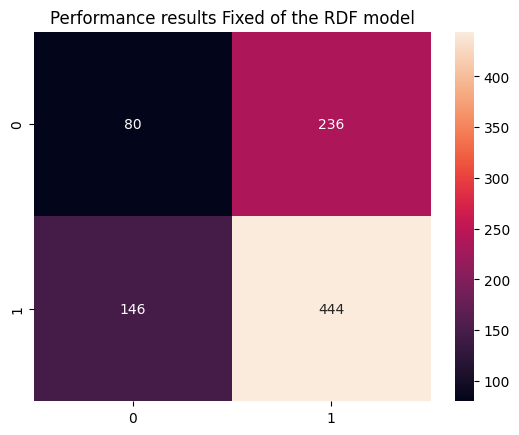


Feature Importance of the model



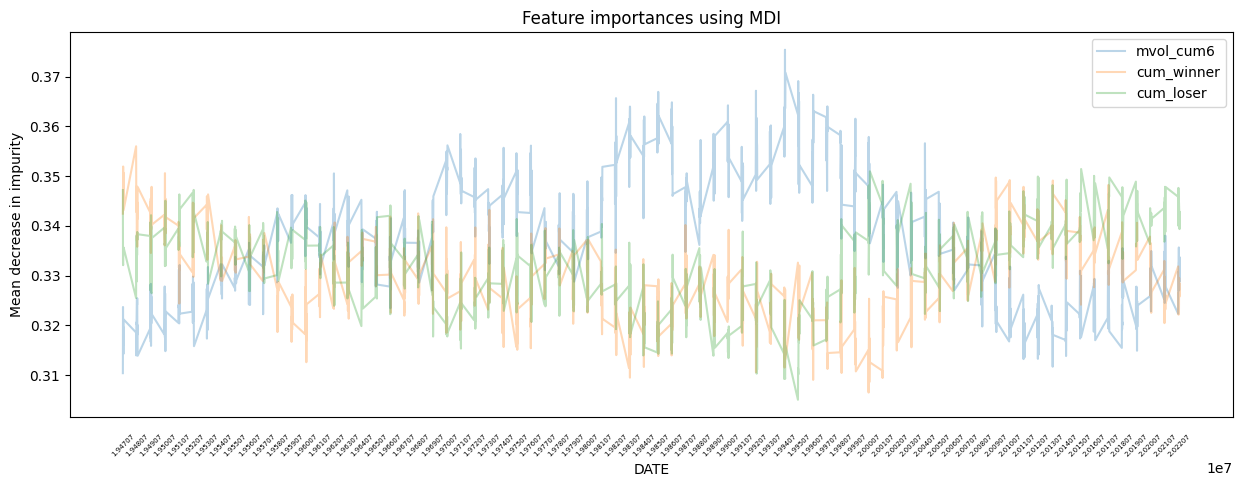

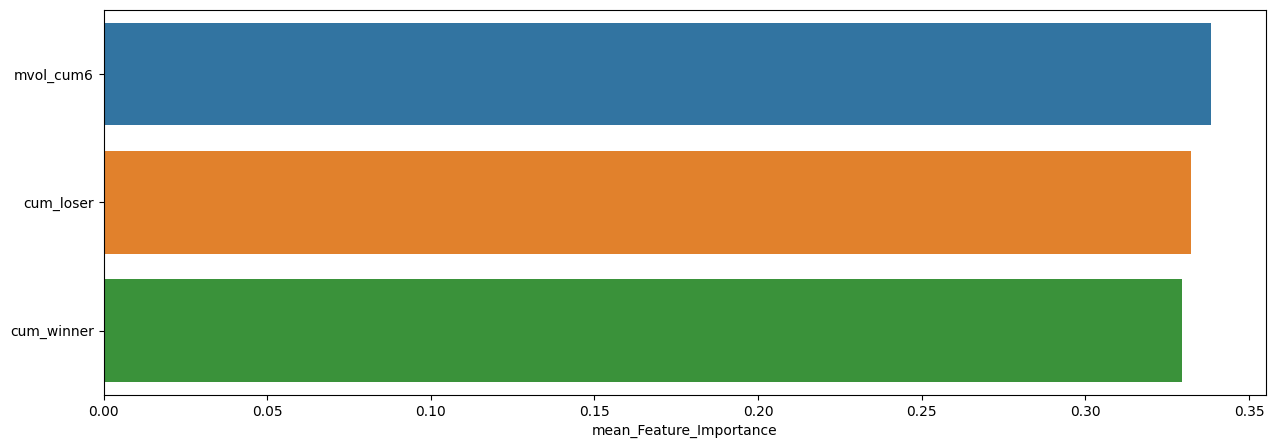

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.338323                0.375425   
cum_loser                  0.332154                0.351433   
cum_winner                 0.329524                0.356004   

            min_Feature_Importance  
mvol_cum6                 0.310359  
cum_loser                 0.305015  
cum_winner                0.306459

In [23]:
Fixed_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=RDF, # 사용할 모델
                                  model_name='RDF', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.31      0.34        75
         1.0       0.68      0.74      0.71       151

    accuracy                           0.60       226
   macro avg       0.53      0.52      0.52       226
weighted avg       0.58      0.60      0.59       226


accuracy : 0.5973451327433629

precision : 0.6829268292682927

recall : 0.7417218543046358

F1-Score : 0.7111111111111112



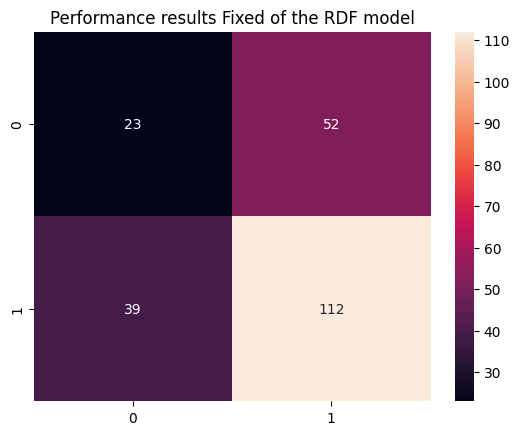


Feature Importance of the model



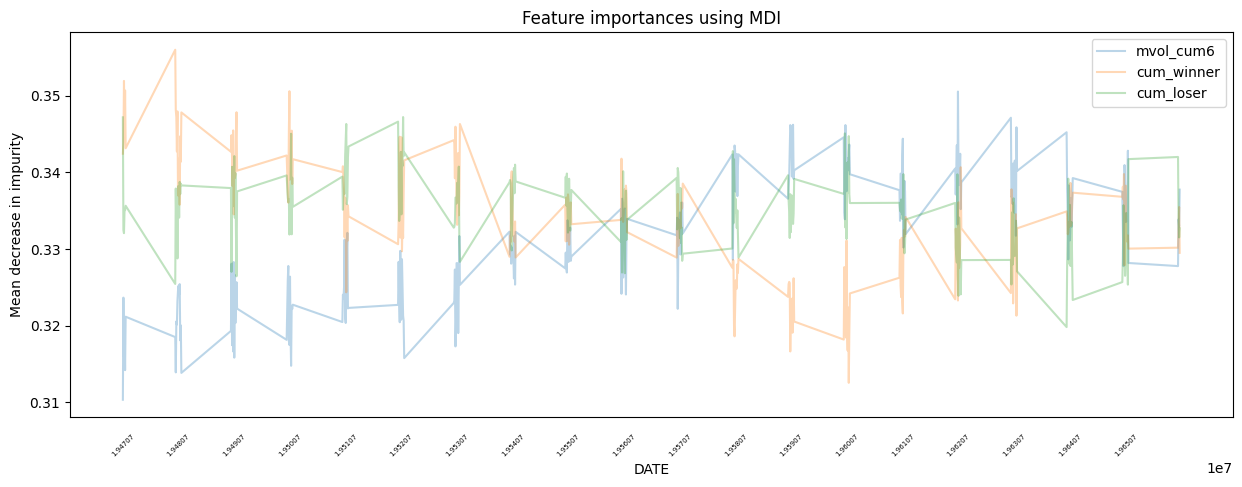

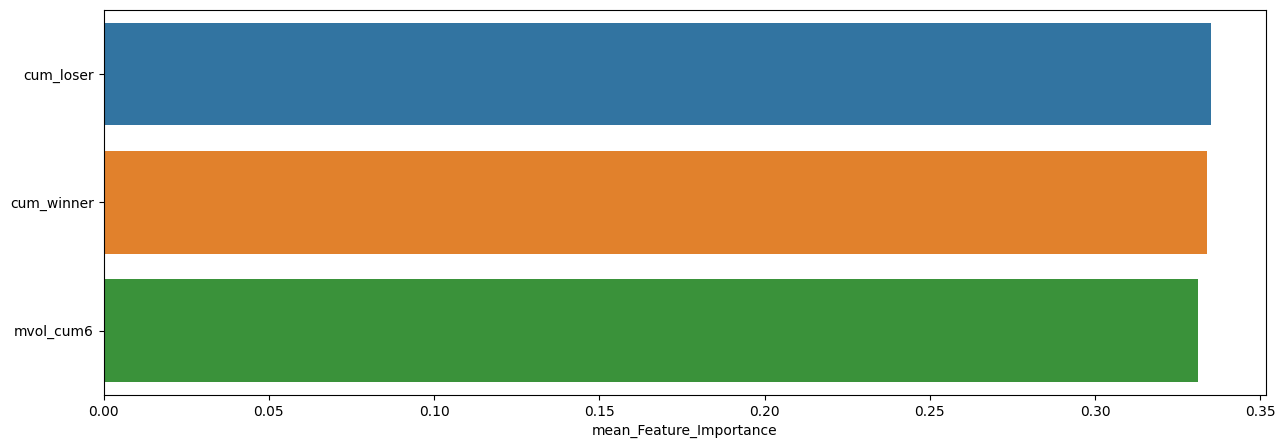

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                  0.335002                0.347225   
cum_winner                 0.333755                0.356004   
mvol_cum6                  0.331243                0.350550   

            min_Feature_Importance  
cum_loser                 0.319836  
cum_winner                0.312565  
mvol_cum6                 0.310359


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.23      0.29        75
         1.0       0.68      0.82      0.74       151

    accuracy                           0.62       226
   macro avg       0.53      0.52      0.52       226
weighted avg       0.58      0.62      0.59       226


accuracy : 0.6238938053097345

precision : 0.6813186813186813

recall : 0.8211920529801324

F1-Score : 0.7447447447447448



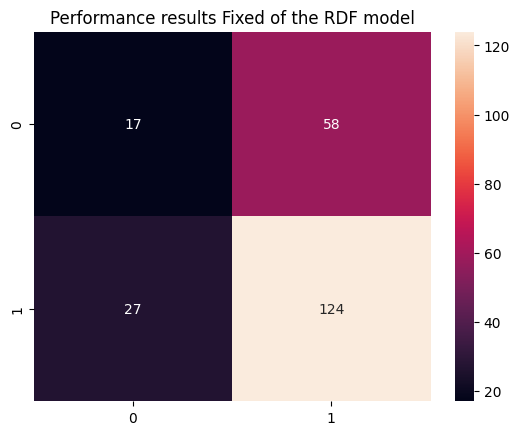


Feature Importance of the model



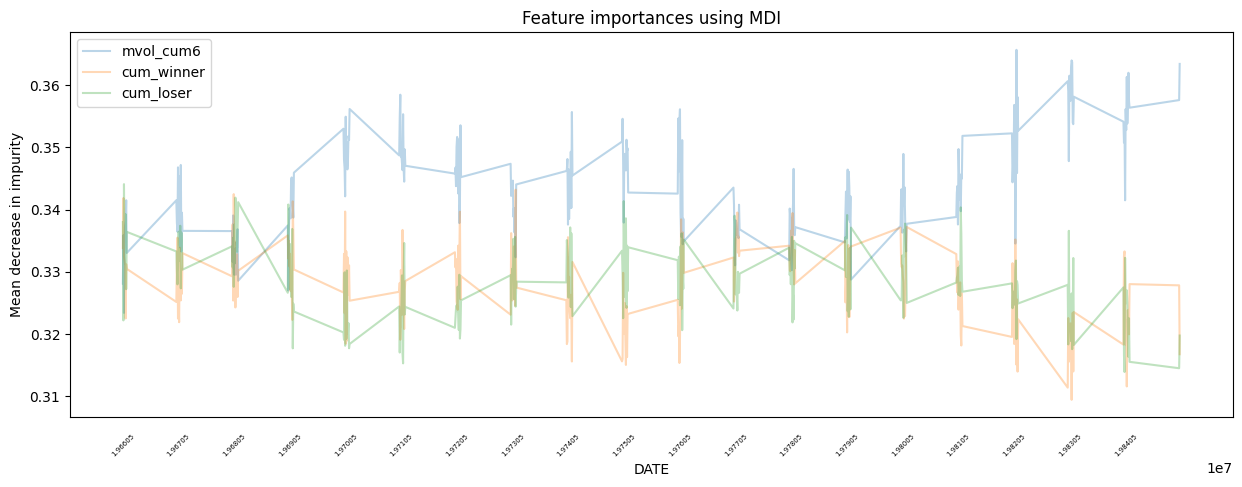

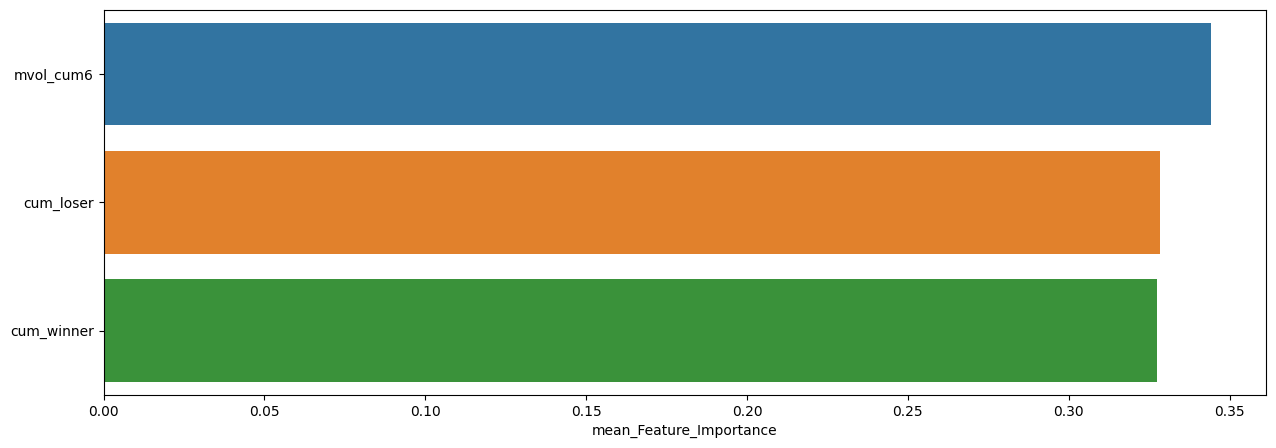

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.344131                0.365690   
cum_loser                  0.328373                0.344110   
cum_winner                 0.327496                0.343217   

            min_Feature_Importance  
mvol_cum6                 0.323422  
cum_loser                 0.313923  
cum_winner                0.309457


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.24      0.16      0.19        70
         1.0       0.67      0.78      0.72       156

    accuracy                           0.59       226
   macro avg       0.46      0.47      0.46       226
weighted avg       0.54      0.59      0.56       226


accuracy : 0.588495575221239

precision : 0.6740331491712708

recall : 0.782051282051282

F1-Score : 0.7240356083086054



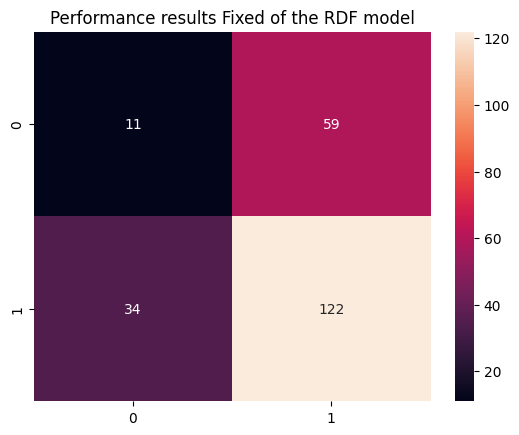


Feature Importance of the model



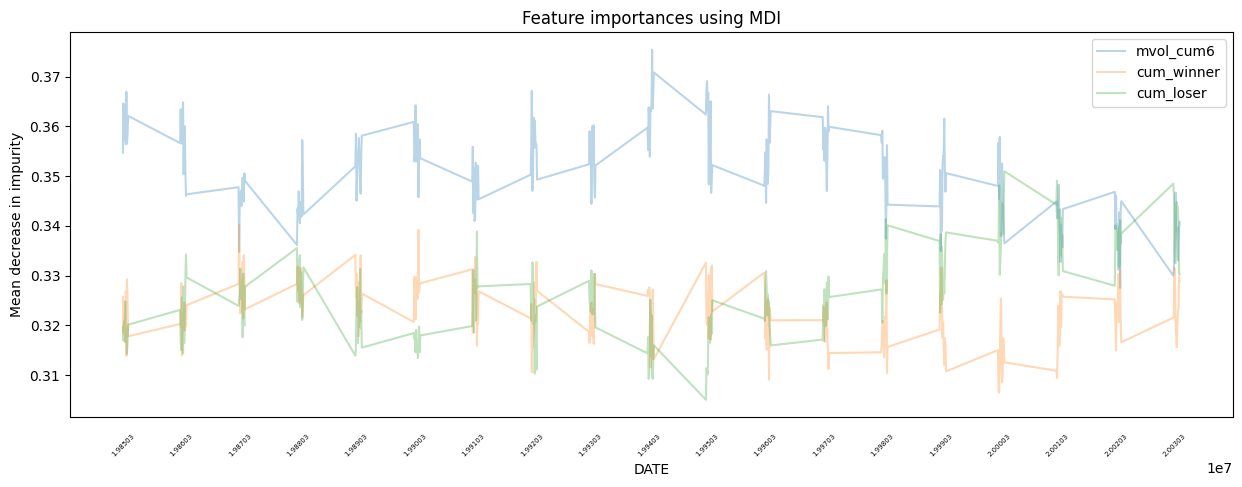

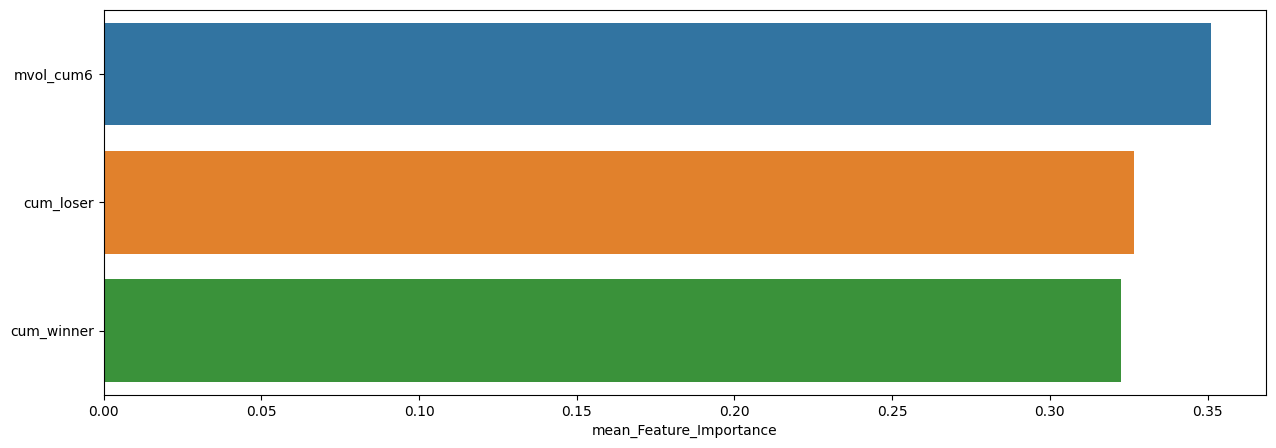

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.350984                0.375425   
cum_loser                  0.326506                0.350972   
cum_winner                 0.322510                0.340165   

            min_Feature_Importance  
mvol_cum6                 0.327526  
cum_loser                 0.305015  
cum_winner                0.306459


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.30      0.34        96
         1.0       0.56      0.65      0.60       132

    accuracy                           0.50       228
   macro avg       0.47      0.48      0.47       228
weighted avg       0.49      0.50      0.49       228


accuracy : 0.5043859649122807

precision : 0.5620915032679739

recall : 0.6515151515151515

F1-Score : 0.6035087719298244



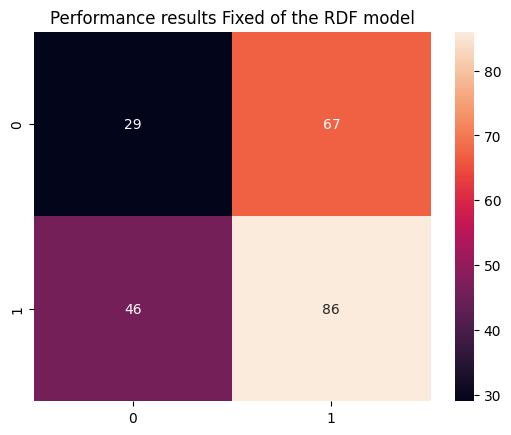


Feature Importance of the model



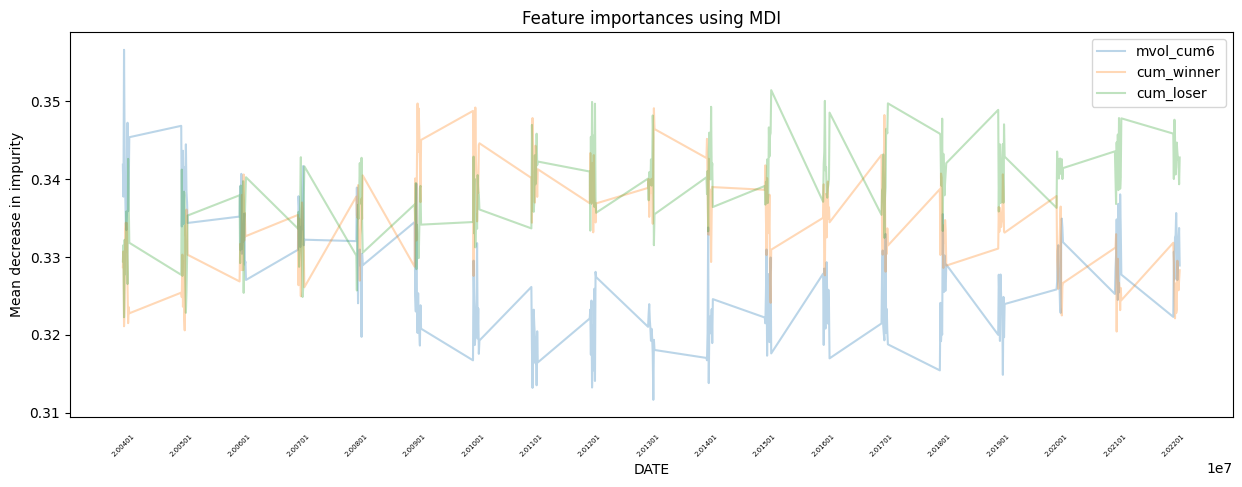

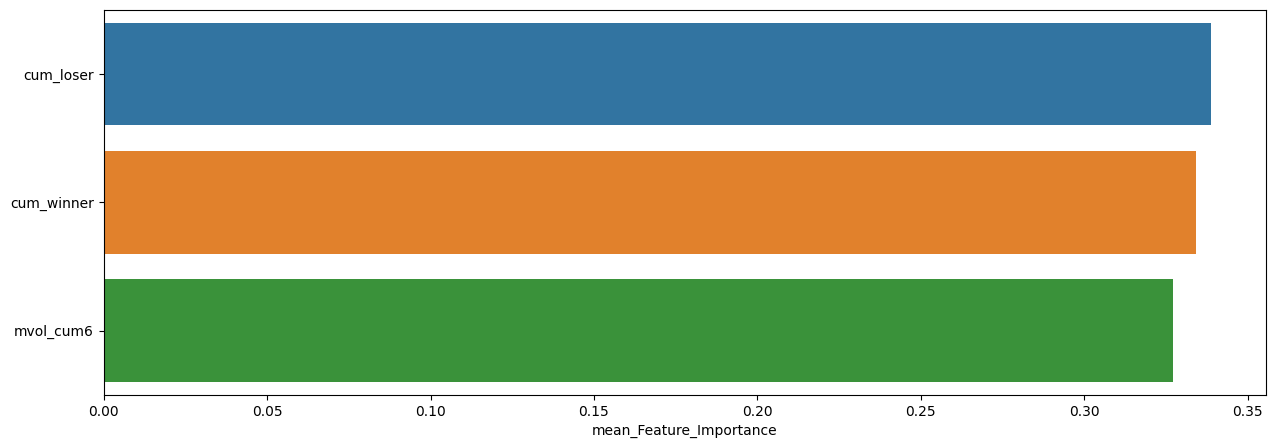

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                  0.338676                0.351433   
cum_winner                 0.334292                0.349718   
mvol_cum6                  0.327033                0.356613   

            min_Feature_Importance  
cum_loser                 0.322277  
cum_winner                0.320429  
mvol_cum6                 0.311662

In [24]:
slice_feature_importance(Fixed_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



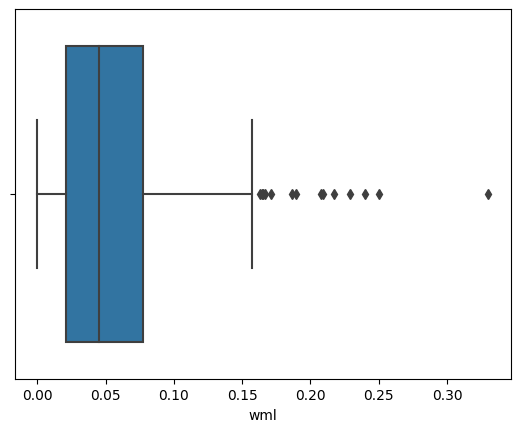

count      mean       std       min       25%      50%       75%  \
wml  444.0  0.055006  0.046131  0.000128  0.021416  0.04509  0.077301   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



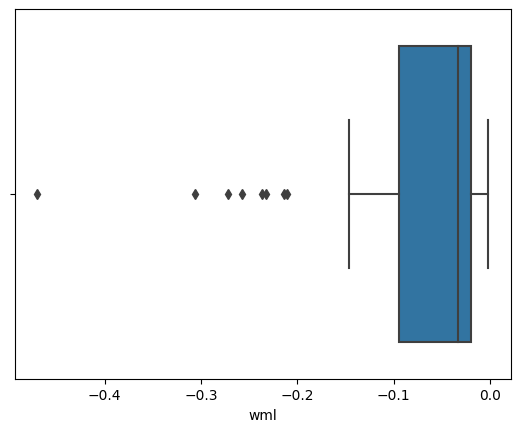

count      mean       std       min       25%       50%      75%  \
wml   80.0 -0.067374  0.082627 -0.469903 -0.094524 -0.033258 -0.01924   

          max  
wml -0.001641


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



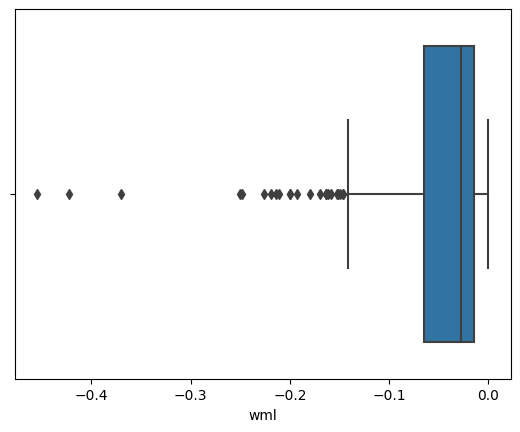

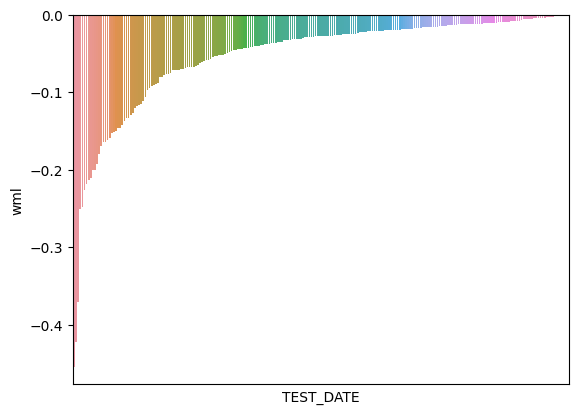

count      mean       std       min       25%       50%     75%       max
wml  236.0 -0.052561  0.066716 -0.454349 -0.065239 -0.027349 -0.0141 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



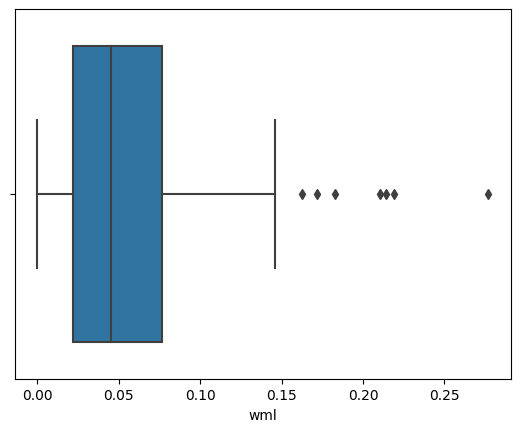

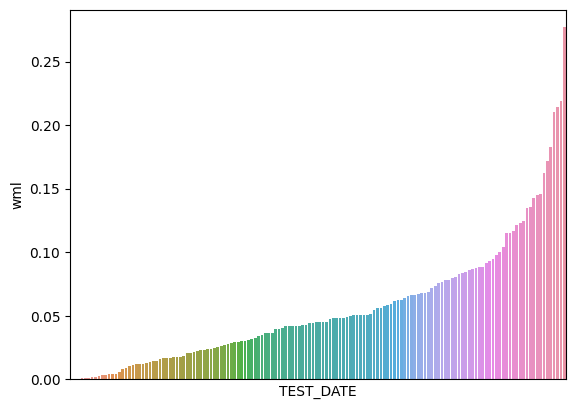

count      mean       std       min       25%       50%       75%  \
wml  146.0  0.055992  0.048977  0.000007  0.021976  0.045066  0.076363   

          max  
wml  0.276912

In [25]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Fixed_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.67741

최근 누적 수익률

  2022년-12월 -> 20674.94
  2022년-11월 -> 18627.66
  2022년-10월 -> 17718.79
  2022년-09월 -> 15689.65
  2022년-08월 -> 15689.65

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-07월 -> 58302.14
  2등 : 2002년-06월 -> 58302.14
  3등 : 2002년-09월 -> 56613.05
  4등 : 2002년-08월 -> 56613.05
  5등 : 2002년-05월 -> 50132.90
  6등 : 2002년-02월 -> 48512.95
  7등 : 2002년-04월 -> 46498.57
  8등 : 2002년-03월 -> 46498.57
  9등 : 2001년-09월 -> 46095.53
  10등 : 2008년-06월 -> 45980.60



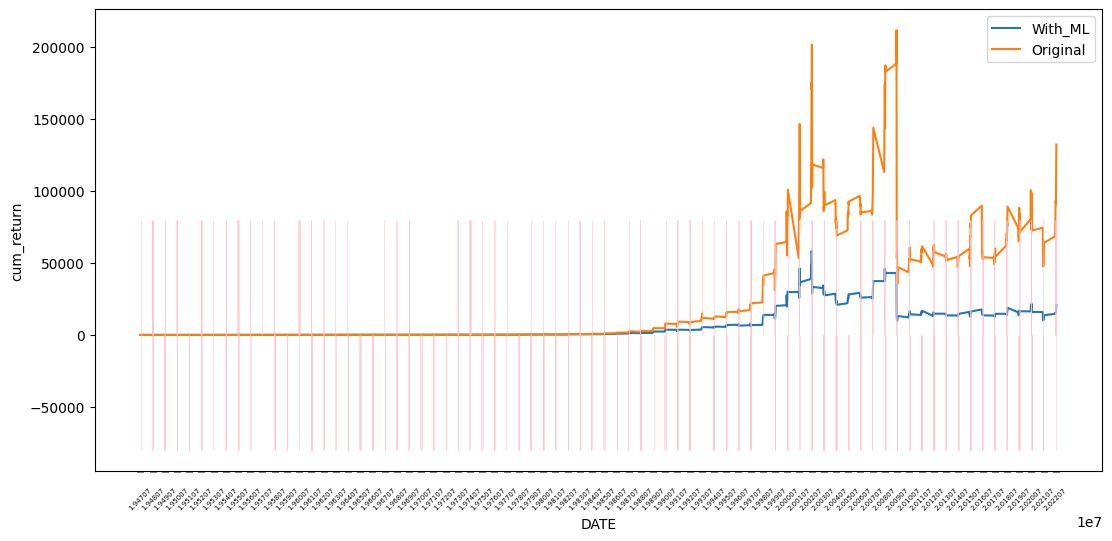

In [26]:
RDF_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.74474

최근 누적 수익률

  2022년-12월 -> 8490.57
  2022년-11월 -> 7757.31
  2022년-10월 -> 7544.45
  2022년-09월 -> 6805.10
  2022년-08월 -> 6493.58

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 8490.57
  2등 : 2002년-09월 -> 8475.99
  3등 : 2009년-02월 -> 8292.17
  4등 : 2002년-07월 -> 8061.30
  5등 : 2008년-11월 -> 7943.22
  6등 : 2002년-08월 -> 7925.82
  7등 : 2002년-06월 -> 7905.59
  8등 : 2009년-01월 -> 7866.23
  9등 : 2008년-12월 -> 7789.04
  10등 : 2022년-11월 -> 7757.31



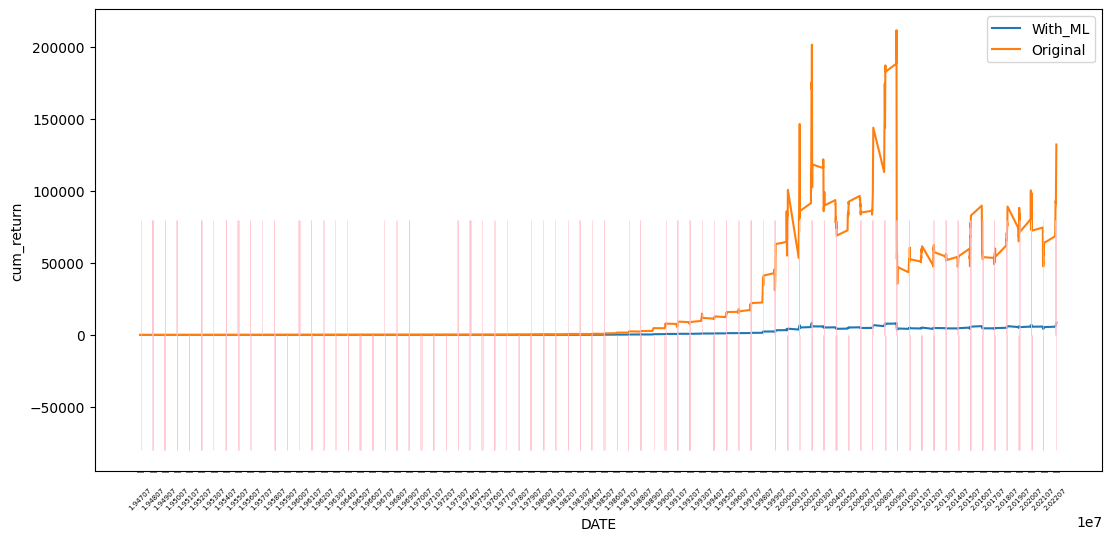

In [27]:
RDF_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [28]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.26      0.30       316
         1.0       0.65      0.74      0.69       590

    accuracy                           0.57       906
   macro avg       0.50      0.50      0.49       906
weighted avg       0.54      0.57      0.55       906


accuracy : 0.5717439293598234

precision : 0.6507462686567164

recall : 0.7389830508474576

F1-Score : 0.692063492063492



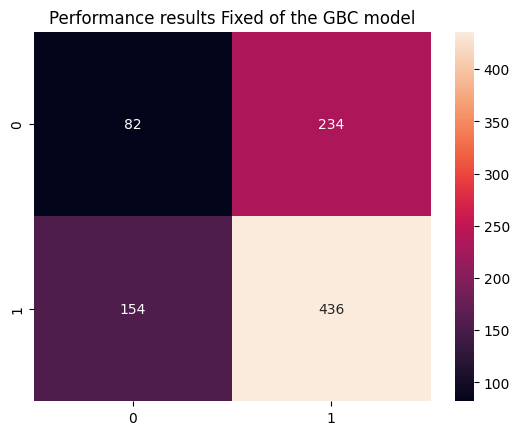


Feature Importance of the model



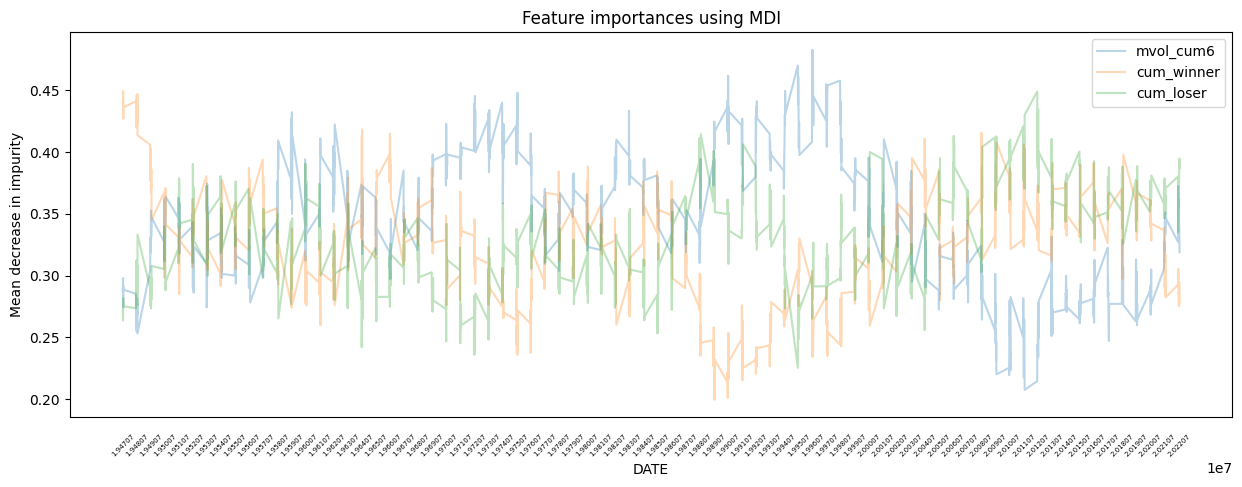

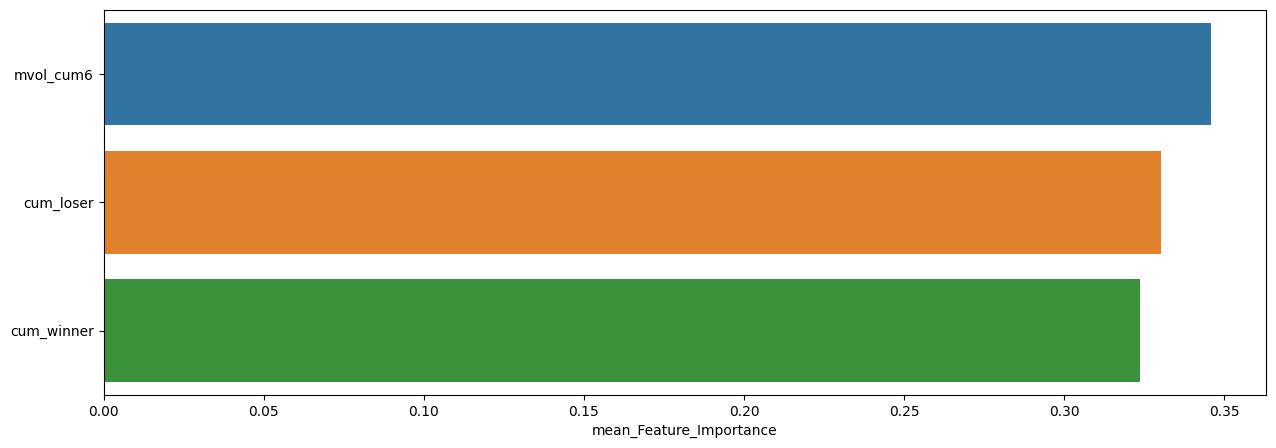

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.345774                0.482954   
cum_loser                  0.330396                0.449114   
cum_winner                 0.323830                0.449536   

            min_Feature_Importance  
mvol_cum6                 0.207459  
cum_loser                 0.225292  
cum_winner                0.199410

In [29]:
Fixed_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=GBC, # 사용할 모델
                                  model_name='GBC', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.25      0.29        75
         1.0       0.67      0.75      0.71       151

    accuracy                           0.58       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.56      0.58      0.57       226


accuracy : 0.584070796460177

precision : 0.6686390532544378

recall : 0.7483443708609272

F1-Score : 0.7062499999999999



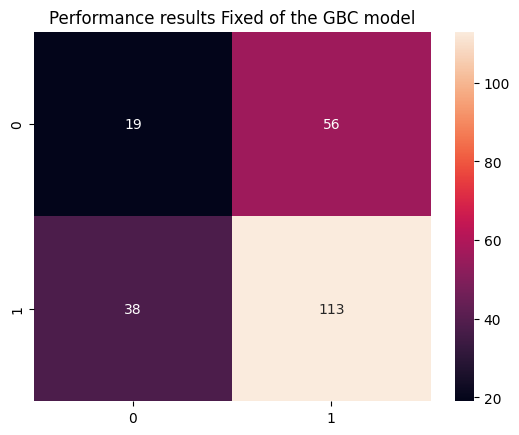


Feature Importance of the model



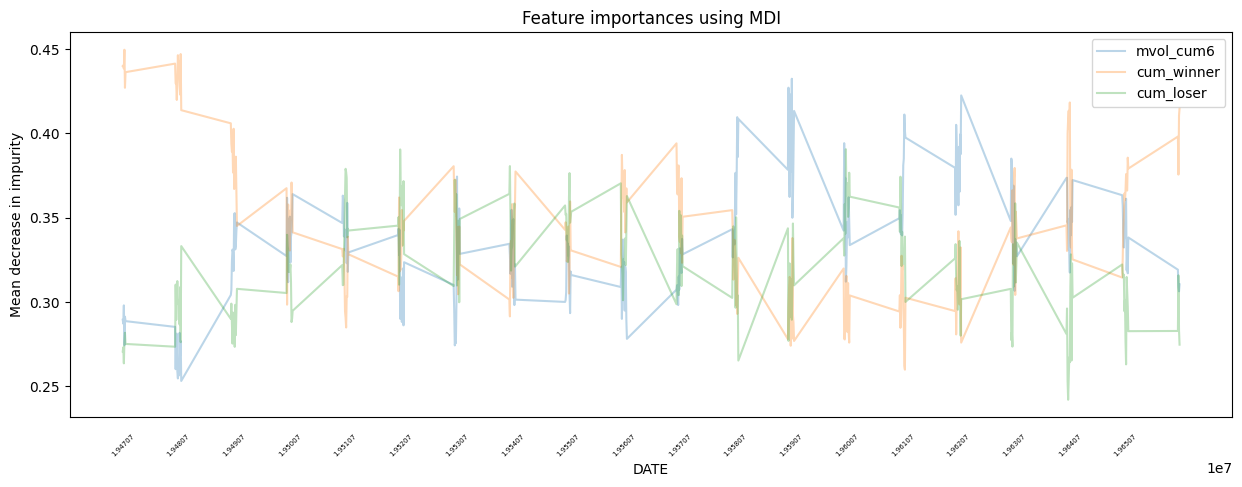

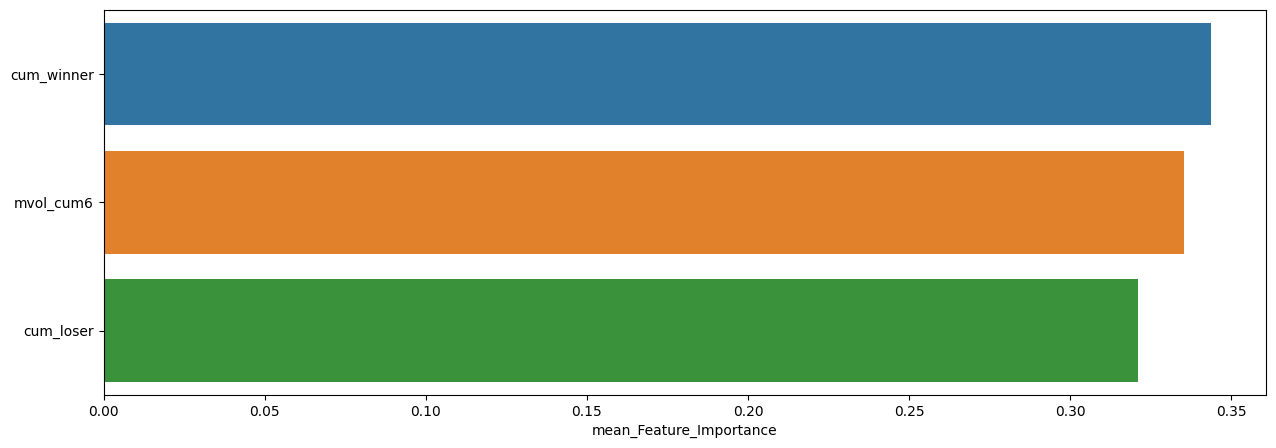

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.343645                0.449536   
mvol_cum6                  0.335326                0.432344   
cum_loser                  0.321029                0.390556   

            min_Feature_Importance  
cum_winner                0.259869  
mvol_cum6                 0.253164  
cum_loser                 0.242035


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.42      0.29      0.35        75
         1.0       0.70      0.80      0.74       151

    accuracy                           0.63       226
   macro avg       0.56      0.55      0.55       226
weighted avg       0.61      0.63      0.61       226


accuracy : 0.6327433628318584

precision : 0.6954022988505747

recall : 0.8013245033112583

F1-Score : 0.7446153846153847



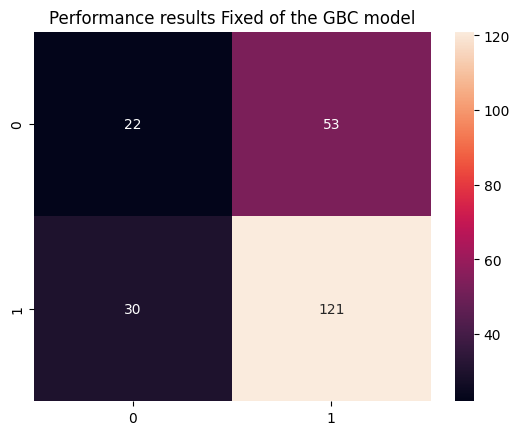


Feature Importance of the model



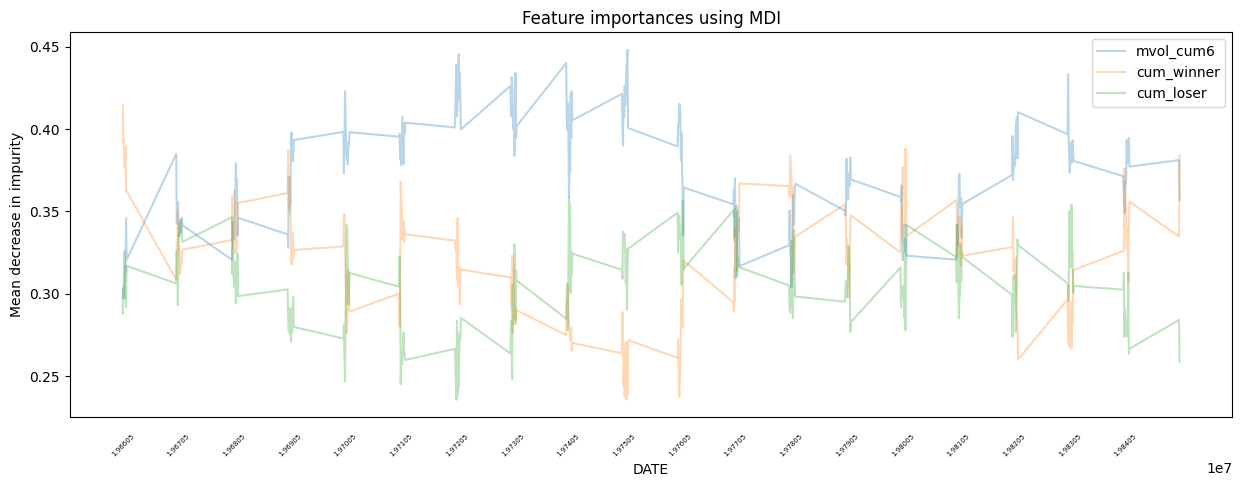

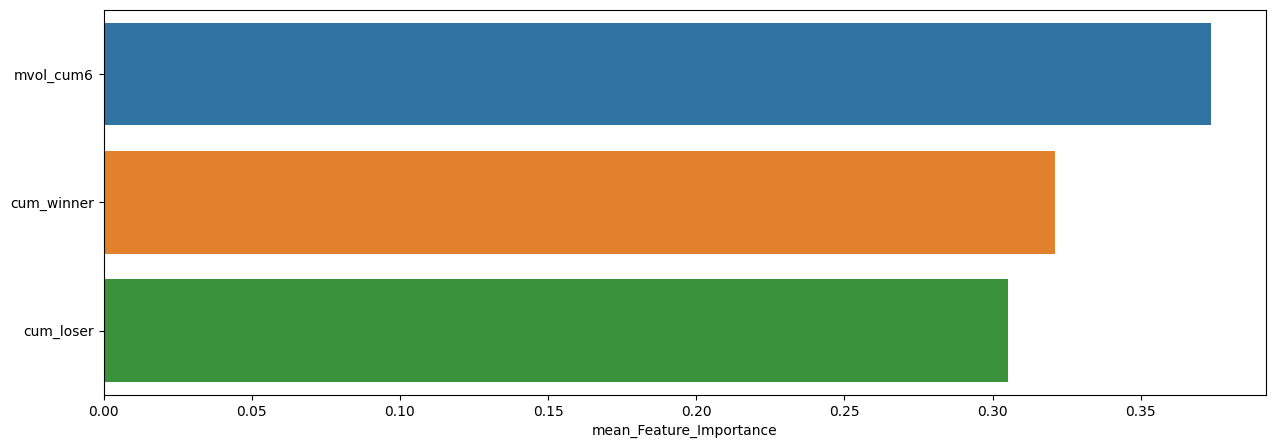

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.373612                0.448124   
cum_winner                 0.321077                0.414701   
cum_loser                  0.305311                0.358474   

            min_Feature_Importance  
mvol_cum6                 0.297352  
cum_winner                0.235763  
cum_loser                 0.235688


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.25      0.20      0.22        70
         1.0       0.67      0.73      0.70       156

    accuracy                           0.57       226
   macro avg       0.46      0.47      0.46       226
weighted avg       0.54      0.57      0.55       226


accuracy : 0.5663716814159292

precision : 0.6705882352941176

recall : 0.7307692307692307

F1-Score : 0.6993865030674846



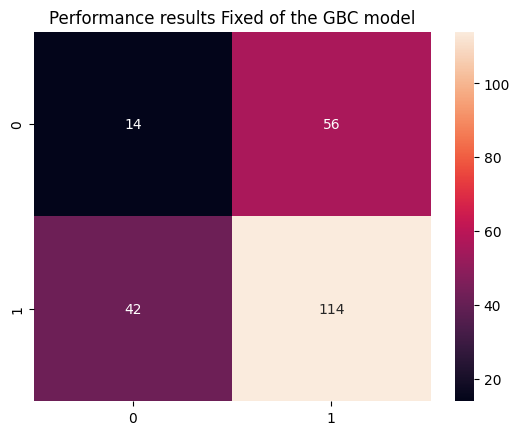


Feature Importance of the model



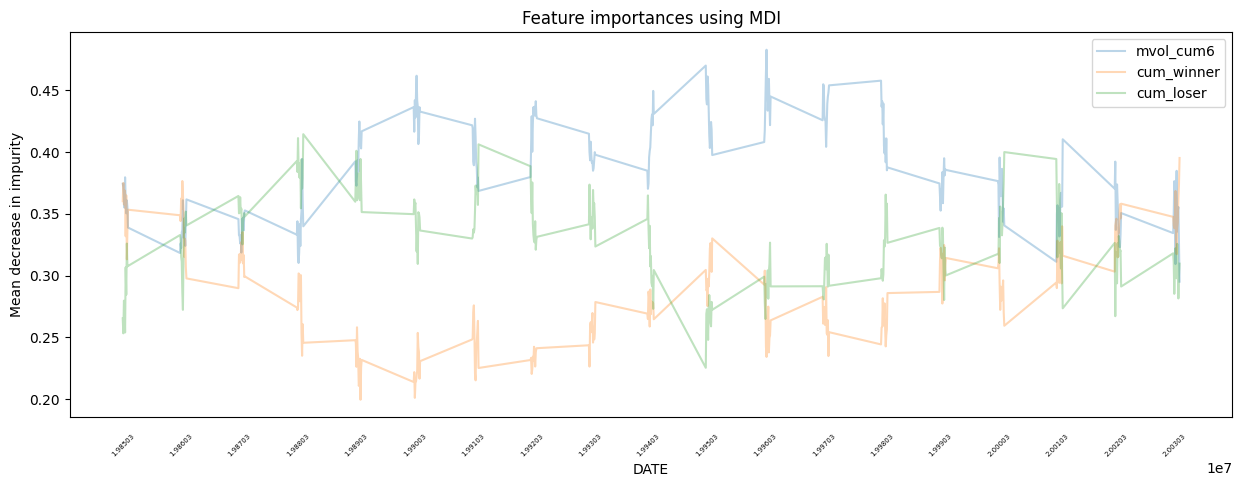

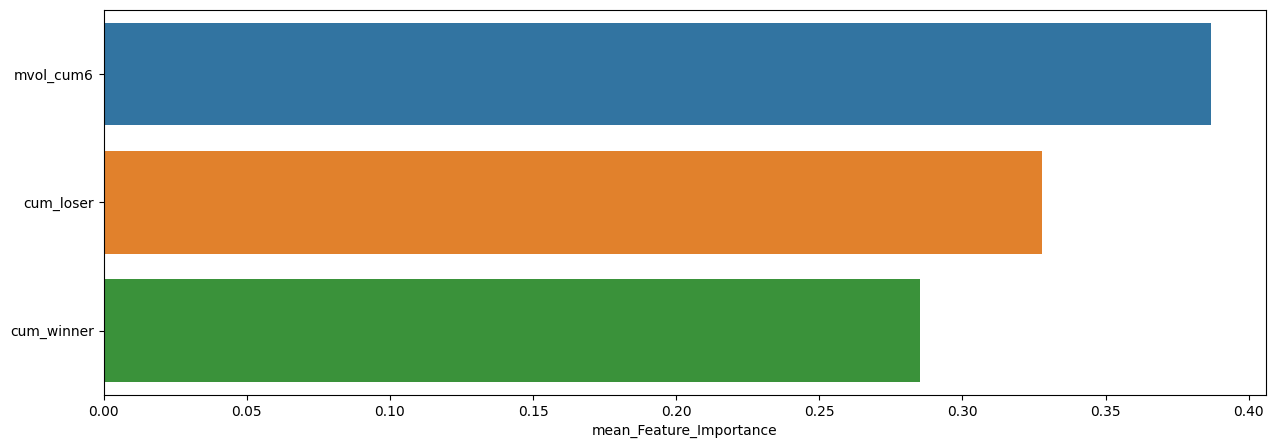

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.386736                0.482954   
cum_loser                  0.327933                0.414535   
cum_winner                 0.285331                0.395266   

            min_Feature_Importance  
mvol_cum6                 0.295083  
cum_loser                 0.225292  
cum_winner                0.199410


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.28      0.32        96
         1.0       0.56      0.67      0.61       132

    accuracy                           0.50       228
   macro avg       0.47      0.47      0.47       228
weighted avg       0.48      0.50      0.49       228


accuracy : 0.5043859649122807

precision : 0.5605095541401274

recall : 0.6666666666666666

F1-Score : 0.6089965397923875



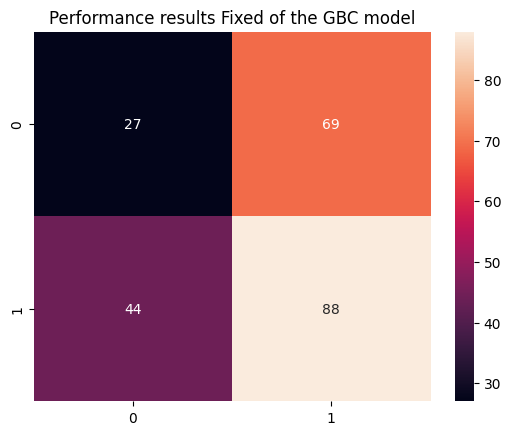


Feature Importance of the model



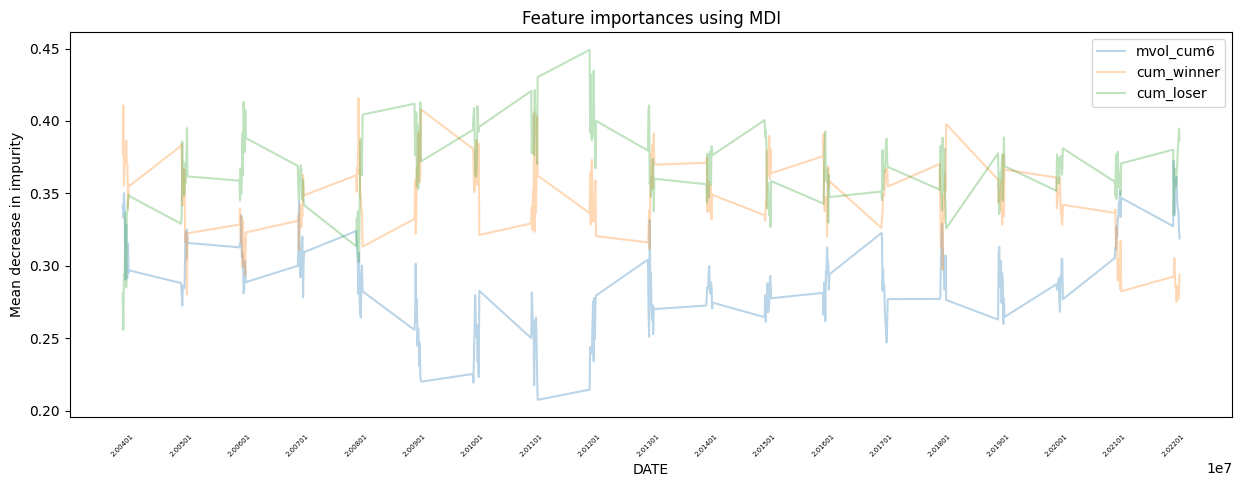

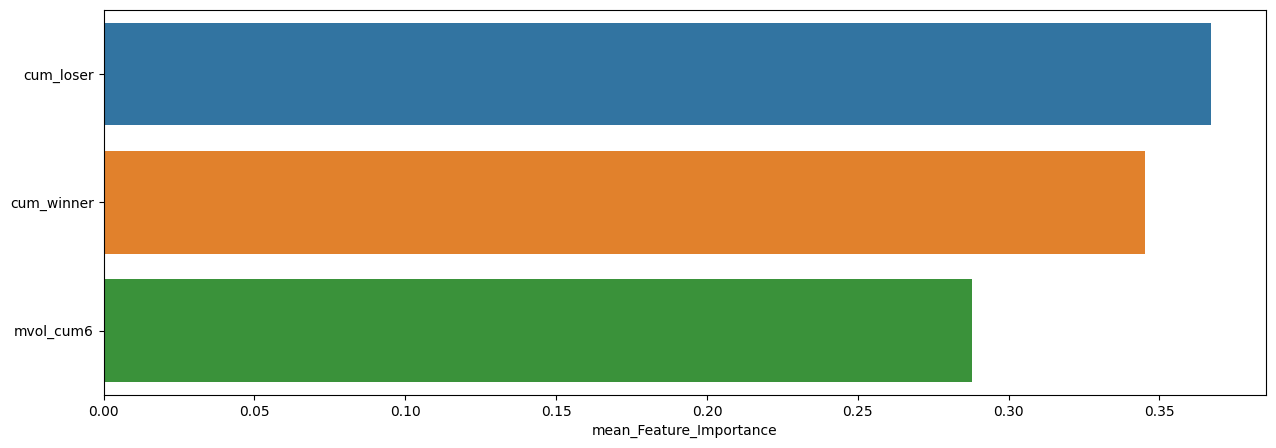

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                  0.366985                0.449114   
cum_winner                 0.345080                0.415736   
mvol_cum6                  0.287935                0.372508   

            min_Feature_Importance  
cum_loser                 0.255766  
cum_winner                0.275187  
mvol_cum6                 0.207459

In [30]:
slice_feature_importance(Fixed_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



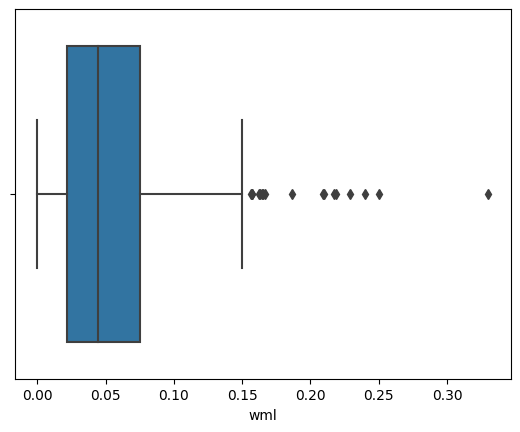

count      mean       std       min       25%       50%       75%  \
wml  436.0  0.054969  0.046468  0.000128  0.021843  0.044598  0.075557   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



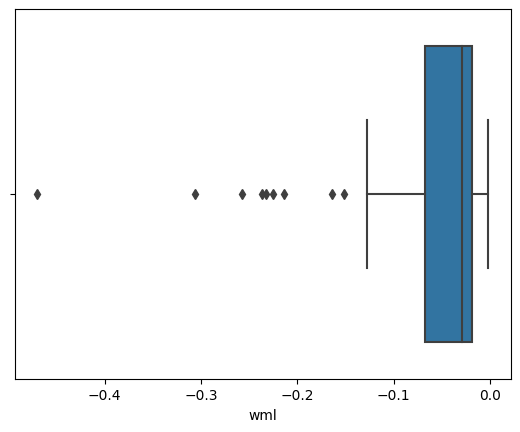

count      mean       std       min       25%       50%       75%  \
wml   82.0 -0.060637  0.079407 -0.469903 -0.067498 -0.029299 -0.018128   

          max  
wml -0.001641


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



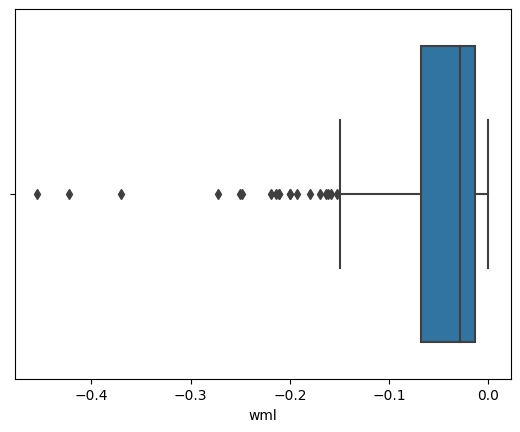

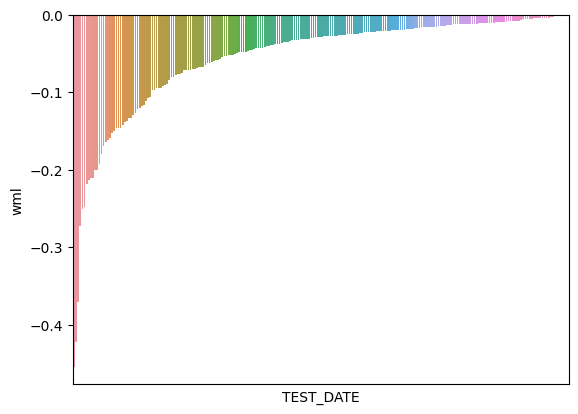

count      mean      std       min       25%       50%       75%  \
wml  234.0 -0.054795  0.06826 -0.454349 -0.068203 -0.028581 -0.013893   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



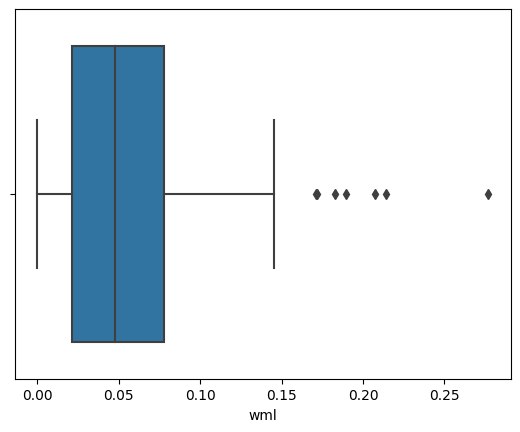

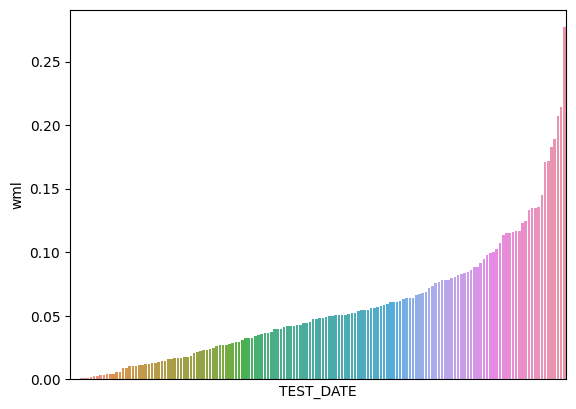

count      mean       std       min       25%       50%       75%  \
wml  154.0  0.056043  0.047914  0.000007  0.020954  0.047829  0.077661   

          max  
wml  0.276912

In [31]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Fixed_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.66671

최근 누적 수익률

  2022년-12월 -> 8303.49
  2022년-11월 -> 7481.20
  2022년-10월 -> 7481.20
  2022년-09월 -> 6624.39
  2022년-08월 -> 6022.47

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-07월 -> 34170.33
  2등 : 2002년-06월 -> 34170.33
  3등 : 2002년-09월 -> 33180.36
  4등 : 2002년-08월 -> 33180.36
  5등 : 2002년-05월 -> 29382.36
  6등 : 2002년-04월 -> 27252.29
  7등 : 2002년-10월 -> 26771.50
  8등 : 2002년-02월 -> 23493.83
  9등 : 2008년-11월 -> 22669.57
  10등 : 2002년-03월 -> 22518.28



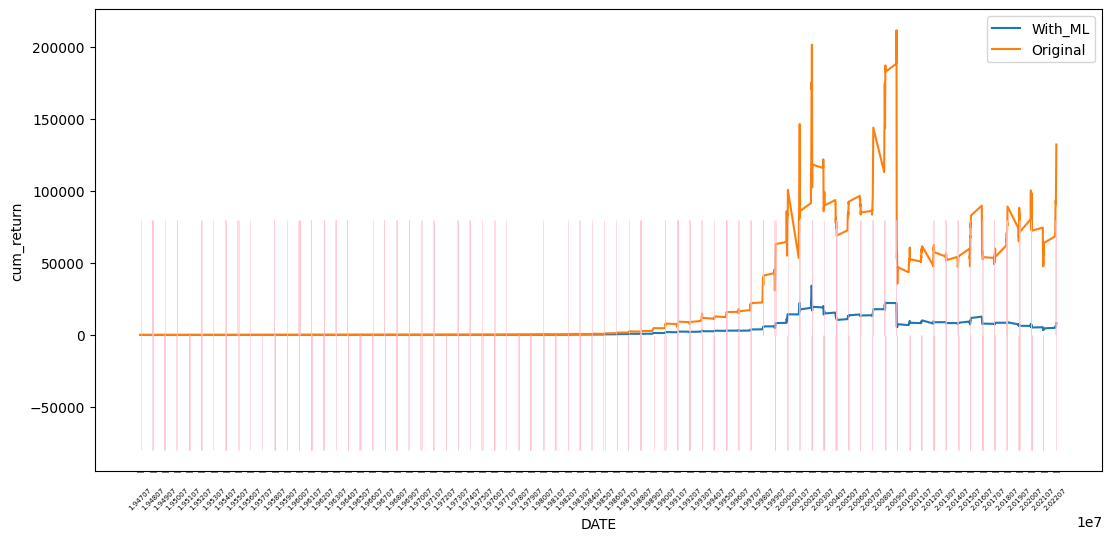

In [32]:
GBC_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.72478

최근 누적 수익률

  2022년-12월 -> 7148.15
  2022년-11월 -> 6527.71
  2022년-10월 -> 6441.68
  2022년-09월 -> 5818.32
  2022년-08월 -> 5517.00

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 11217.88
  2등 : 2009년-02월 -> 11072.42
  3등 : 2008년-11월 -> 10884.36
  4등 : 2009년-01월 -> 10662.69
  5등 : 2008년-12월 -> 10642.32
  6등 : 2002년-07월 -> 10627.17
  7등 : 2002년-08월 -> 10453.35
  8등 : 2002년-06월 -> 10368.42
  9등 : 2008년-10월 -> 10026.83
  10등 : 2008년-06월 -> 9913.52



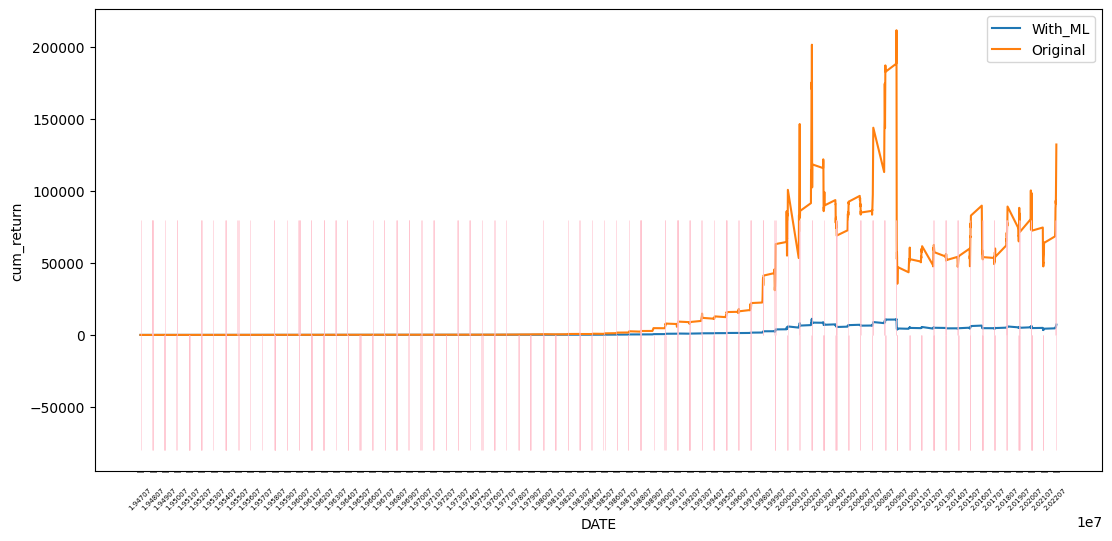

In [33]:
GBC_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PROB_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

### XGB

In [34]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : None
 

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.33      0.35       316
         1.0       0.66      0.70      0.68       590

    accuracy                           0.57       906
   macro avg       0.52      0.52      0.51       906
weighted avg       0.56      0.57      0.56       906


accuracy : 0.5706401766004415

precision : 0.6613162118780096

recall : 0.6983050847457627

F1-Score : 0.6793075020610057



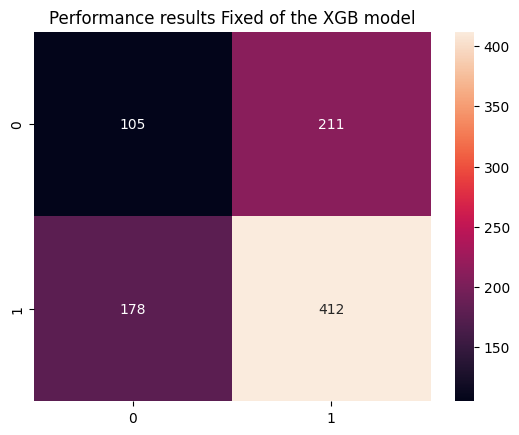


Feature Importance of the model



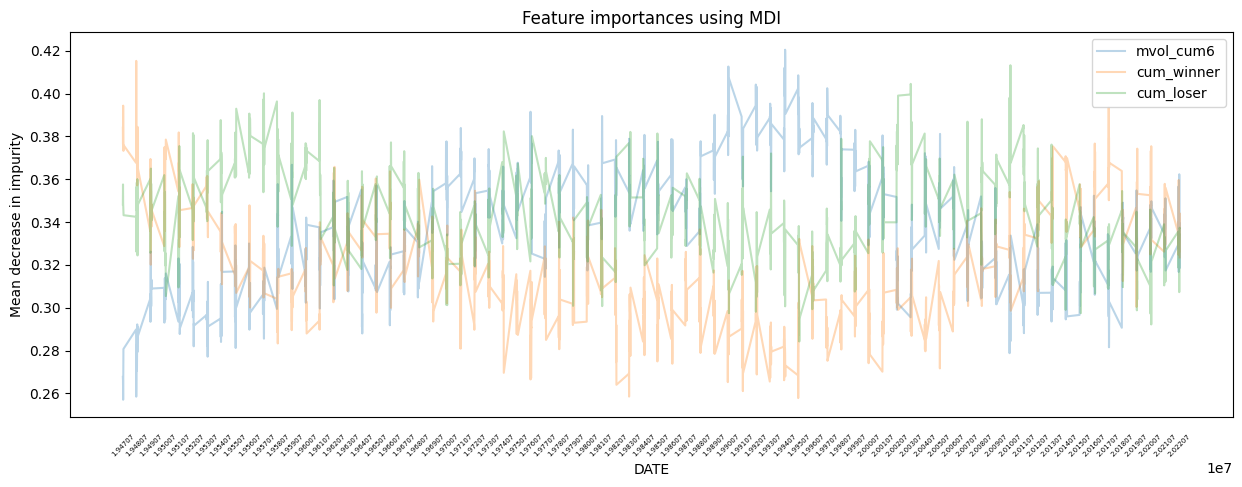

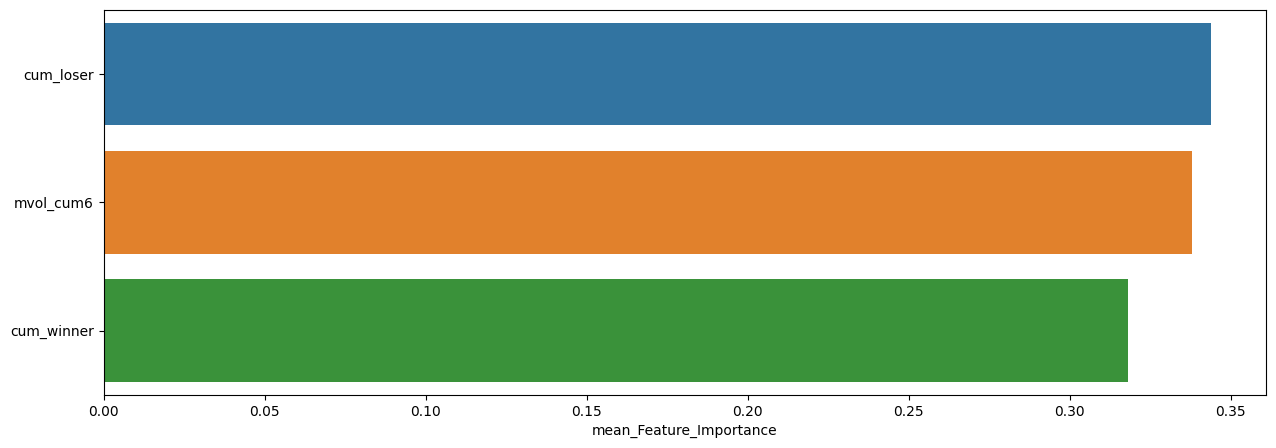

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                  0.343834                0.413285   
mvol_cum6                  0.338072                0.420533   
cum_winner                 0.318094                0.415323   

            min_Feature_Importance  
cum_loser                 0.284215  
mvol_cum6                 0.256996  
cum_winner                0.257780

In [35]:
Fixed_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.36      0.36        75
         1.0       0.68      0.67      0.67       151

    accuracy                           0.57       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.57      0.57      0.57       226


accuracy : 0.5663716814159292

precision : 0.6778523489932886

recall : 0.6688741721854304

F1-Score : 0.6733333333333333



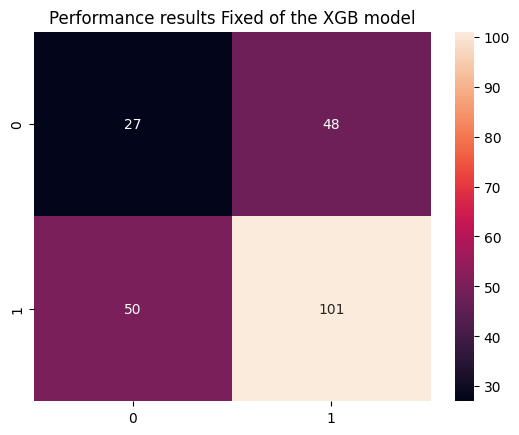


Feature Importance of the model



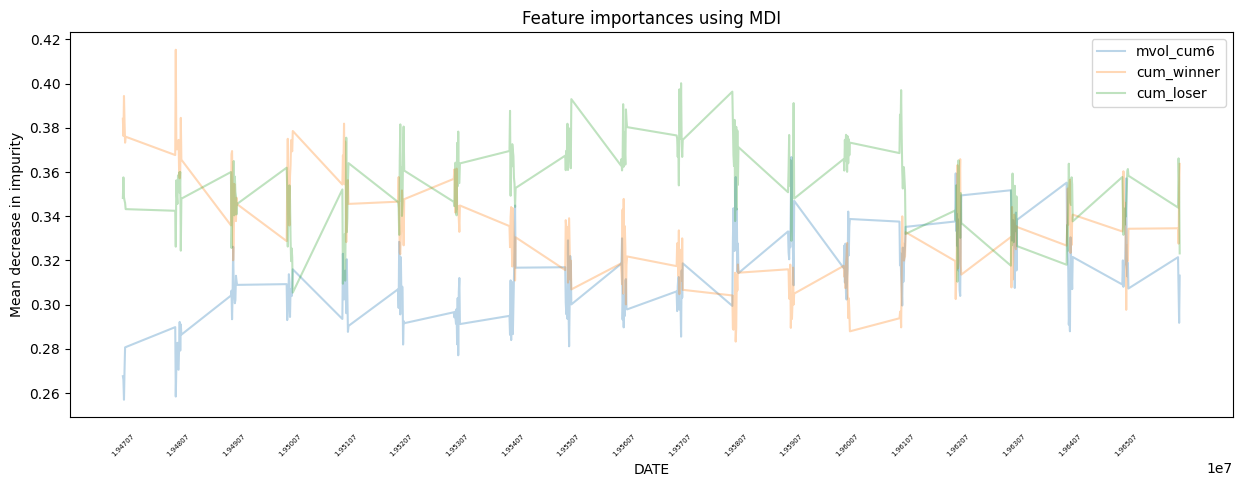

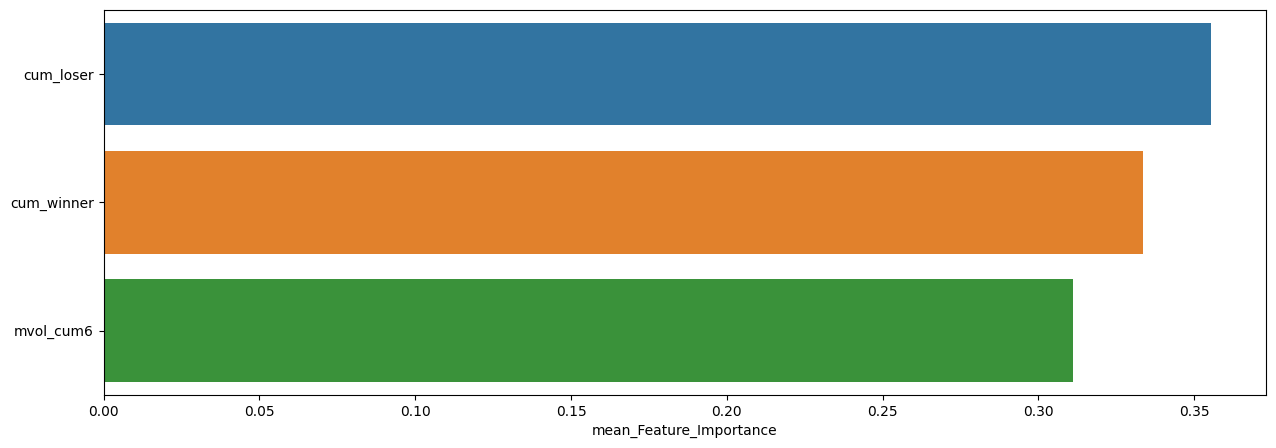

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                  0.355273                0.400171   
cum_winner                 0.333562                0.415323   
mvol_cum6                  0.311165                0.366788   

            min_Feature_Importance  
cum_loser                 0.305444  
cum_winner                0.283297  
mvol_cum6                 0.256996


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.41      0.32      0.36        75
         1.0       0.69      0.77      0.73       151

    accuracy                           0.62       226
   macro avg       0.55      0.54      0.54       226
weighted avg       0.60      0.62      0.61       226


accuracy : 0.6194690265486725

precision : 0.6946107784431138

recall : 0.7682119205298014

F1-Score : 0.729559748427673



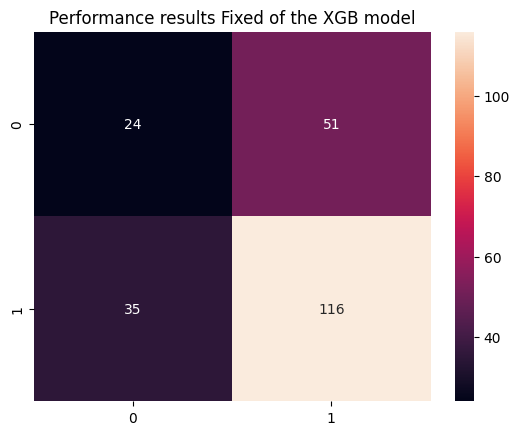


Feature Importance of the model



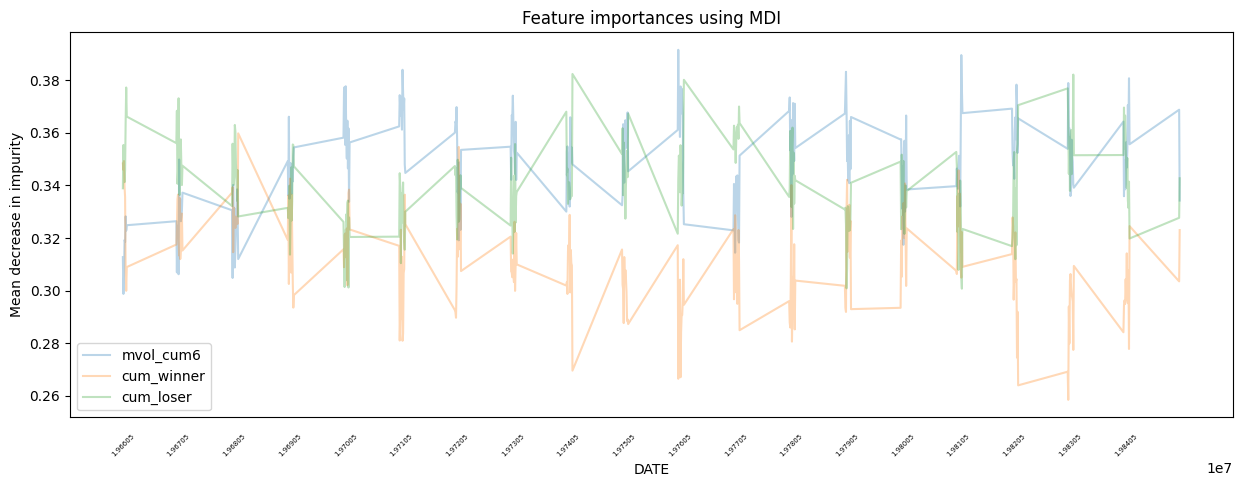

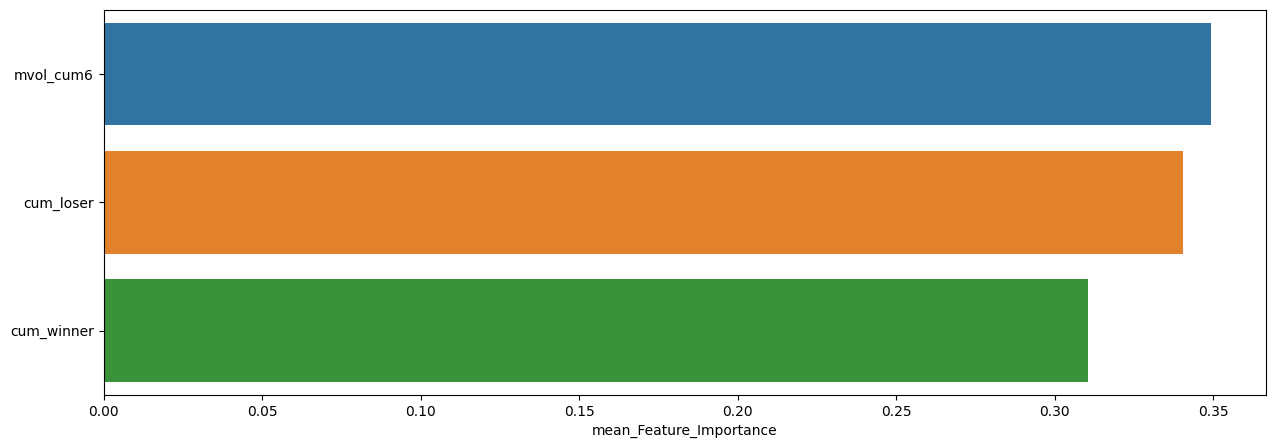

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.349160                0.391562   
cum_loser                  0.340308                0.382378   
cum_winner                 0.310532                0.359799   

            min_Feature_Importance  
mvol_cum6                 0.298753  
cum_loser                 0.300742  
cum_winner                0.258476


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.30      0.30        70
         1.0       0.69      0.69      0.69       156

    accuracy                           0.57       226
   macro avg       0.49      0.49      0.49       226
weighted avg       0.57      0.57      0.57       226


accuracy : 0.5663716814159292

precision : 0.6858974358974359

recall : 0.6858974358974359

F1-Score : 0.6858974358974359



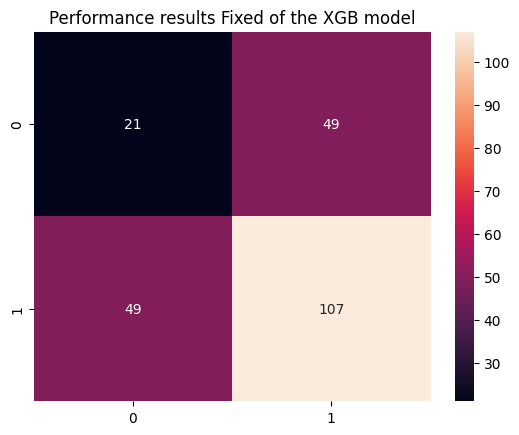


Feature Importance of the model



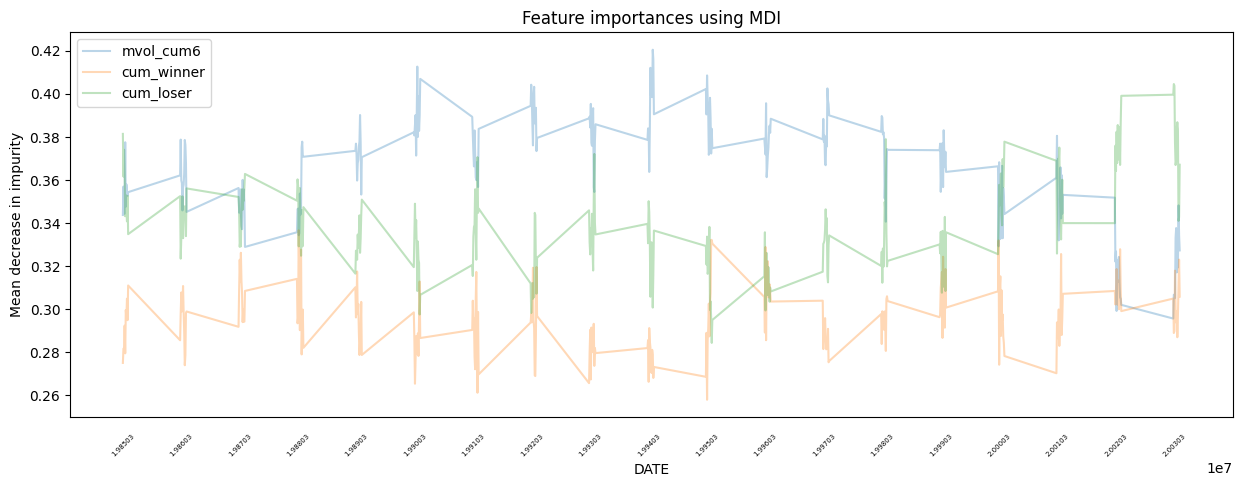

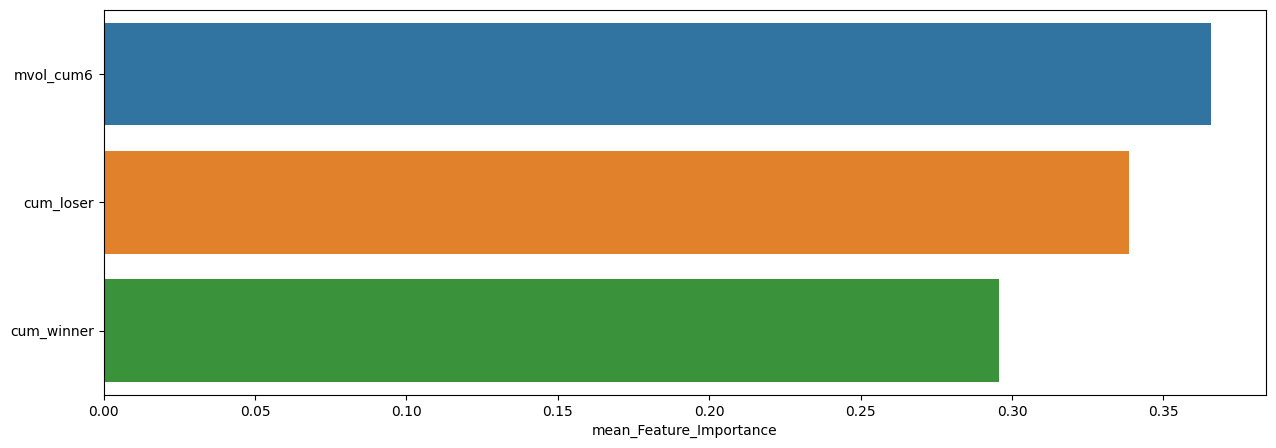

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.365621                0.420533   
cum_loser                  0.338738                0.404582   
cum_winner                 0.295641                0.336577   

            min_Feature_Importance  
mvol_cum6                 0.295532  
cum_loser                 0.284215  
cum_winner                0.257780


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.43      0.34      0.38        96
         1.0       0.58      0.67      0.62       132

    accuracy                           0.53       228
   macro avg       0.51      0.51      0.50       228
weighted avg       0.52      0.53      0.52       228


accuracy : 0.5307017543859649

precision : 0.5827814569536424

recall : 0.6666666666666666

F1-Score : 0.6219081272084805



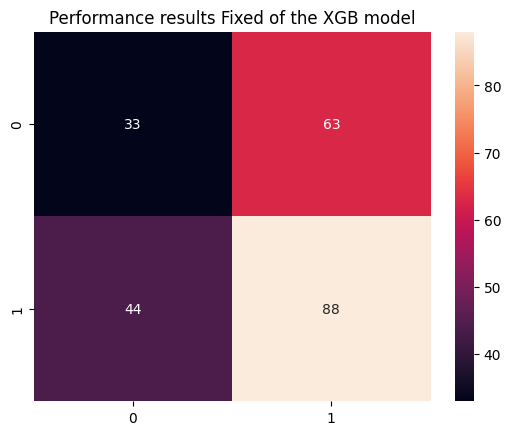


Feature Importance of the model



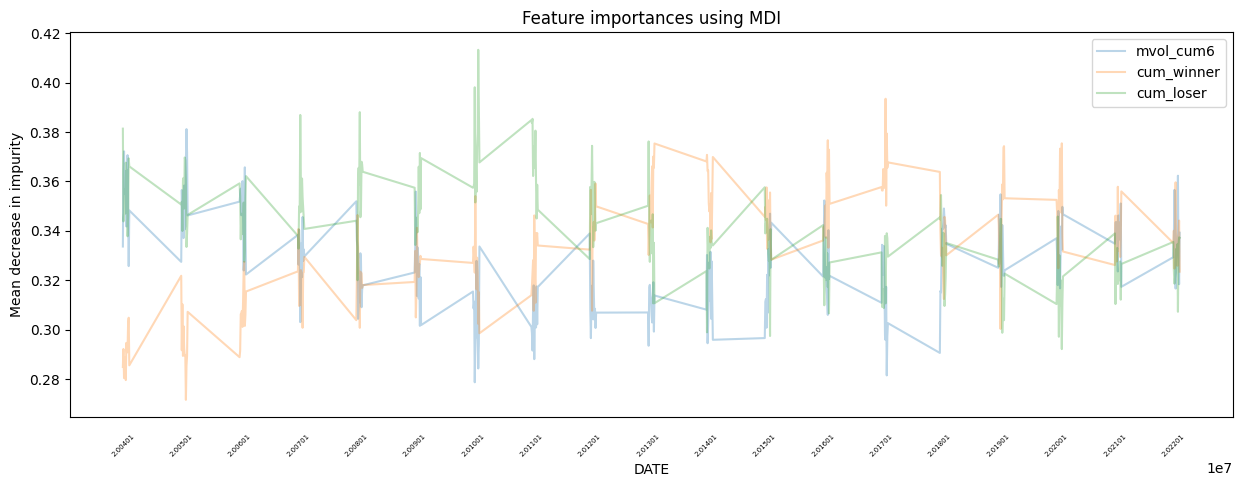

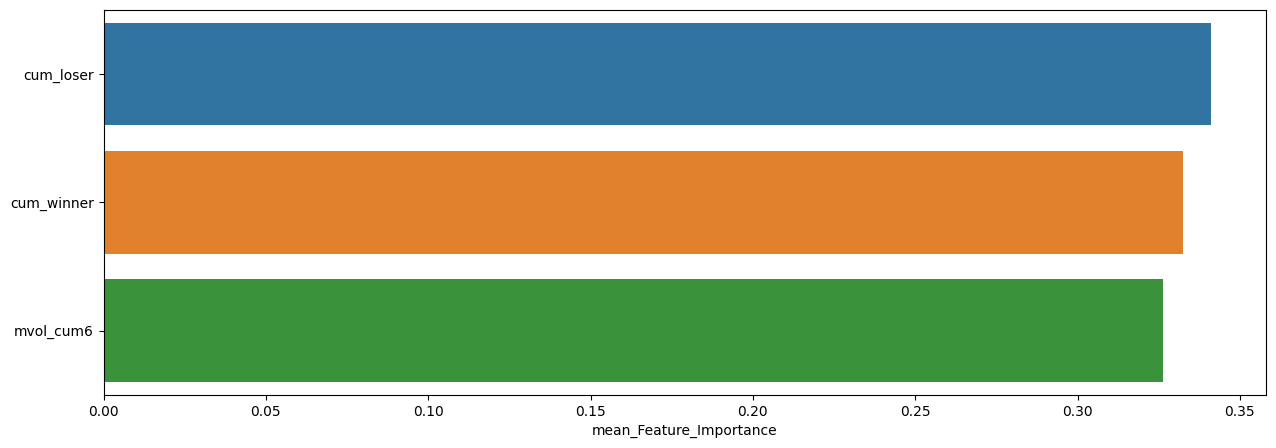

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                  0.341042                0.413285   
cum_winner                 0.332513                0.393486   
mvol_cum6                  0.326445                0.381198   

            min_Feature_Importance  
cum_loser                 0.292179  
cum_winner                0.271644  
mvol_cum6                 0.278749

In [36]:
slice_feature_importance(Fixed_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



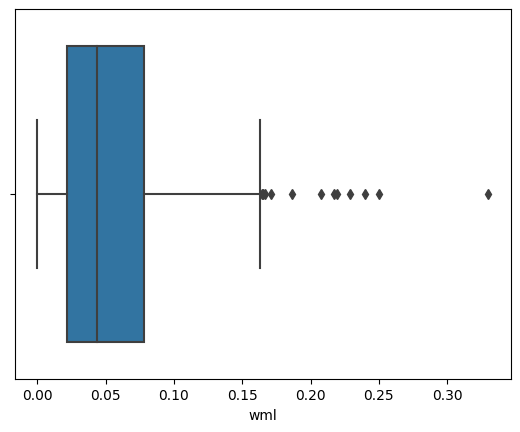

count      mean       std       min       25%      50%       75%  \
wml  412.0  0.054935  0.046778  0.000007  0.021416  0.04328  0.078287   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



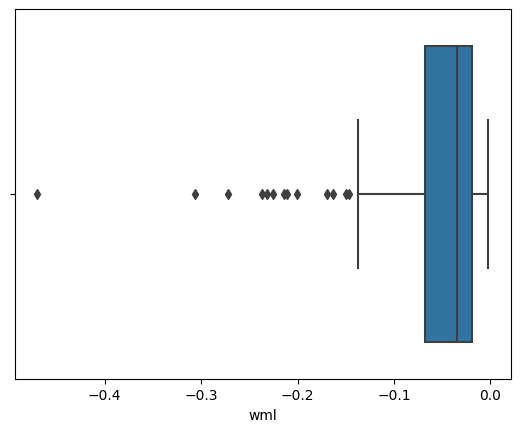

count      mean       std       min       25%       50%       75%  \
wml  105.0 -0.061521  0.075869 -0.469903 -0.067845 -0.034597 -0.019329   

          max  
wml -0.002043


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



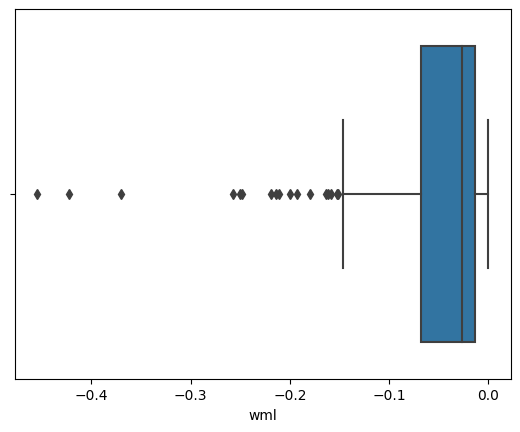

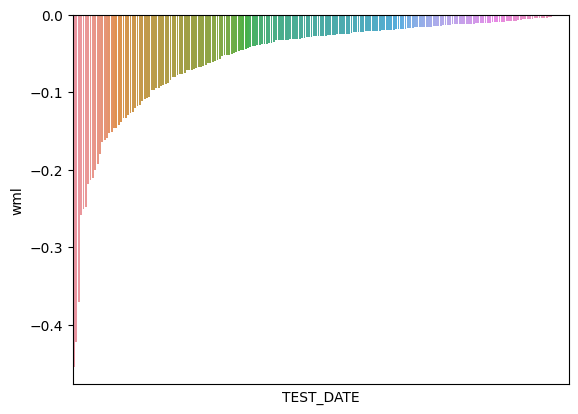

count      mean       std       min      25%       50%       75%  \
wml  211.0 -0.053718  0.068853 -0.454349 -0.06799 -0.027097 -0.013111   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



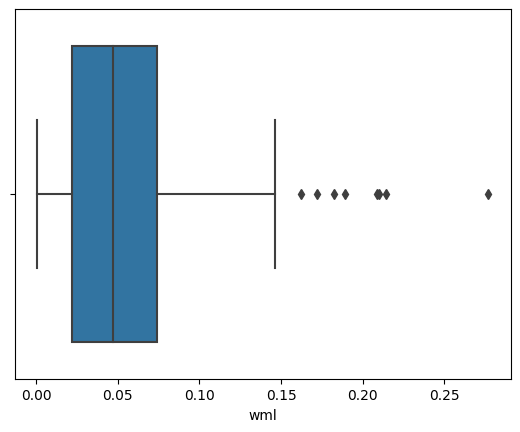

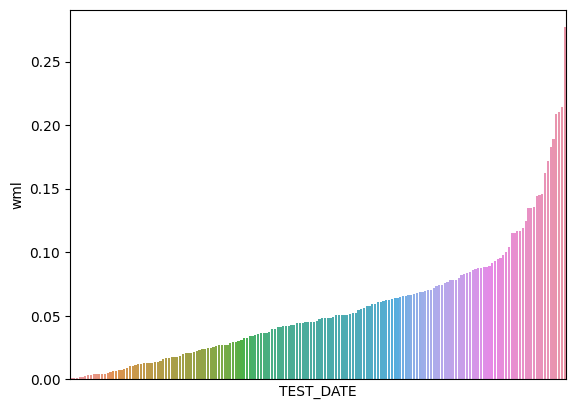

count      mean       std       min       25%       50%       75%  \
wml  178.0  0.055979  0.047012  0.000805  0.021976  0.046965  0.074314   

          max  
wml  0.276912

In [37]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Fixed_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.72408

최근 누적 수익률

  2022년-12월 -> 11331.31
  2022년-11월 -> 10209.21
  2022년-10월 -> 9711.07
  2022년-09월 -> 8598.91
  2022년-08월 -> 8598.91

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2001년-09월 -> 23647.73
  2등 : 2002년-06월 -> 21482.38
  3등 : 2002년-07월 -> 21482.38
  4등 : 2002년-08월 -> 20859.99
  5등 : 2002년-09월 -> 20859.99
  6등 : 2001년-08월 -> 19585.99
  7등 : 2002년-05월 -> 18472.20
  8등 : 2002년-04월 -> 18472.20
  9등 : 2002년-03월 -> 18472.20
  10등 : 2002년-02월 -> 18472.20



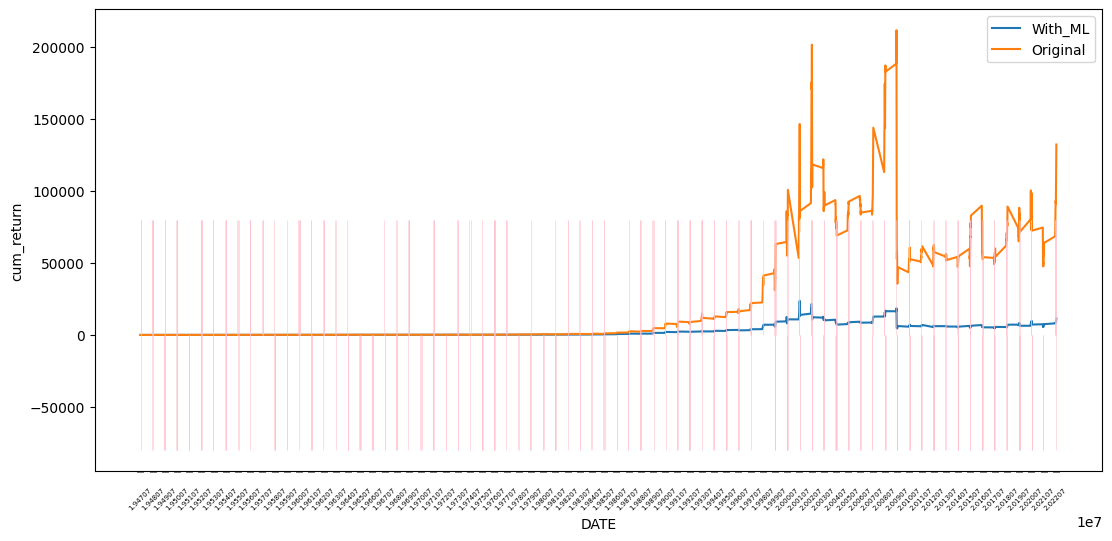

In [38]:
XGB_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.71916

최근 누적 수익률

  2022년-12월 -> 18071.79
  2022년-11월 -> 16289.66
  2022년-10월 -> 15613.00
  2022년-09월 -> 13932.19
  2022년-08월 -> 13482.79

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 18071.79
  2등 : 2009년-02월 -> 17541.07
  3등 : 2002년-07월 -> 17426.18
  4등 : 2002년-06월 -> 17384.34
  5등 : 2002년-09월 -> 17137.88
  6등 : 2002년-08월 -> 16994.13
  7등 : 2008년-11월 -> 16356.64
  8등 : 2022년-11월 -> 16289.66
  9등 : 2009년-01월 -> 16183.74
  10등 : 2008년-12월 -> 16005.16



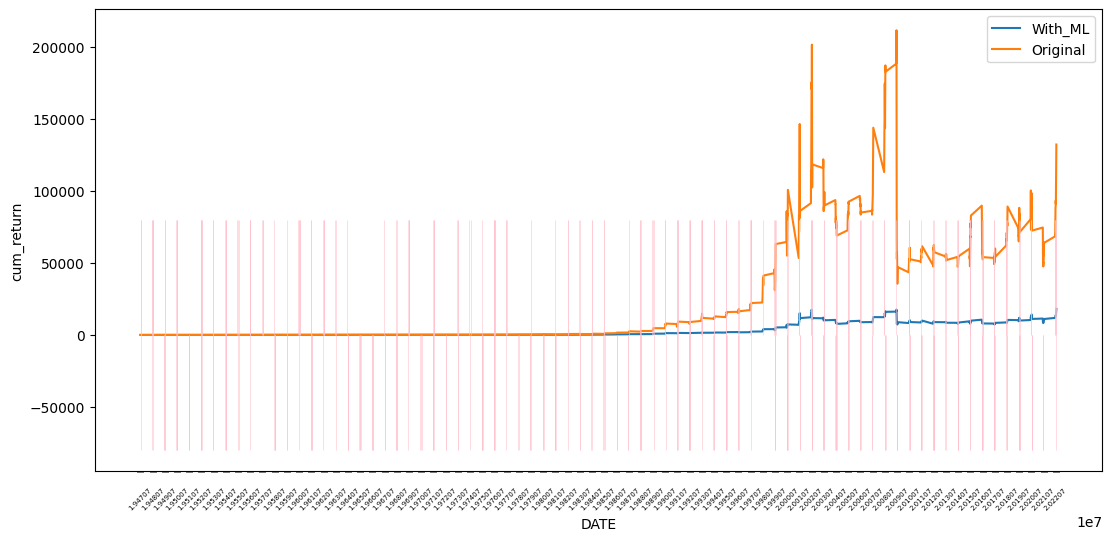

In [39]:
XGB_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [40]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.33      0.35       316
         1.0       0.66      0.70      0.68       590

    accuracy                           0.57       906
   macro avg       0.52      0.51      0.51       906
weighted avg       0.56      0.57      0.56       906


accuracy : 0.5717439293598234

precision : 0.660828025477707

recall : 0.7033898305084746

F1-Score : 0.6814449917898194



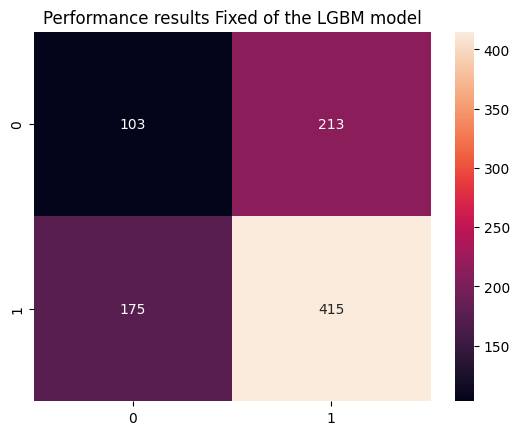


Feature Importance of the model



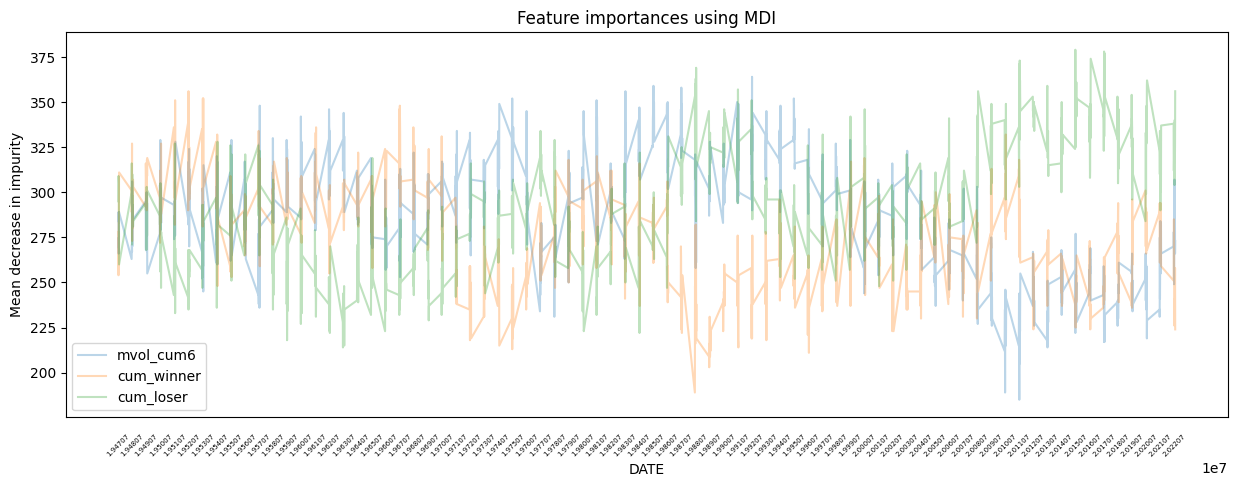

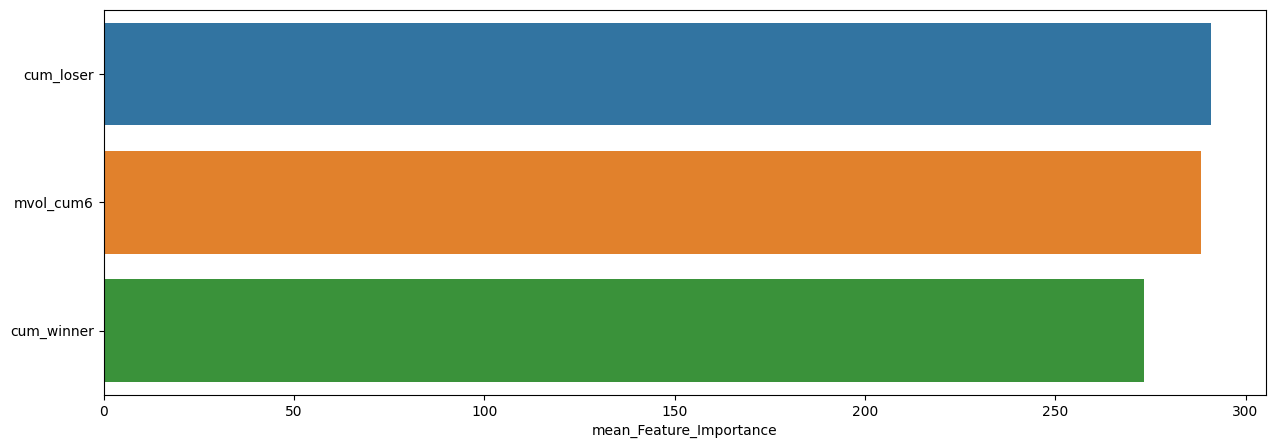

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                290.853201                     379   
mvol_cum6                288.169978                     364   
cum_winner               273.322296                     356   

            min_Feature_Importance  
cum_loser                      214  
mvol_cum6                      185  
cum_winner                     189

In [41]:
Fixed_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.35      0.34        75
         1.0       0.67      0.66      0.66       151

    accuracy                           0.55       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.56      0.55      0.56       226


accuracy : 0.5530973451327433

precision : 0.668918918918919

recall : 0.6556291390728477

F1-Score : 0.6622073578595319



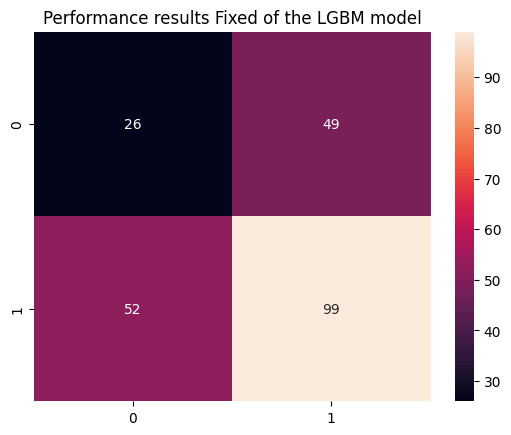


Feature Importance of the model



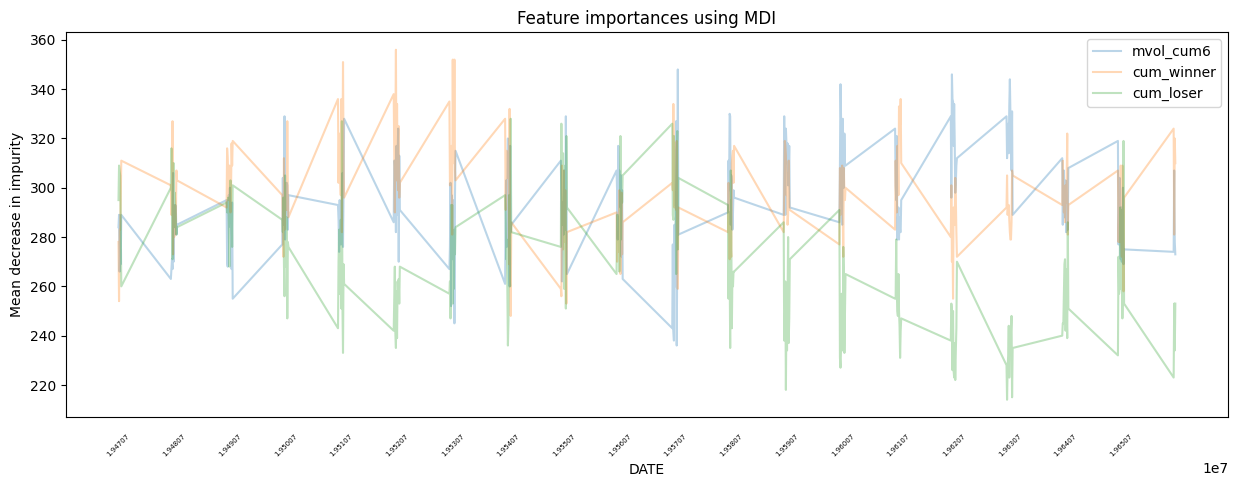

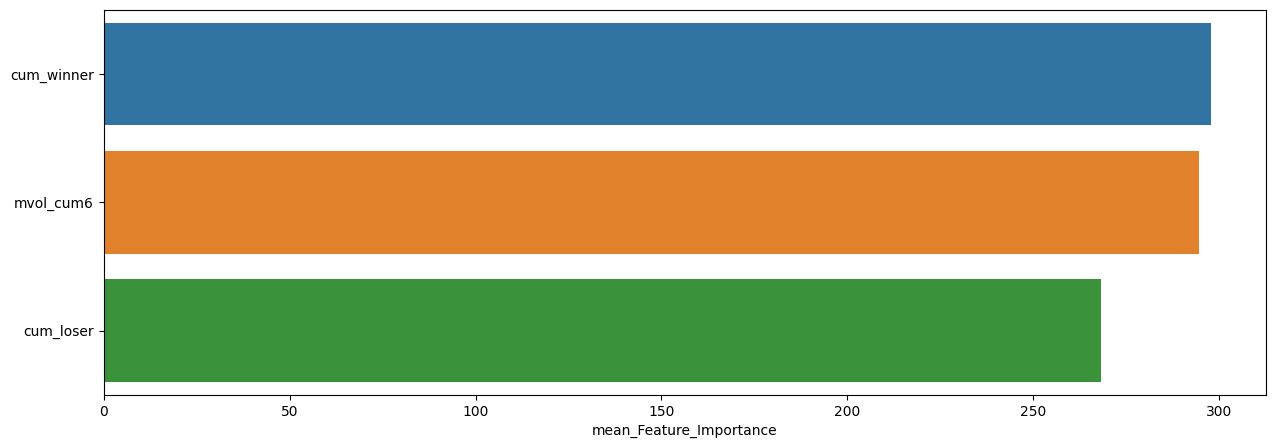

mean_Feature_Importance  max_Feature_Importance  \
cum_winner               297.690265                     356   
mvol_cum6                294.530973                     348   
cum_loser                268.252212                     328   

            min_Feature_Importance  
cum_winner                     248  
mvol_cum6                      236  
cum_loser                      214


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.42      0.29      0.34        75
         1.0       0.69      0.79      0.74       151

    accuracy                           0.63       226
   macro avg       0.55      0.54      0.54       226
weighted avg       0.60      0.63      0.61       226


accuracy : 0.6283185840707964

precision : 0.6936416184971098

recall : 0.7947019867549668

F1-Score : 0.7407407407407407



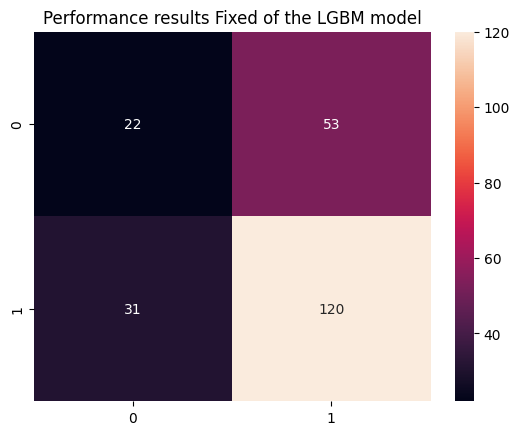


Feature Importance of the model



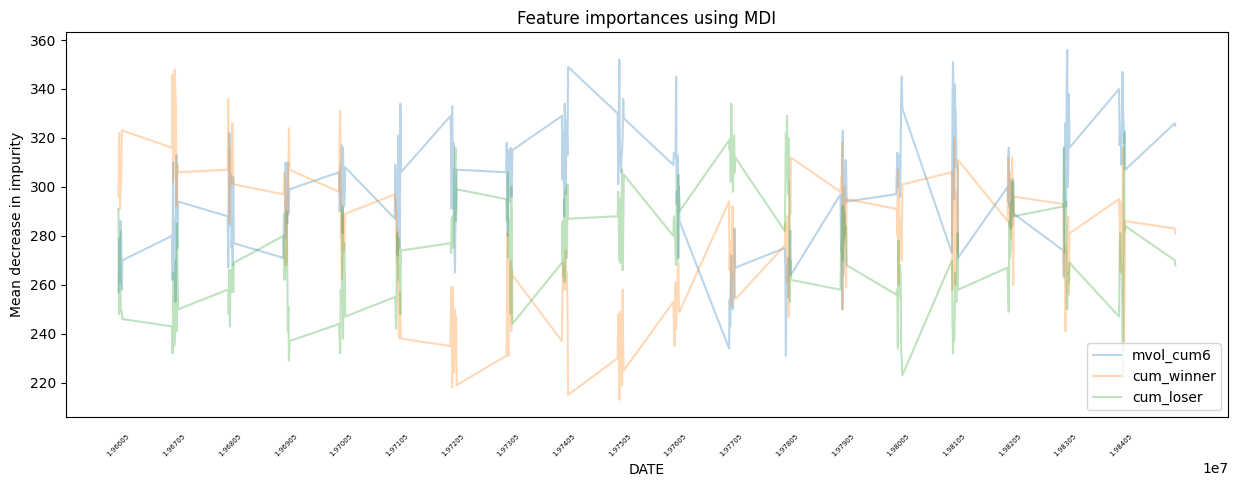

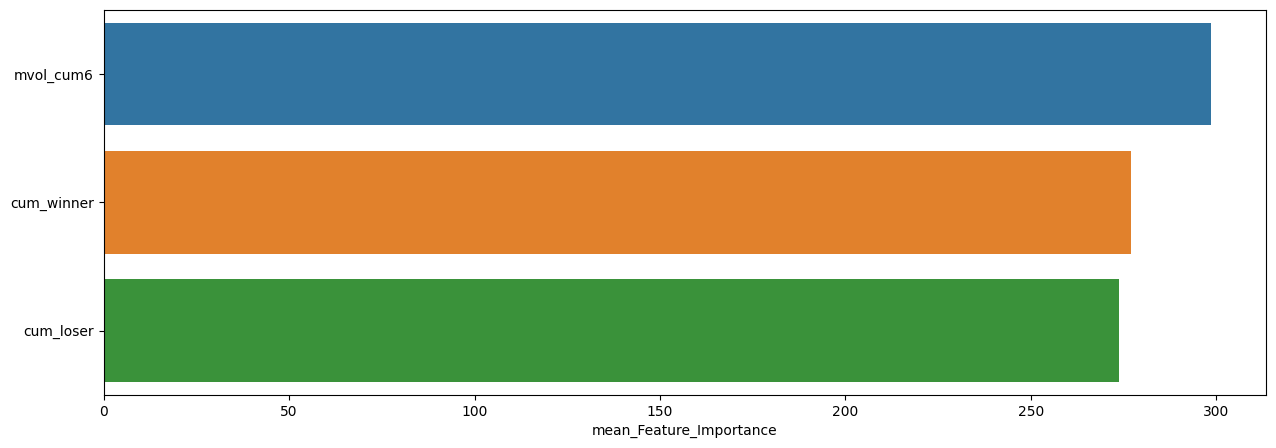

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                298.469027                     356   
cum_winner               277.084071                     348   
cum_loser                273.774336                     334   

            min_Feature_Importance  
mvol_cum6                      231  
cum_winner                     213  
cum_loser                      222


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.29      0.31        70
         1.0       0.70      0.76      0.73       156

    accuracy                           0.61       226
   macro avg       0.52      0.52      0.52       226
weighted avg       0.59      0.61      0.60       226


accuracy : 0.6106194690265486

precision : 0.7023809523809523

recall : 0.7564102564102564

F1-Score : 0.728395061728395



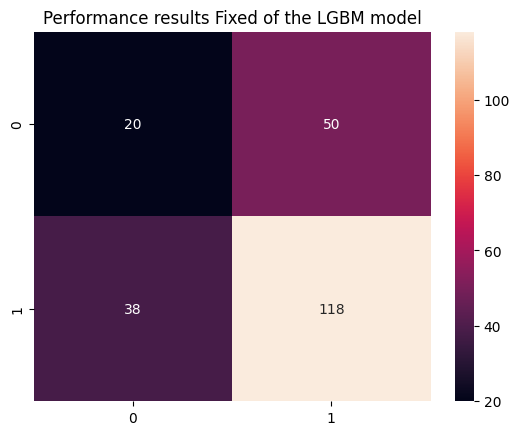


Feature Importance of the model



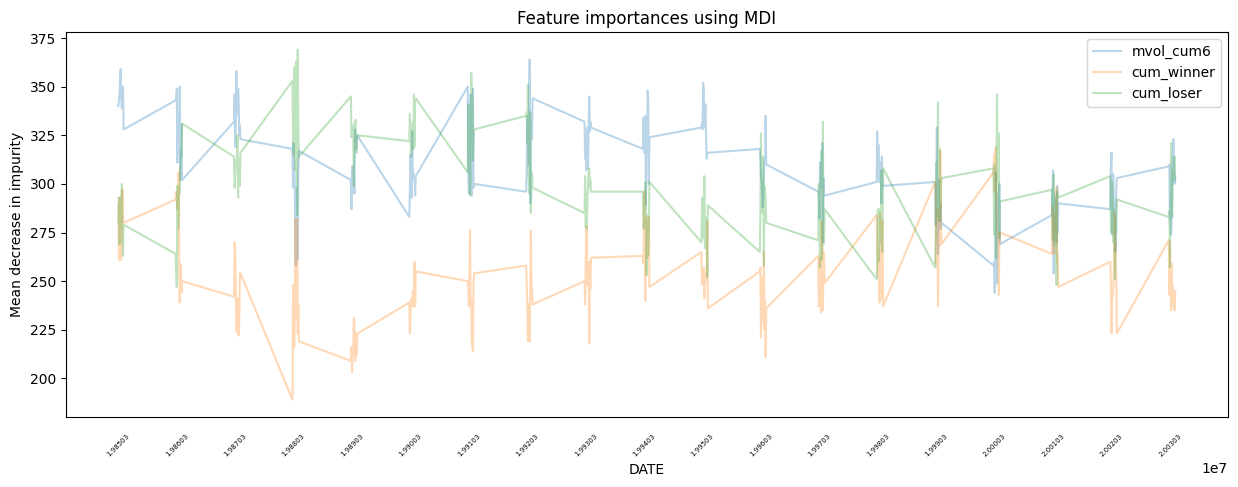

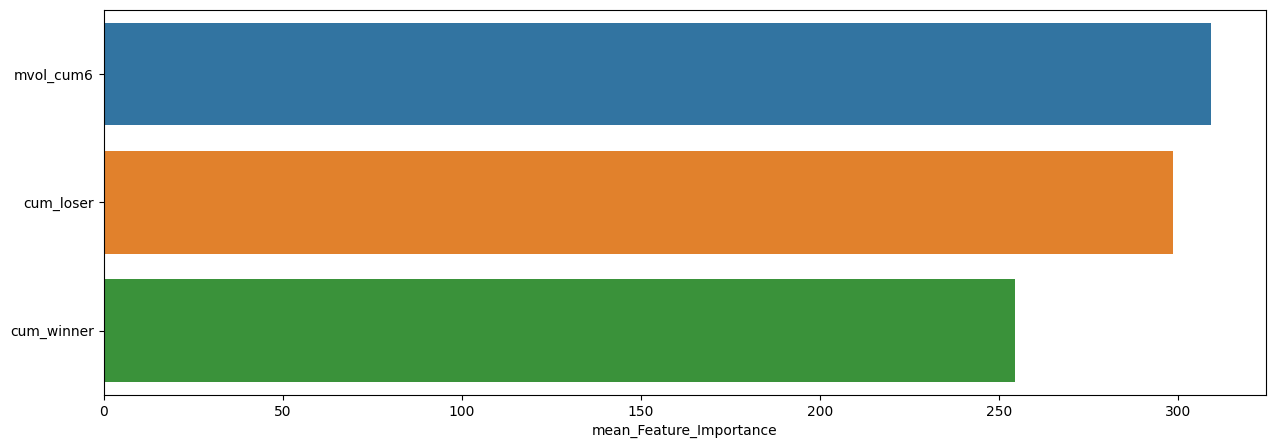

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                309.026549                     364   
cum_loser                298.376106                     369   
cum_winner               254.393805                     319   

            min_Feature_Importance  
mvol_cum6                      244  
cum_loser                      247  
cum_winner                     189


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.36      0.38        96
         1.0       0.56      0.59      0.58       132

    accuracy                           0.50       228
   macro avg       0.48      0.48      0.48       228
weighted avg       0.49      0.50      0.49       228


accuracy : 0.4956140350877193

precision : 0.5611510791366906

recall : 0.5909090909090909

F1-Score : 0.5756457564575646



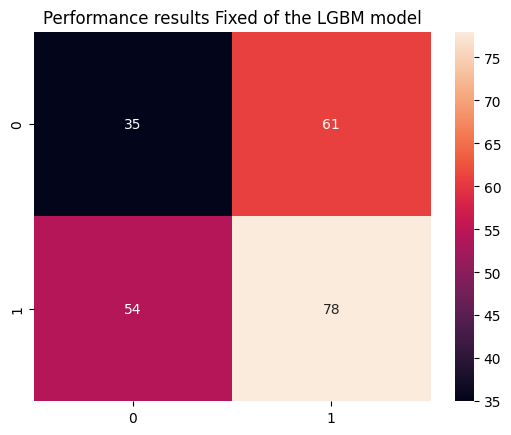


Feature Importance of the model



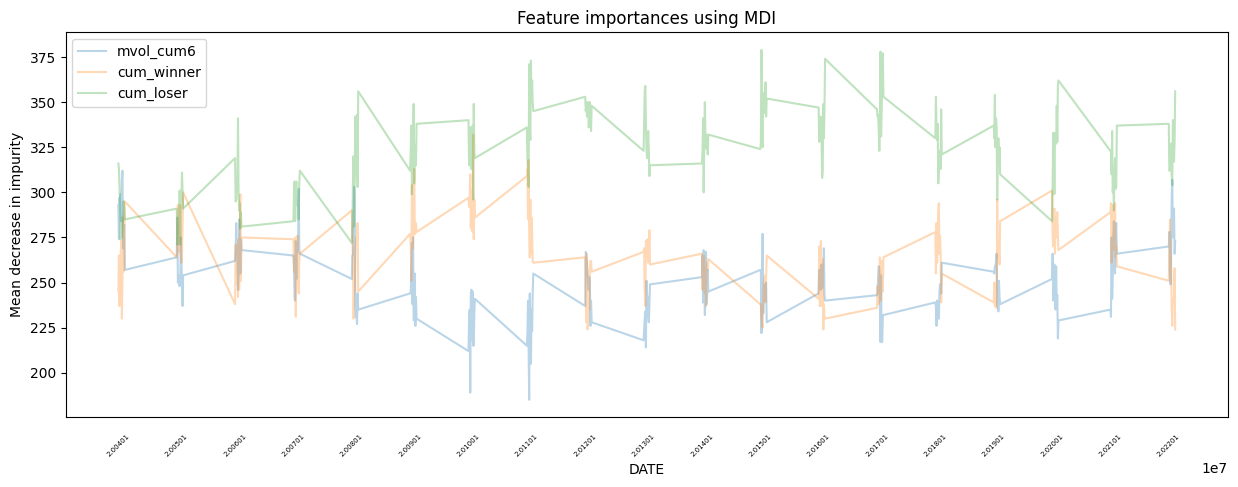

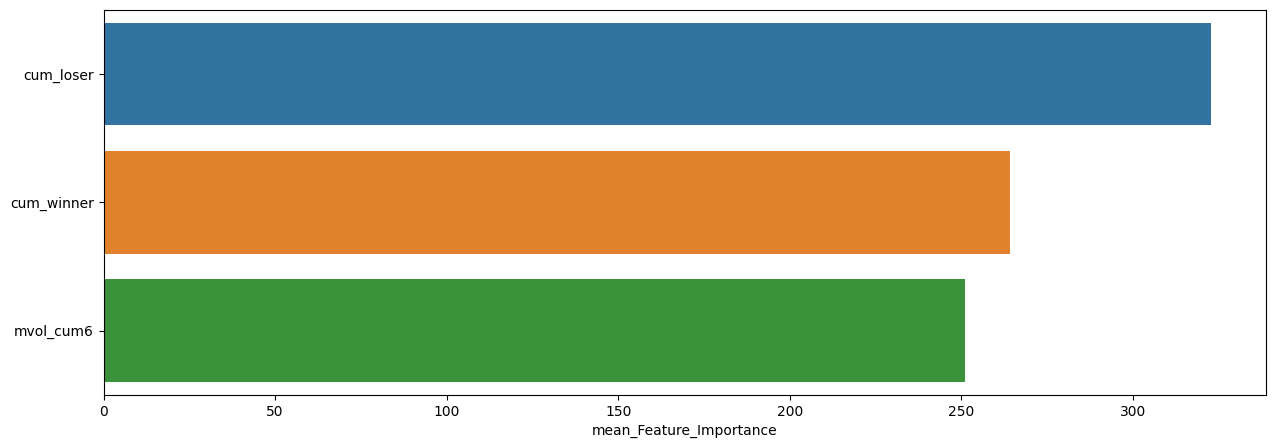

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                322.728070                     379   
cum_winner               264.201754                     332   
mvol_cum6                250.982456                     312   

            min_Feature_Importance  
cum_loser                      271  
cum_winner                     224  
mvol_cum6                      185

In [42]:
slice_feature_importance(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Fixed', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



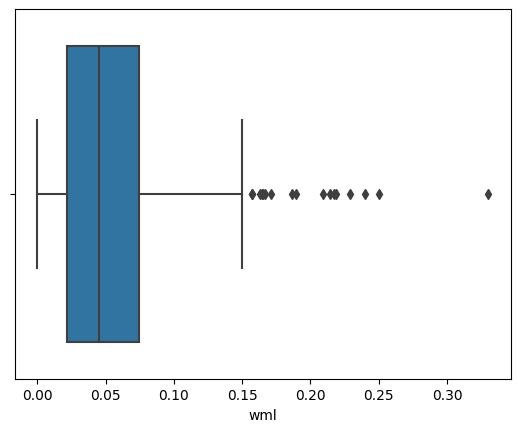

count      mean       std       min       25%      50%       75%  \
wml  415.0  0.055452  0.047258  0.000128  0.022028  0.04498  0.074273   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



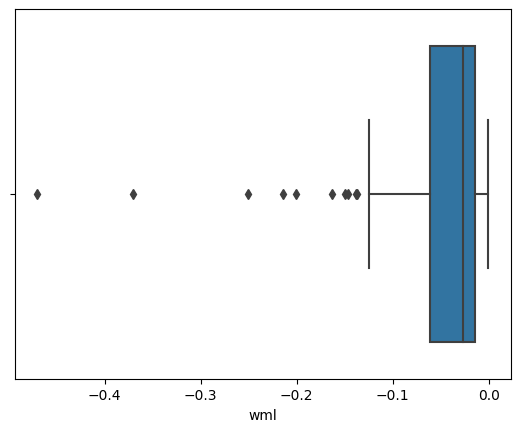

count      mean       std       min       25%       50%       75%  \
wml  103.0 -0.051855  0.070543 -0.469903 -0.061227 -0.027259 -0.014057   

          max  
wml -0.000506


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



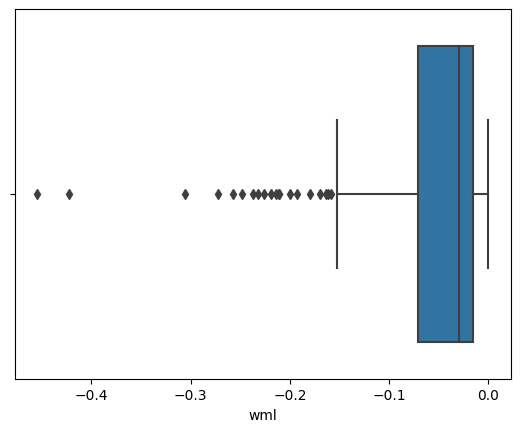

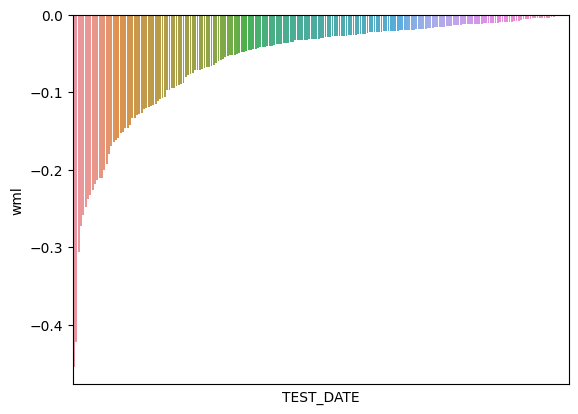

count      mean       std       min       25%       50%       75%  \
wml  213.0 -0.058466  0.071633 -0.454349 -0.070963 -0.029816 -0.015103   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



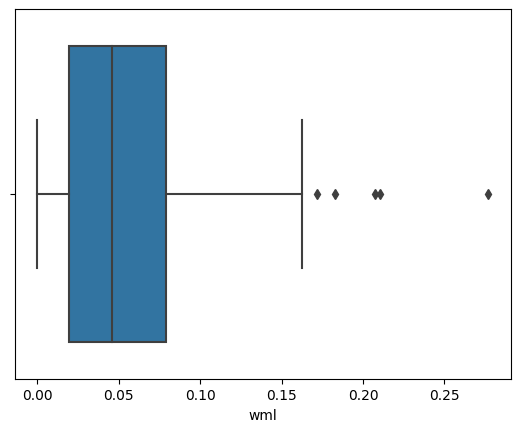

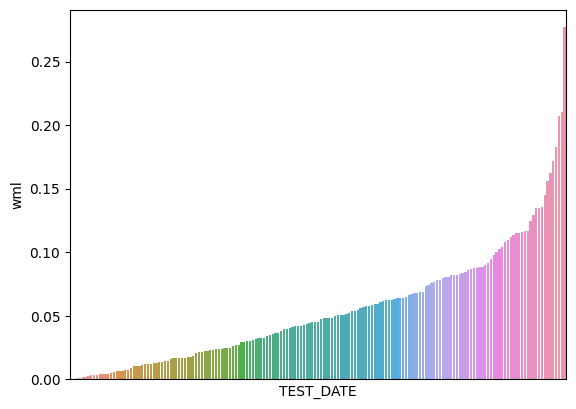

count     mean       std       min       25%       50%       75%  \
wml  175.0  0.05477  0.045865  0.000007  0.019533  0.045577  0.078886   

          max  
wml  0.276912

In [43]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Fixed_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.63514

최근 누적 수익률

  2022년-12월 -> 4690.04
  2022년-11월 -> 4225.55
  2022년-10월 -> 4019.34
  2022년-09월 -> 4019.34
  2022년-08월 -> 4019.34

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 19191.90
  2등 : 2009년-01월 -> 17089.00
  3등 : 2008년-11월 -> 16977.53
  4등 : 2008년-12월 -> 16575.66
  5등 : 2002년-06월 -> 16016.54
  6등 : 2002년-07월 -> 16016.54
  7등 : 2008년-06월 -> 15829.87
  8등 : 2002년-09월 -> 15552.49
  9등 : 2002년-08월 -> 15552.49
  10등 : 2008년-10월 -> 15482.00



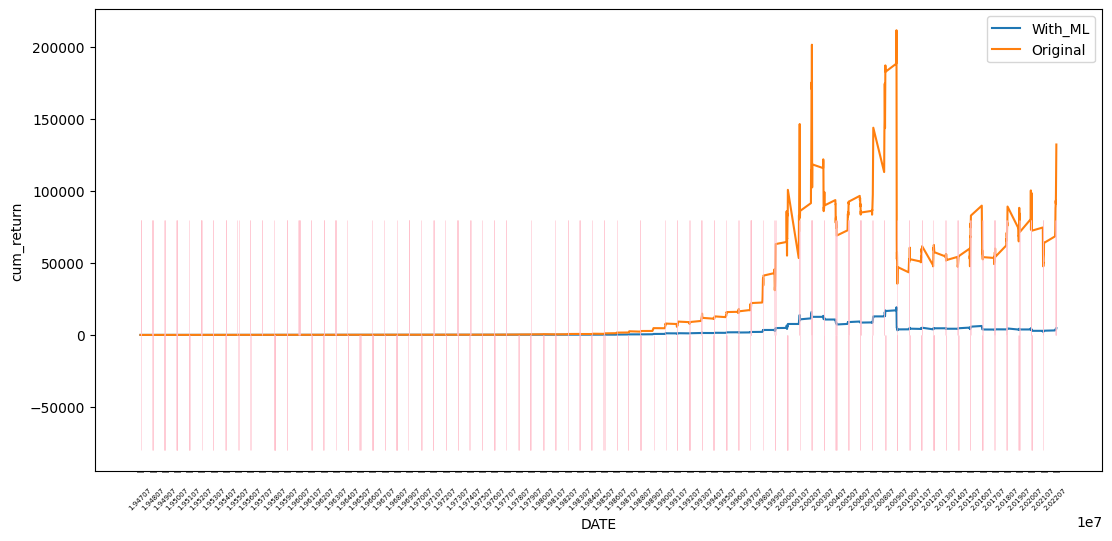

In [44]:
LGBM_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.73221

최근 누적 수익률

  2022년-12월 -> 7367.44
  2022년-11월 -> 6768.87
  2022년-10월 -> 6556.97
  2022년-09월 -> 6216.32
  2022년-08월 -> 6002.51

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 11070.14
  2등 : 2009년-01월 -> 10176.93
  3등 : 2008년-11월 -> 10173.61
  4등 : 2008년-12월 -> 9973.43
  5등 : 2008년-10월 -> 9468.73
  6등 : 2008년-06월 -> 9409.33
  7등 : 2002년-09월 -> 9357.39
  8등 : 2008년-09월 -> 9047.16
  9등 : 2002년-07월 -> 8960.38
  10등 : 2002년-06월 -> 8824.51



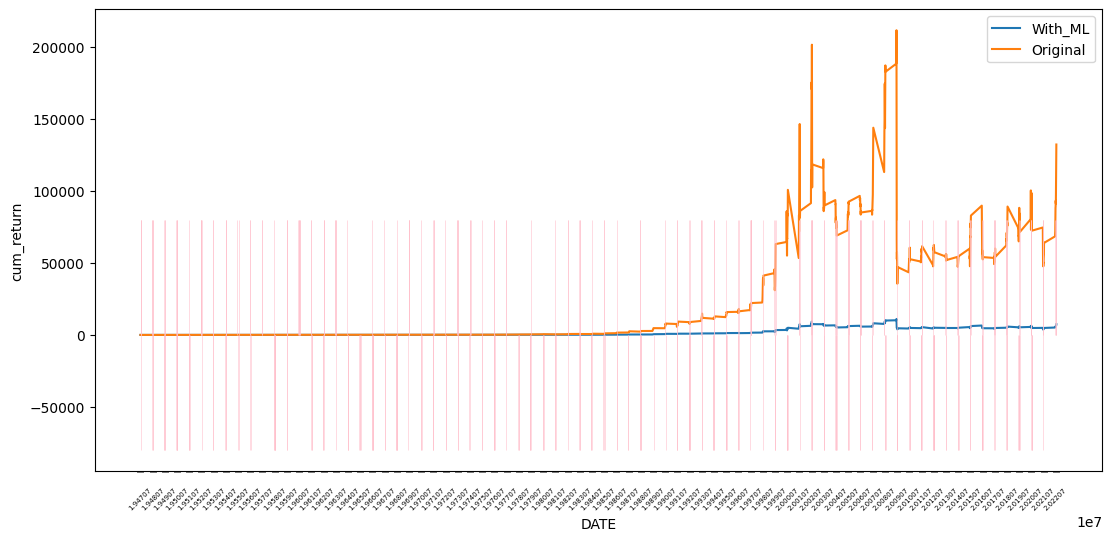

In [45]:
LGBM_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

## Rolling Expanding Windows

### Random Forest

In [46]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.24      0.29       316
         1.0       0.66      0.78      0.71       590

    accuracy                           0.59       906
   macro avg       0.51      0.51      0.50       906
weighted avg       0.56      0.59      0.57       906


accuracy : 0.5916114790286976

precision : 0.6575931232091691

recall : 0.7779661016949152

F1-Score : 0.7127329192546584



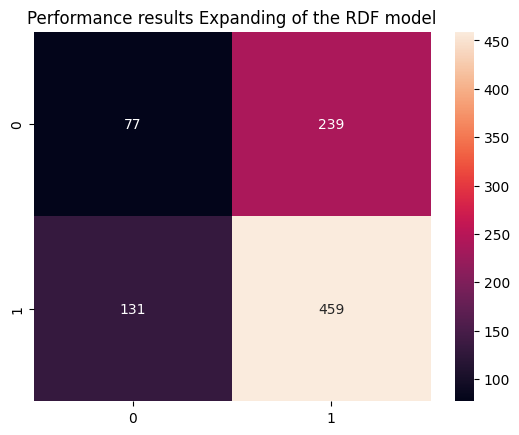


Feature Importance of the model



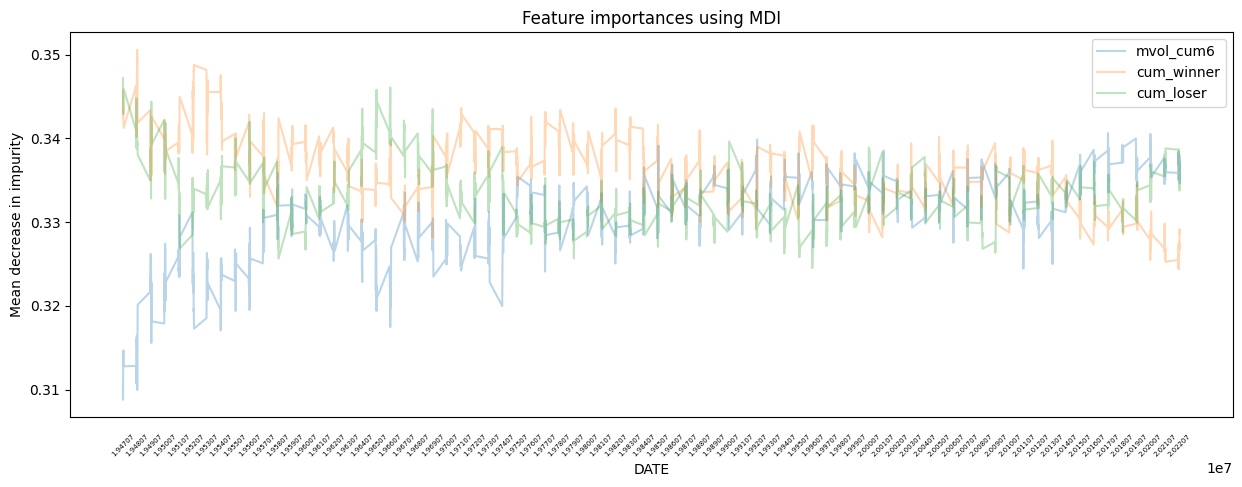

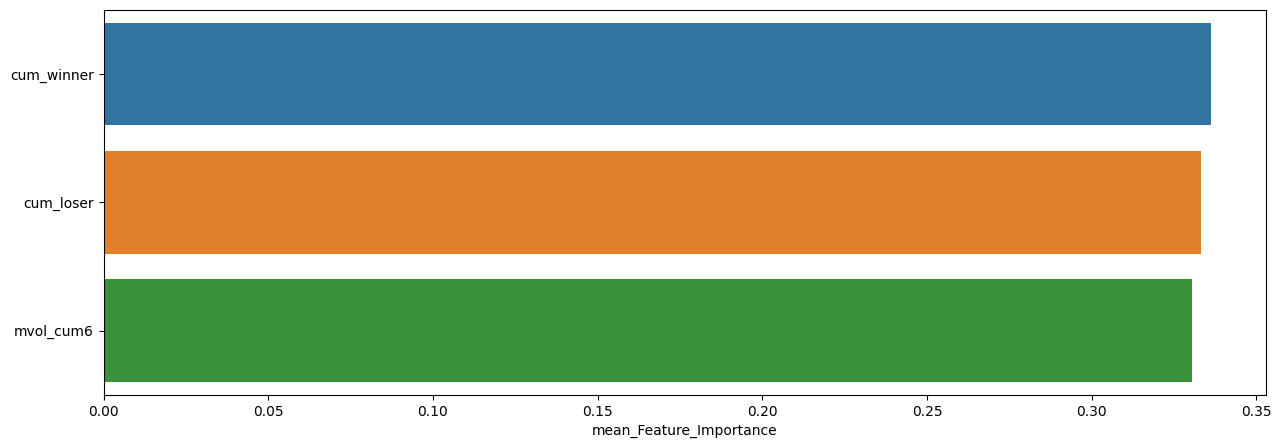

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.336165                0.350579   
cum_loser                  0.333223                0.347189   
mvol_cum6                  0.330612                0.340633   

            min_Feature_Importance  
cum_winner                0.324405  
cum_loser                 0.324507  
mvol_cum6                 0.308782

In [47]:
Expanding_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=RDF, # 사용할 모델
                                      model_name='RDF', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.29      0.33        75
         1.0       0.68      0.76      0.72       151

    accuracy                           0.61       226
   macro avg       0.53      0.53      0.53       226
weighted avg       0.58      0.61      0.59       226


accuracy : 0.6061946902654868

precision : 0.6845238095238095

recall : 0.7615894039735099

F1-Score : 0.7210031347962382



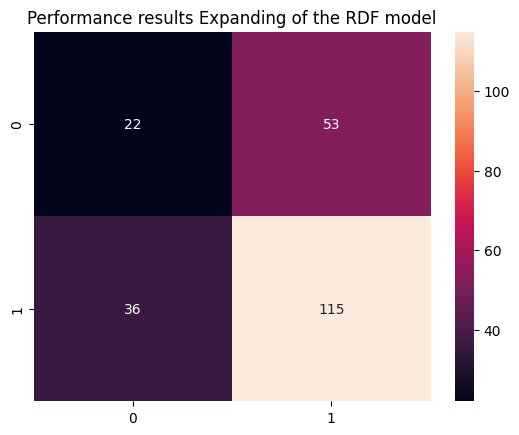


Feature Importance of the model



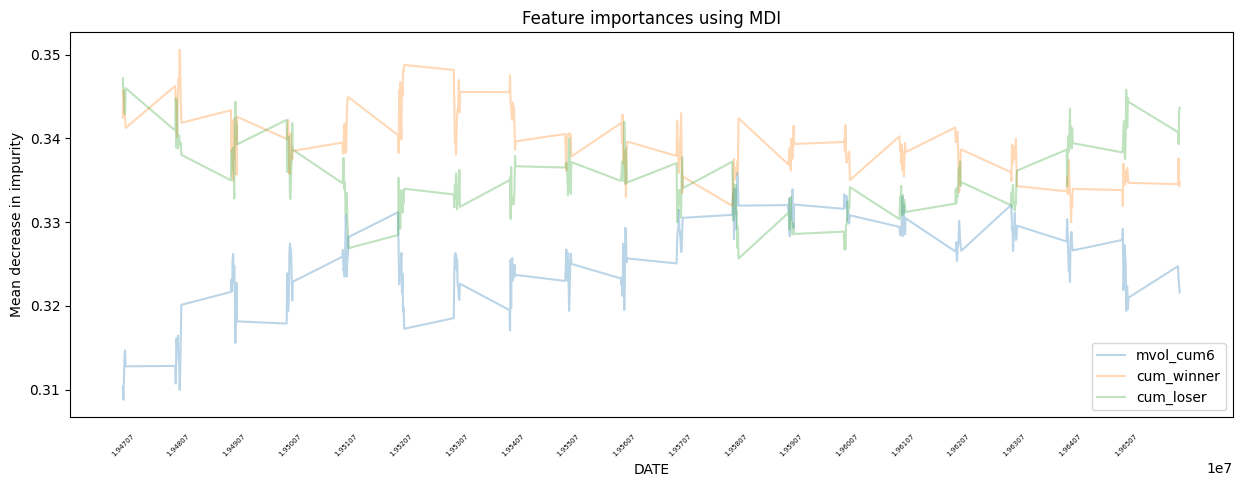

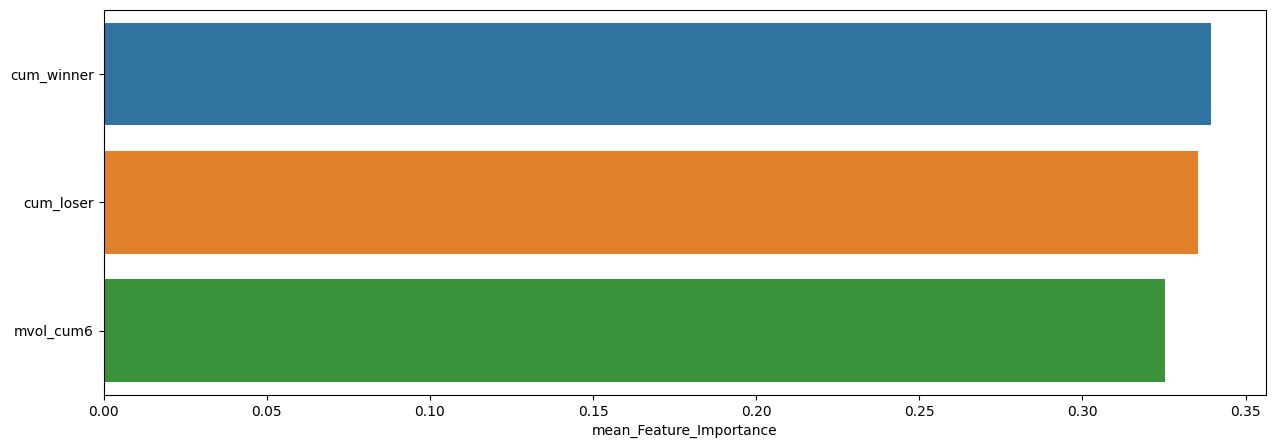

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.339327                0.350579   
cum_loser                  0.335278                0.347189   
mvol_cum6                  0.325395                0.335855   

            min_Feature_Importance  
cum_winner                0.329986  
cum_loser                 0.325634  
mvol_cum6                 0.308782


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.43      0.24      0.31        75
         1.0       0.69      0.84      0.76       151

    accuracy                           0.64       226
   macro avg       0.56      0.54      0.53       226
weighted avg       0.60      0.64      0.61       226


accuracy : 0.6415929203539823

precision : 0.6902173913043478

recall : 0.8410596026490066

F1-Score : 0.7582089552238807



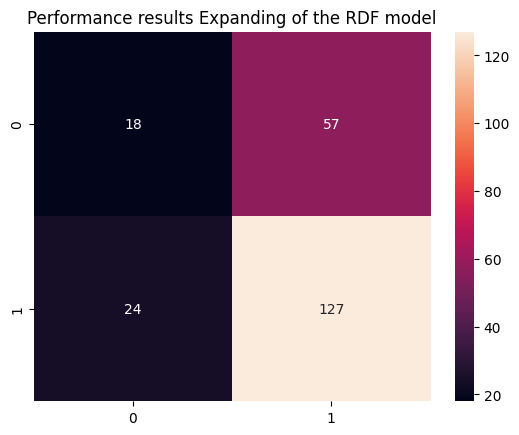


Feature Importance of the model



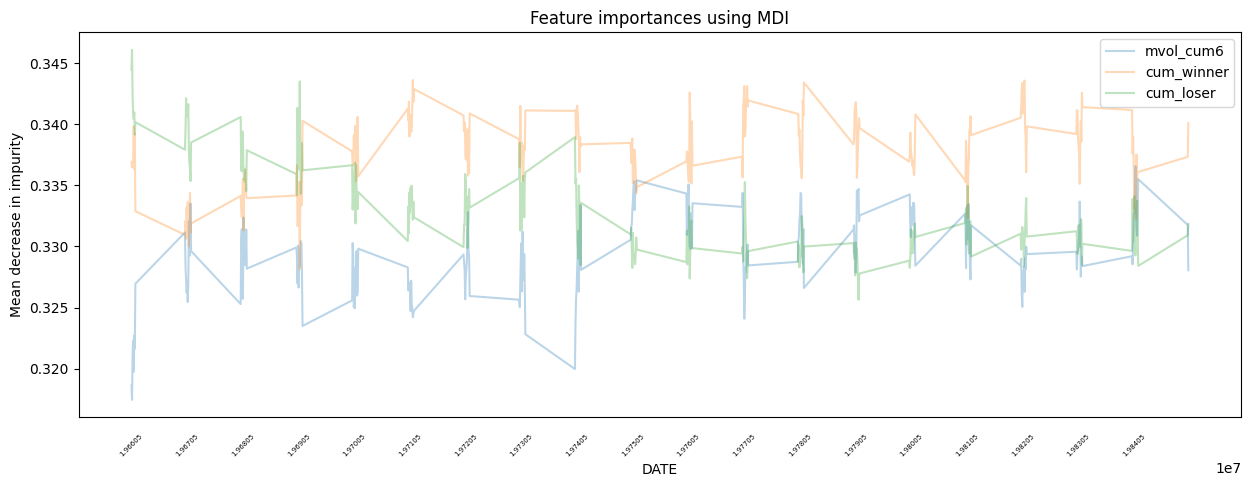

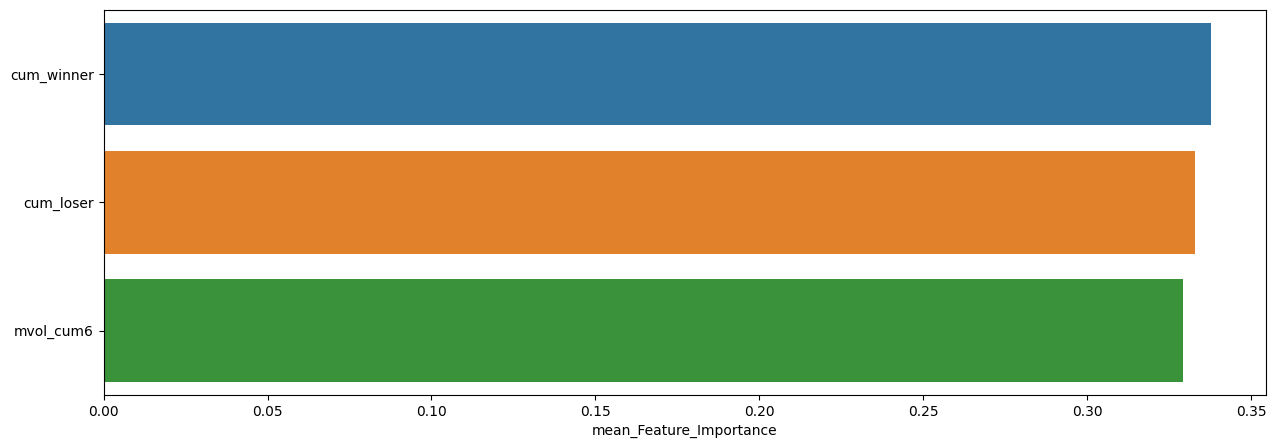

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.337737                0.343602   
cum_loser                  0.332846                0.346077   
mvol_cum6                  0.329417                0.336553   

            min_Feature_Importance  
cum_winner                0.328136  
cum_loser                 0.325642  
mvol_cum6                 0.317459


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.19      0.23        70
         1.0       0.69      0.80      0.74       156

    accuracy                           0.61       226
   macro avg       0.49      0.49      0.48       226
weighted avg       0.57      0.61      0.58       226


accuracy : 0.6106194690265486

precision : 0.6868131868131868

recall : 0.8012820512820513

F1-Score : 0.7396449704142012



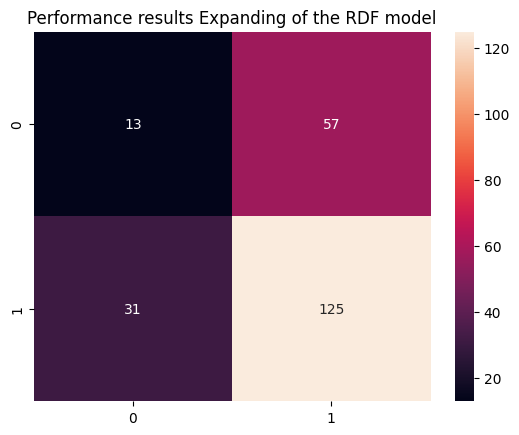


Feature Importance of the model



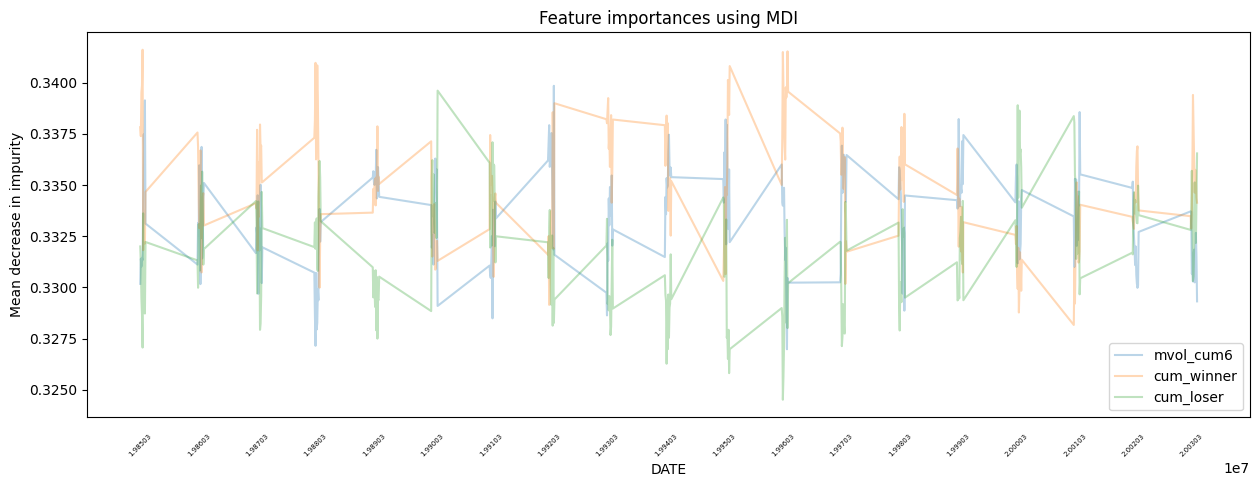

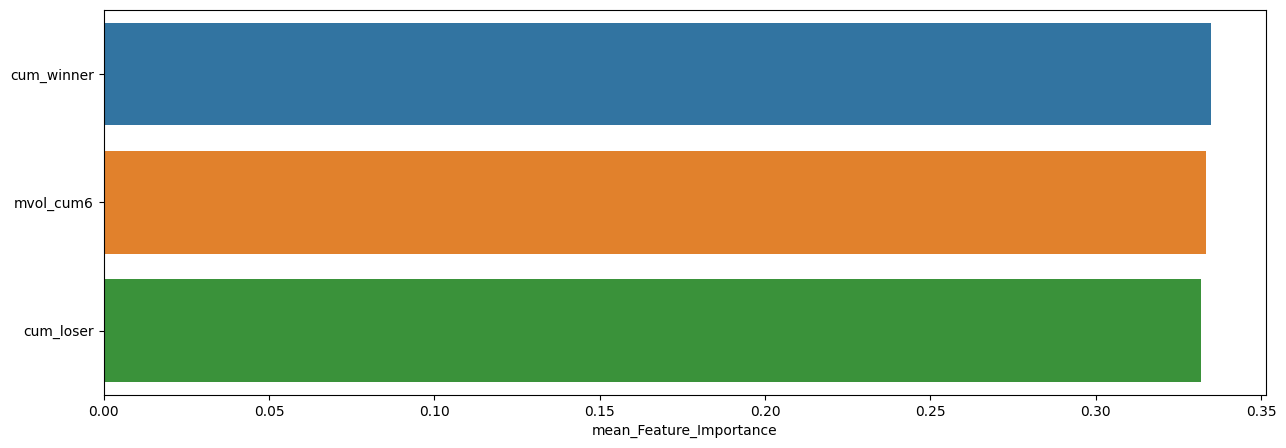

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.334797                0.341613   
mvol_cum6                  0.333474                0.339850   
cum_loser                  0.331728                0.339614   

            min_Feature_Importance  
cum_winner                0.328162  
mvol_cum6                 0.326975  
cum_loser                 0.324507


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.25      0.30        96
         1.0       0.56      0.70      0.62       132

    accuracy                           0.51       228
   macro avg       0.47      0.47      0.46       228
weighted avg       0.48      0.51      0.49       228


accuracy : 0.5087719298245614

precision : 0.5609756097560976

recall : 0.696969696969697

F1-Score : 0.6216216216216217



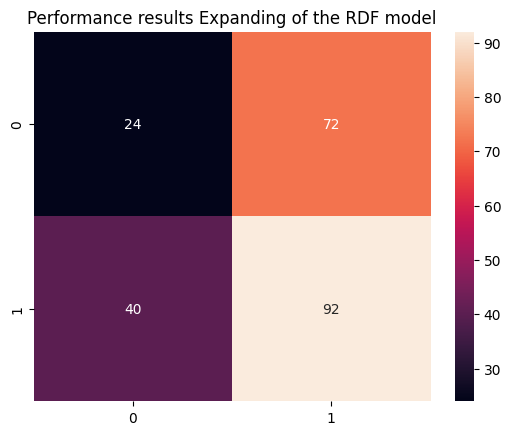


Feature Importance of the model



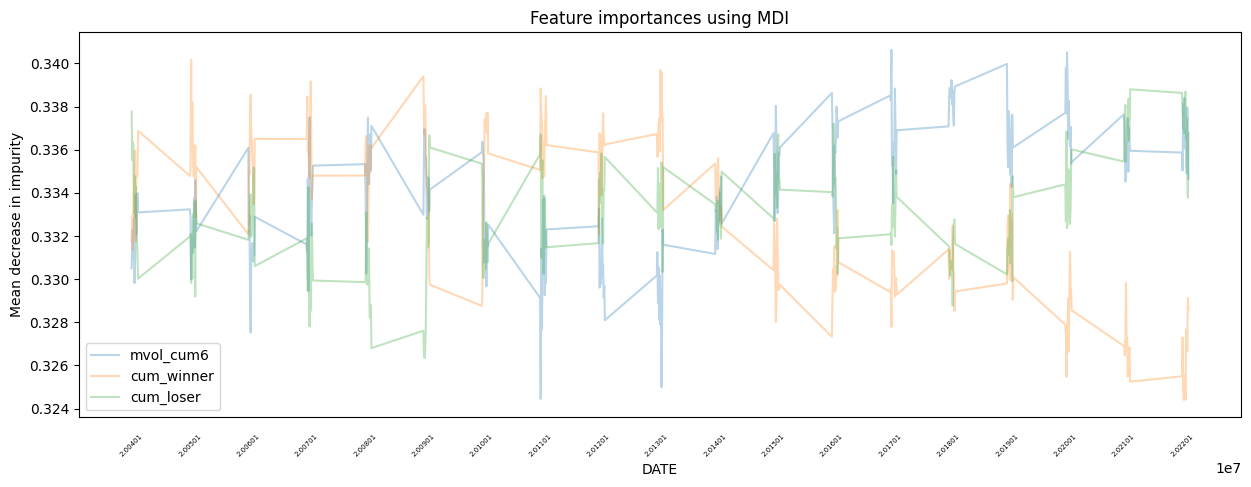

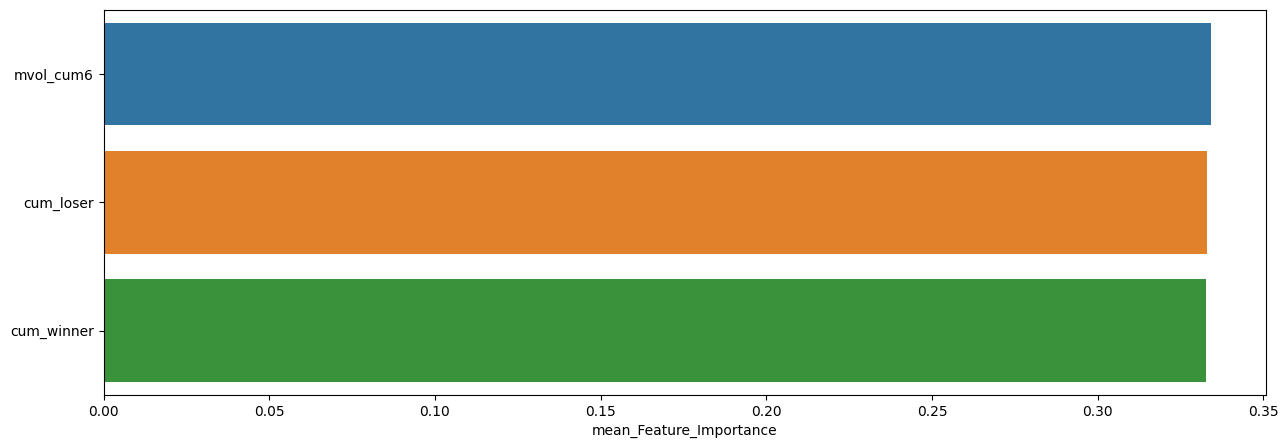

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.334131                0.340633   
cum_loser                  0.333042                0.338802   
cum_winner                 0.332827                0.340182   

            min_Feature_Importance  
mvol_cum6                 0.324451  
cum_loser                 0.326343  
cum_winner                0.324405

In [48]:
slice_feature_importance(Expanding_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



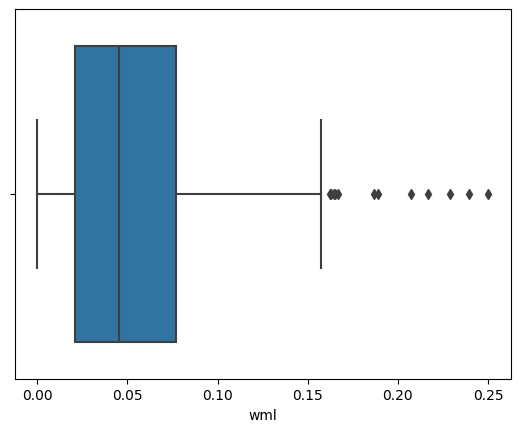

count      mean      std       min       25%       50%       75%  \
wml  459.0  0.053986  0.04339  0.000128  0.021107  0.045201  0.076866   

          max  
wml  0.250175


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



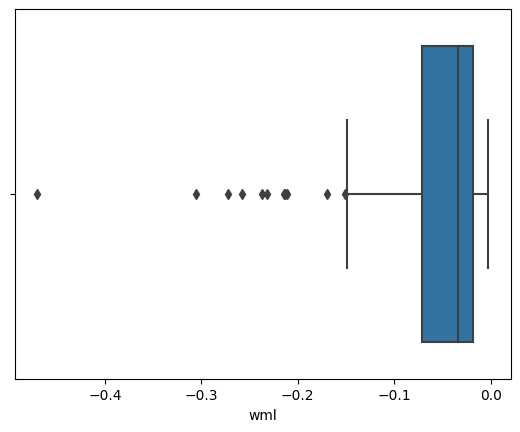

count      mean       std       min       25%       50%       75%  \
wml   77.0 -0.069382  0.085768 -0.469903 -0.070963 -0.033843 -0.018584   

         max  
wml -0.00241


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



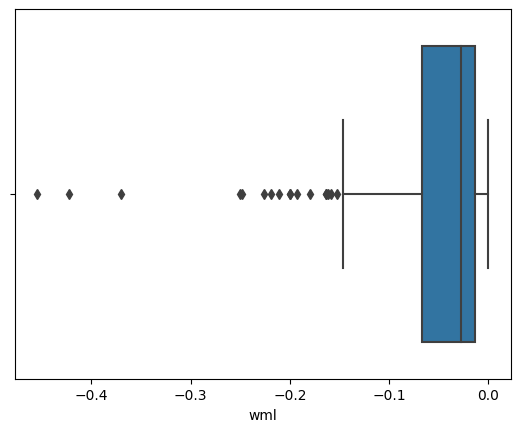

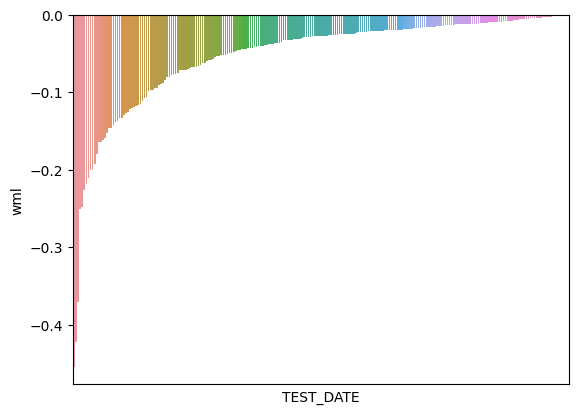

count    mean       std       min       25%       50%       75%       max
wml  239.0 -0.0521  0.065529 -0.454349 -0.067054 -0.027234 -0.013685 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



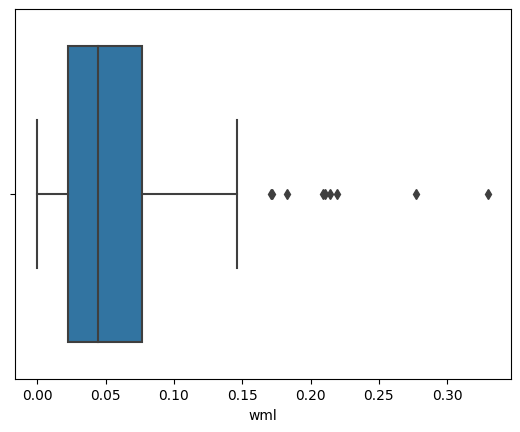

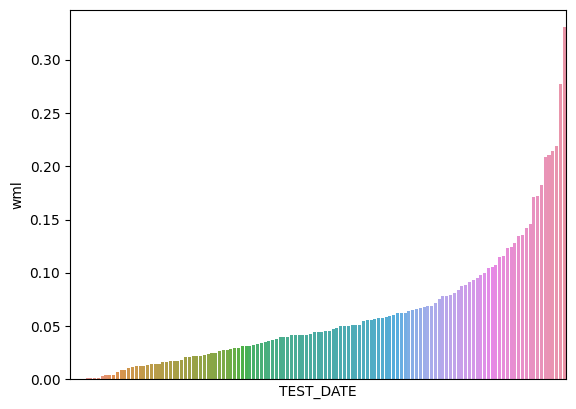

count      mean       std       min       25%       50%       75%  \
wml  131.0  0.059677  0.057183  0.000007  0.022064  0.044468  0.076776   

          max  
wml  0.330163

In [49]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Expanding_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.71194

최근 누적 수익률

  2022년-12월 -> 29632.63
  2022년-11월 -> 26698.38
  2022년-10월 -> 26698.38
  2022년-09월 -> 23640.96
  2022년-08월 -> 23640.96

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-06월 -> 42143.81
  2등 : 2002년-09월 -> 42143.81
  3등 : 2002년-08월 -> 42143.81
  4등 : 2002년-07월 -> 42143.81
  5등 : 2008년-11월 -> 40330.44
  6등 : 2009년-01월 -> 39375.83
  7등 : 2009년-02월 -> 39375.83
  8등 : 2008년-12월 -> 39375.83
  9등 : 2002년-02월 -> 37808.53
  10등 : 2008년-06월 -> 37604.24



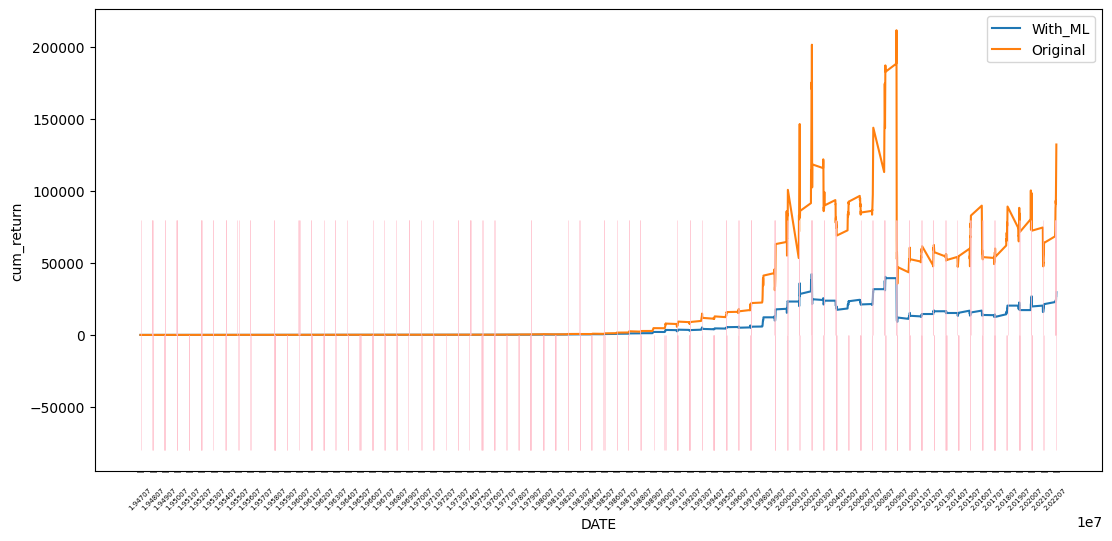

In [50]:
RDF_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.73692

최근 누적 수익률

  2022년-12월 -> 10502.28
  2022년-11월 -> 9614.61
  2022년-10월 -> 9397.68
  2022년-09월 -> 8447.18
  2022년-08월 -> 8045.15

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 10502.28
  2등 : 2009년-02월 -> 9971.84
  3등 : 2008년-11월 -> 9621.84
  4등 : 2022년-11월 -> 9614.61
  5등 : 2009년-01월 -> 9537.57
  6등 : 2008년-12월 -> 9455.57
  7등 : 2022년-10월 -> 9397.68
  8등 : 2002년-09월 -> 9272.55
  9등 : 2008년-06월 -> 9000.67
  10등 : 2008년-10월 -> 8939.61



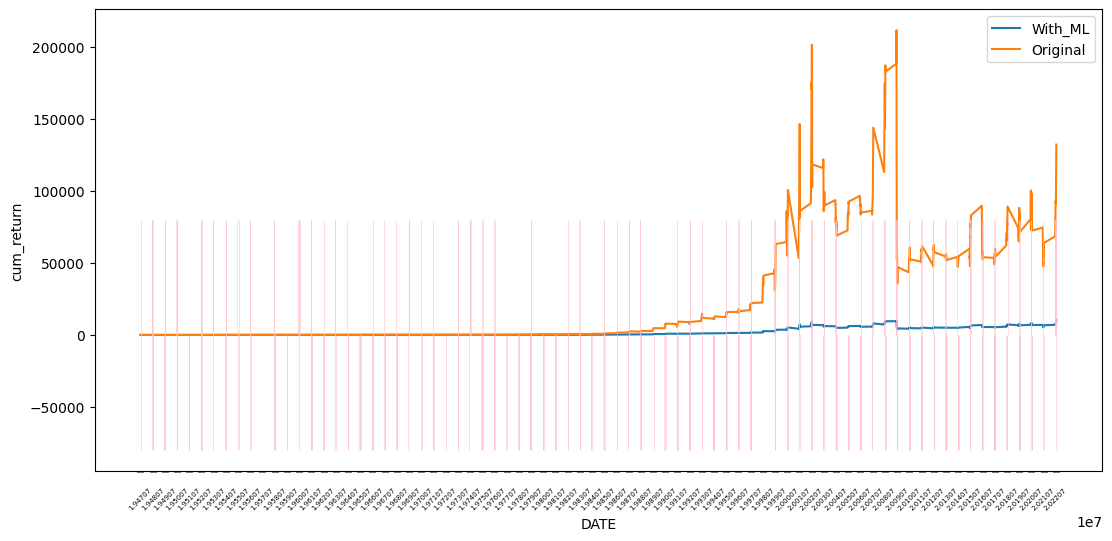

In [51]:
RDF_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [52]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.15      0.21       316
         1.0       0.65      0.85      0.74       590

    accuracy                           0.61       906
   macro avg       0.50      0.50      0.47       906
weighted avg       0.55      0.61      0.55       906


accuracy : 0.6059602649006622

precision : 0.6511024643320363

recall : 0.8508474576271187

F1-Score : 0.7376928728875827



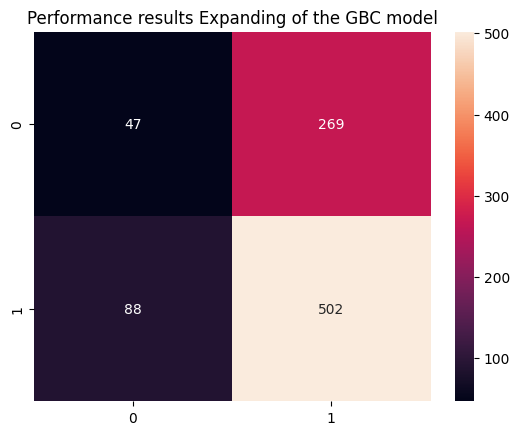


Feature Importance of the model



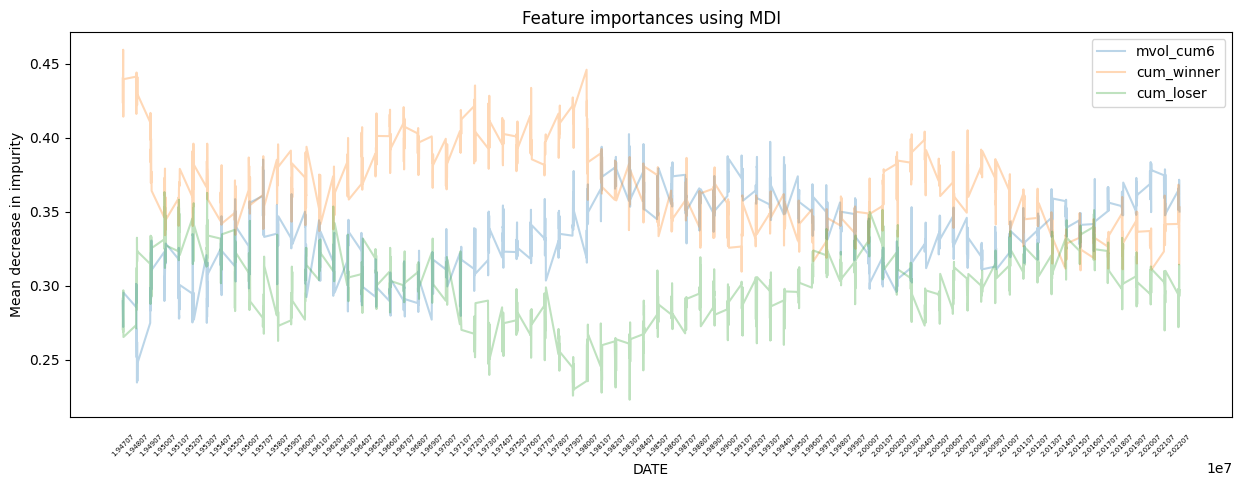

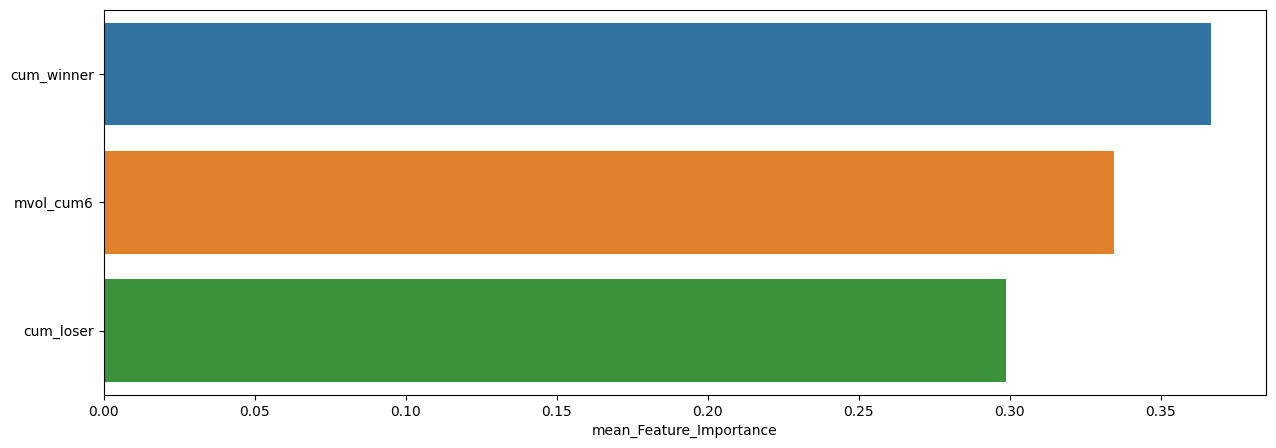

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.366583                0.459336   
mvol_cum6                  0.334645                0.402334   
cum_loser                  0.298772                0.363153   

            min_Feature_Importance  
cum_winner                0.309421  
mvol_cum6                 0.234559  
cum_loser                 0.222922

In [53]:
Expanding_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=GBC, # 사용할 모델
                                      model_name='GBC', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.20      0.25        75
         1.0       0.67      0.81      0.74       151

    accuracy                           0.61       226
   macro avg       0.51      0.51      0.50       226
weighted avg       0.56      0.61      0.58       226


accuracy : 0.6106194690265486

precision : 0.6721311475409836

recall : 0.8145695364238411

F1-Score : 0.7365269461077845



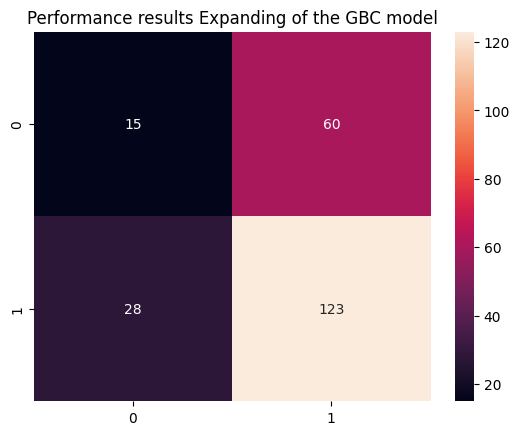


Feature Importance of the model



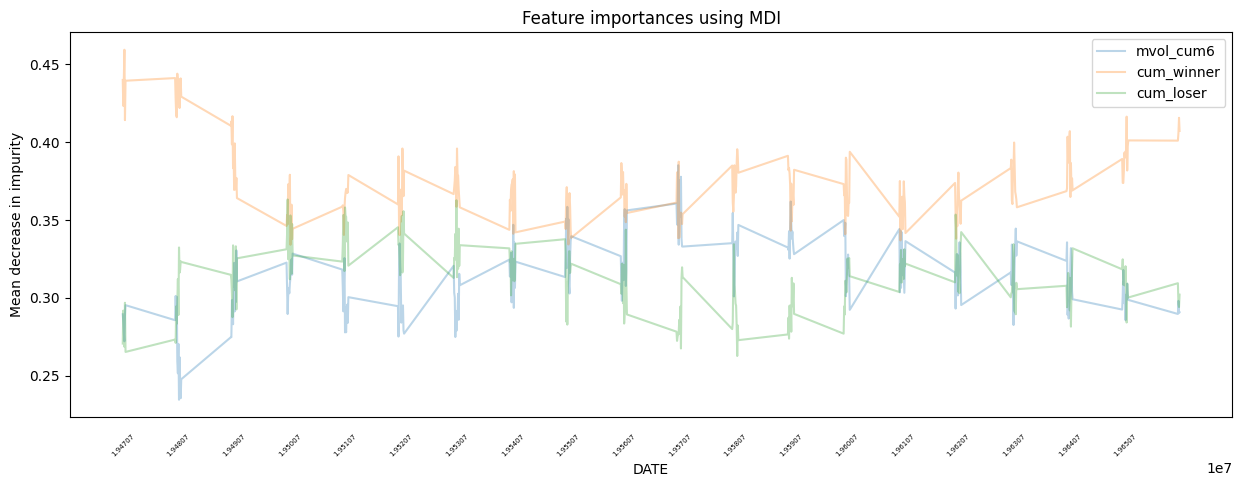

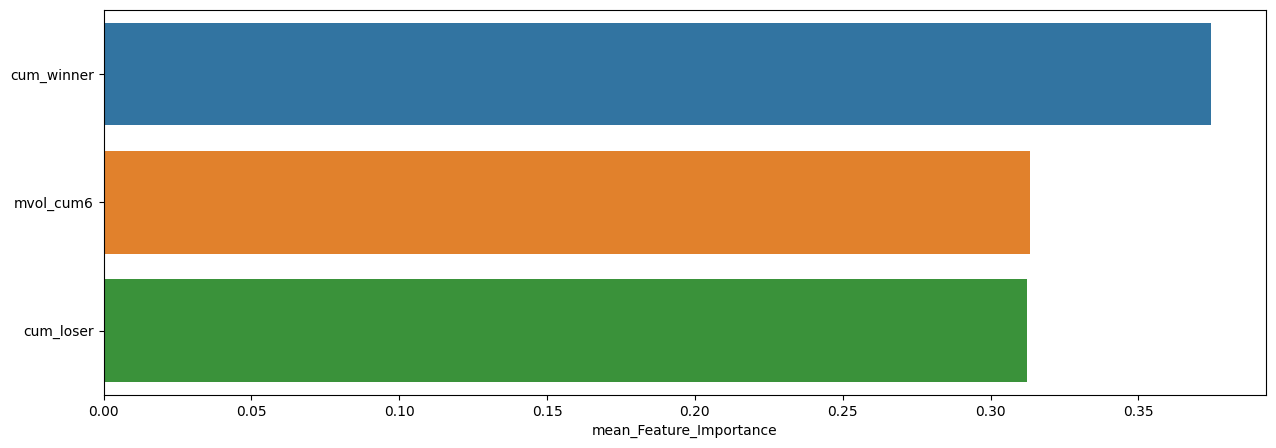

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.374477                0.459336   
mvol_cum6                  0.313356                0.385149   
cum_loser                  0.312167                0.363153   

            min_Feature_Importance  
cum_winner                0.334066  
mvol_cum6                 0.234559  
cum_loser                 0.262653


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.16      0.22        75
         1.0       0.68      0.87      0.76       151

    accuracy                           0.63       226
   macro avg       0.53      0.51      0.49       226
weighted avg       0.58      0.63      0.58       226


accuracy : 0.6327433628318584

precision : 0.6752577319587629

recall : 0.8675496688741722

F1-Score : 0.7594202898550725



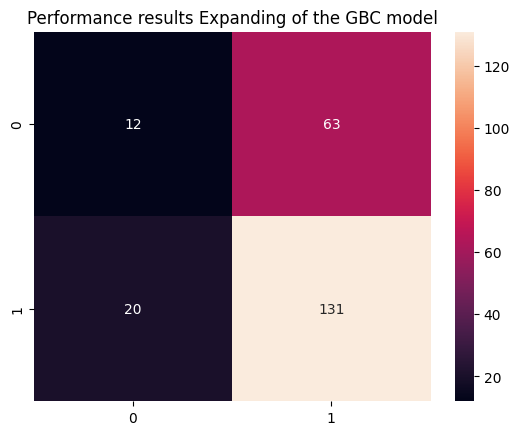


Feature Importance of the model



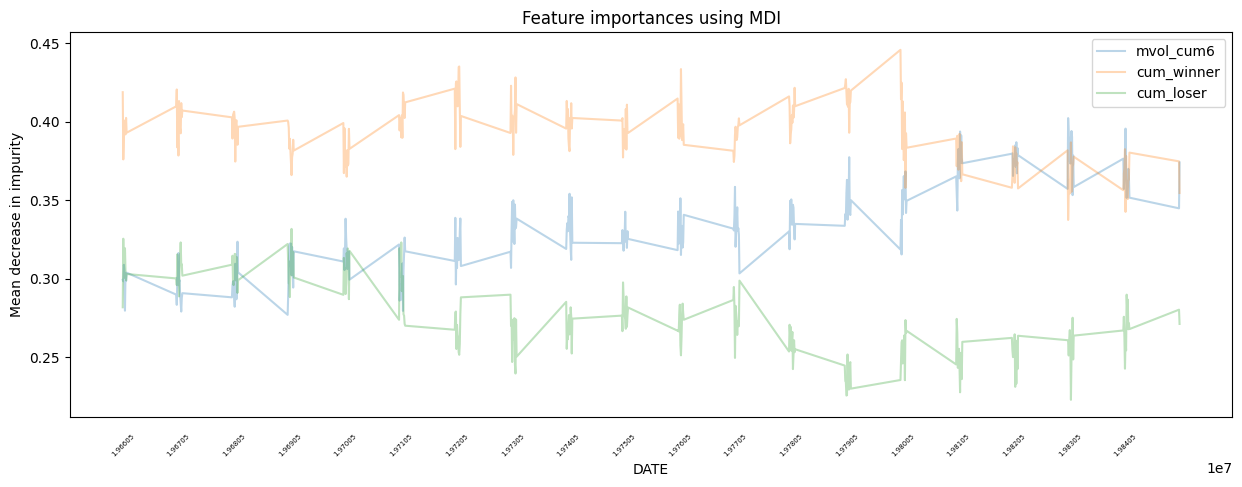

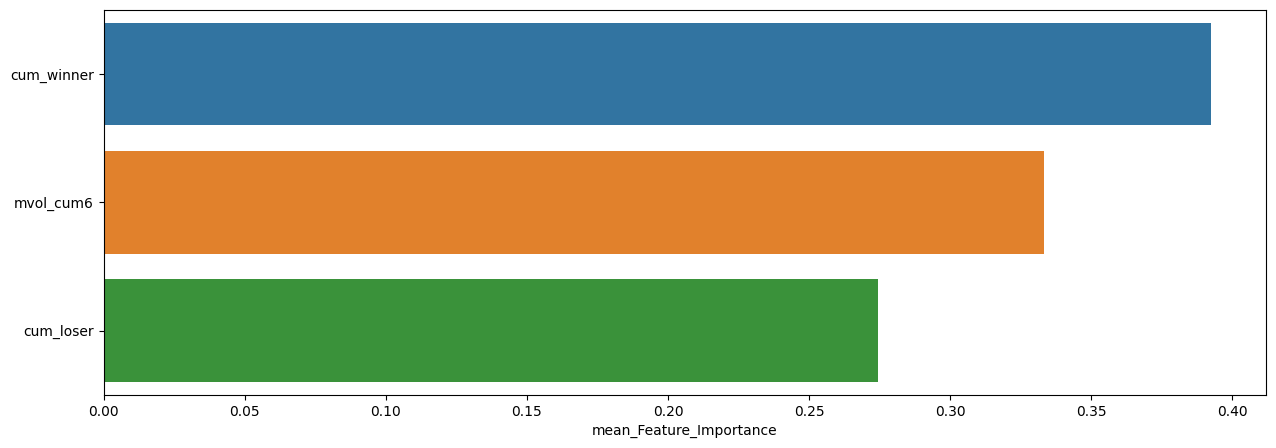

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.392324                0.445820   
mvol_cum6                  0.333149                0.402334   
cum_loser                  0.274527                0.331795   

            min_Feature_Importance  
cum_winner                0.337488  
mvol_cum6                 0.277042  
cum_loser                 0.222922


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.16      0.22        70
         1.0       0.70      0.88      0.78       156

    accuracy                           0.65       226
   macro avg       0.53      0.52      0.50       226
weighted avg       0.60      0.65      0.61       226


accuracy : 0.6548672566371682

precision : 0.6989795918367347

recall : 0.8782051282051282

F1-Score : 0.7784090909090909



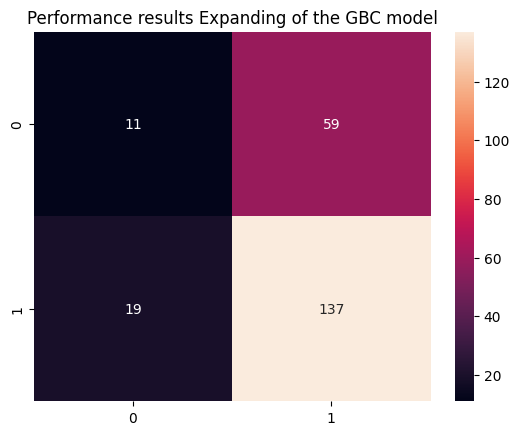


Feature Importance of the model



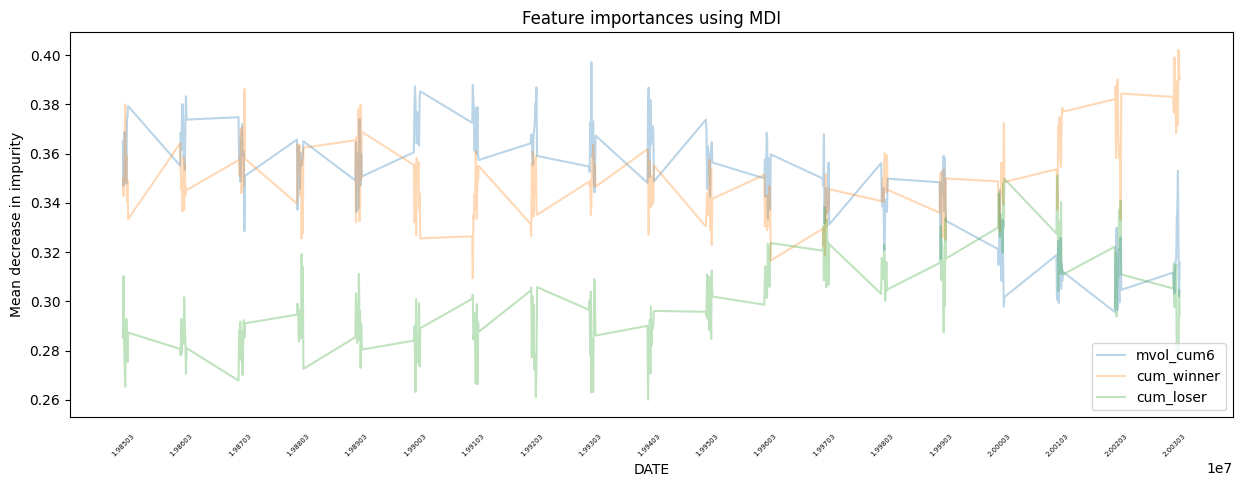

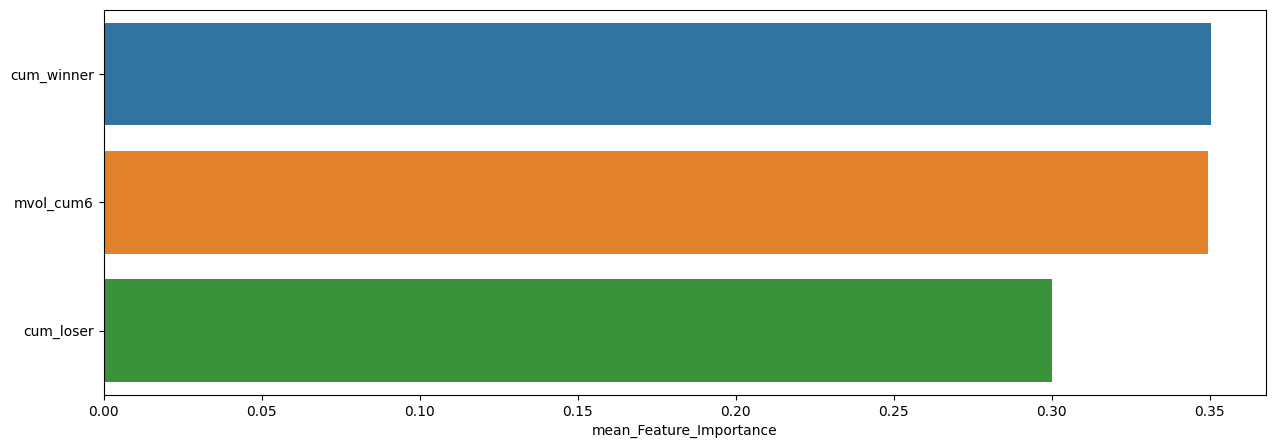

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                  0.35038                0.402255   
mvol_cum6                   0.34952                0.397153   
cum_loser                   0.30010                0.351172   

            min_Feature_Importance  
cum_winner                0.309421  
mvol_cum6                 0.295647  
cum_loser                 0.259987


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.09      0.14        96
         1.0       0.56      0.84      0.67       132

    accuracy                           0.53       228
   macro avg       0.43      0.47      0.41       228
weighted avg       0.45      0.53      0.45       228


accuracy : 0.5263157894736842

precision : 0.5606060606060606

recall : 0.8409090909090909

F1-Score : 0.6727272727272727



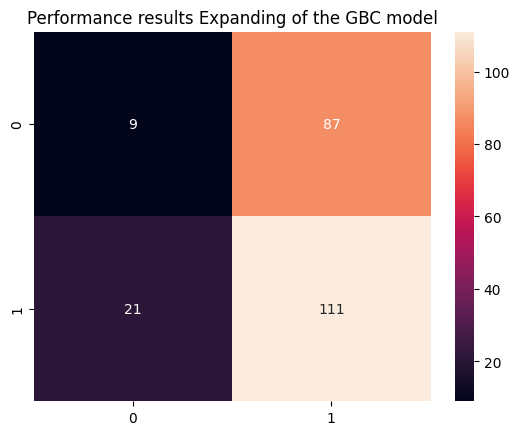


Feature Importance of the model



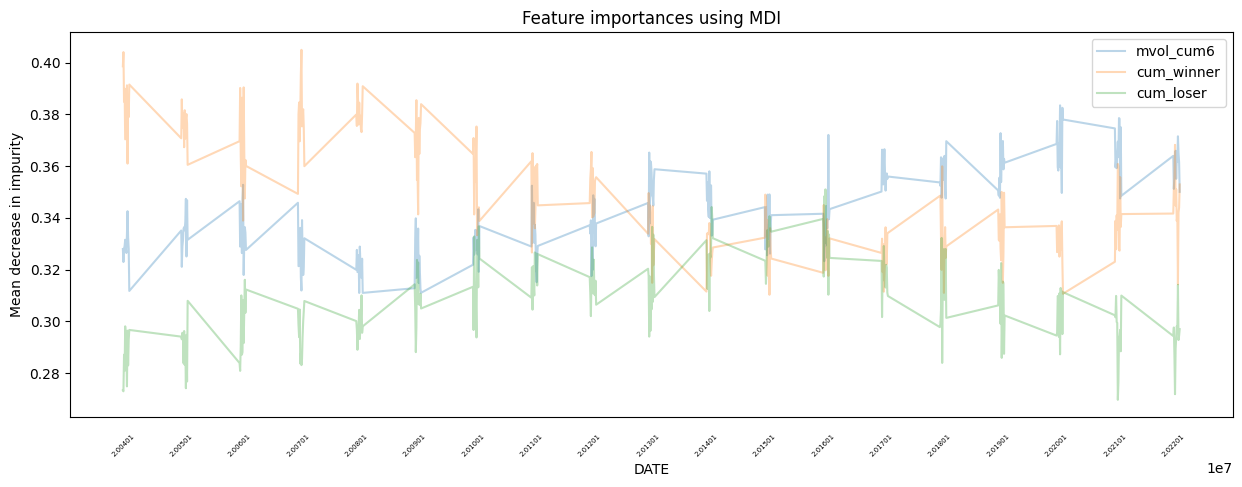

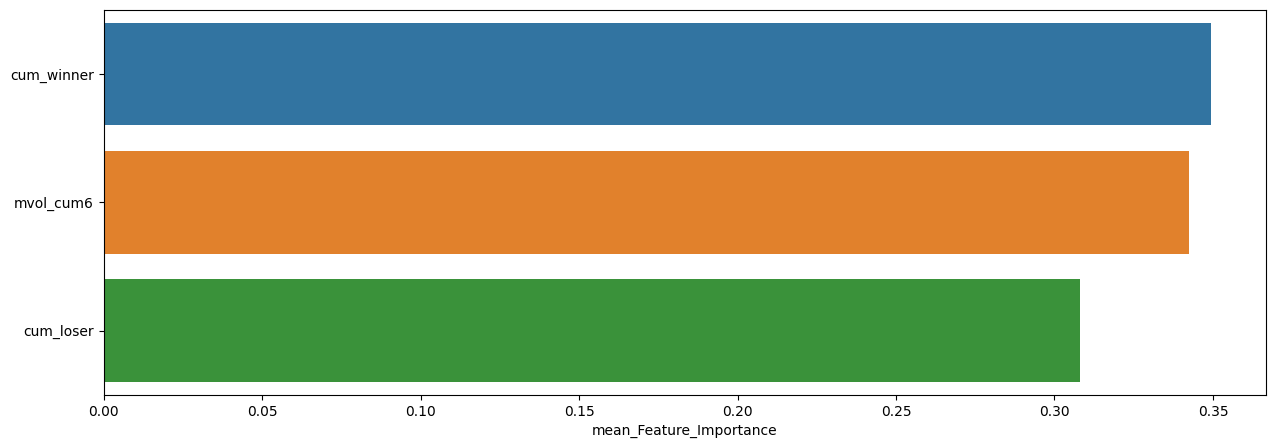

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.349306                0.404917   
mvol_cum6                  0.342486                0.383468   
cum_loser                  0.308208                0.351013   

            min_Feature_Importance  
cum_winner                0.310305  
mvol_cum6                 0.311009  
cum_loser                 0.269720

In [54]:
slice_feature_importance(Expanding_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



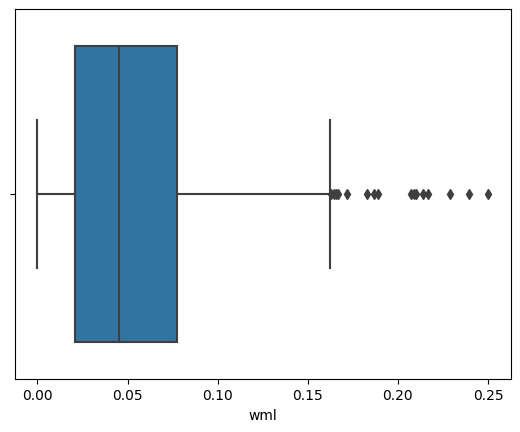

count      mean       std       min       25%       50%       75%  \
wml  502.0  0.054627  0.044956  0.000007  0.020974  0.045171  0.077709   

          max  
wml  0.250175


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



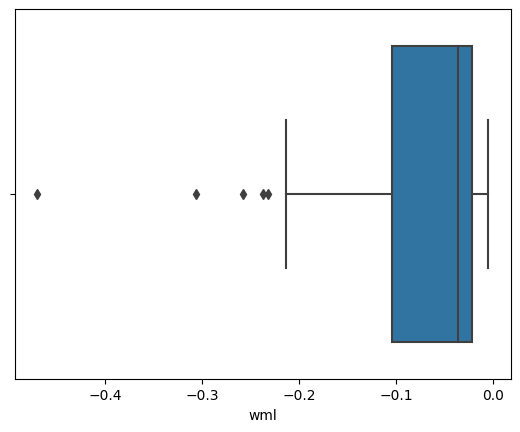

count     mean       std       min       25%       50%       75%      max
wml   47.0 -0.07879  0.094747 -0.469903 -0.105022 -0.036068 -0.021683 -0.00527


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



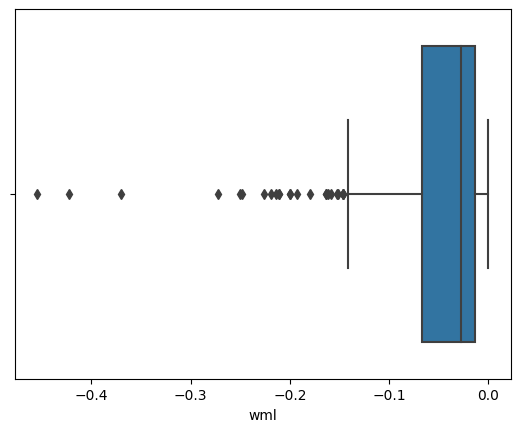

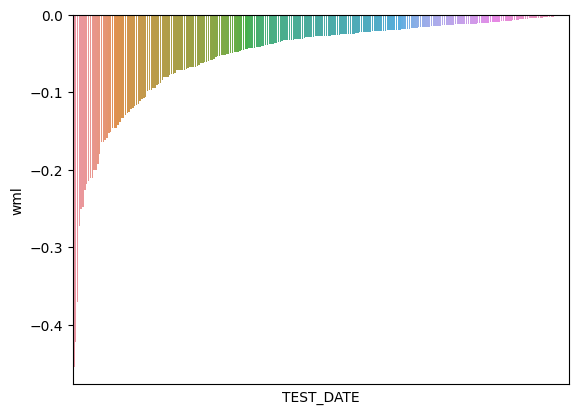

count      mean       std       min       25%       50%       75%  \
wml  269.0 -0.052383  0.065723 -0.454349 -0.066457 -0.027335 -0.013339   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



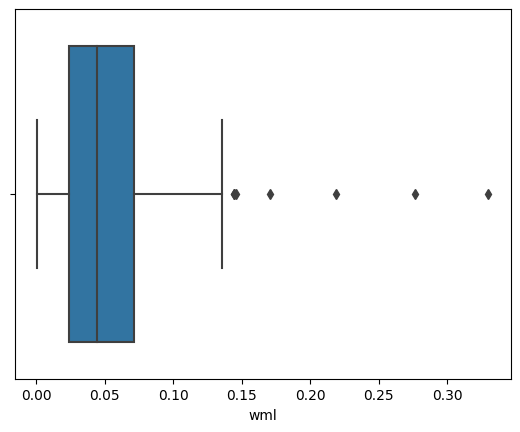

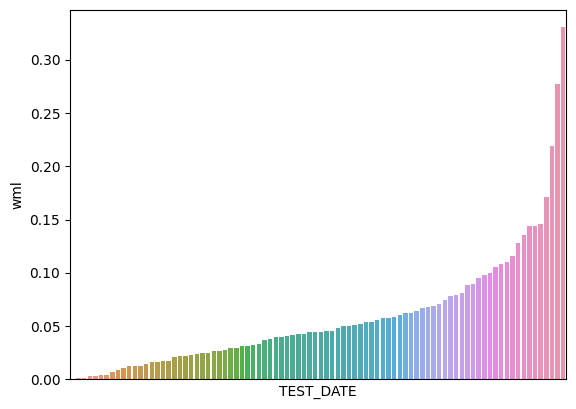

count      mean       std       min       25%       50%       75%  \
wml   88.0  0.058805  0.056407  0.000692  0.023956  0.044367  0.071306   

          max  
wml  0.330163

In [55]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Expanding_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.68600

최근 누적 수익률

  2022년-12월 -> 61612.63
  2022년-11월 -> 61612.63
  2022년-10월 -> 61612.63
  2022년-09월 -> 54557.08
  2022년-08월 -> 49600.42

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 86169.46
  2등 : 2002년-08월 -> 72861.37
  3등 : 2002년-07월 -> 72861.37
  4등 : 2009년-02월 -> 71637.52
  5등 : 2002년-10월 -> 69525.93
  6등 : 2002년-06월 -> 69082.30
  7등 : 2008년-11월 -> 65334.77
  8등 : 2009년-01월 -> 63788.34
  9등 : 2008년-12월 -> 63788.34
  10등 : 2022년-12월 -> 61612.63



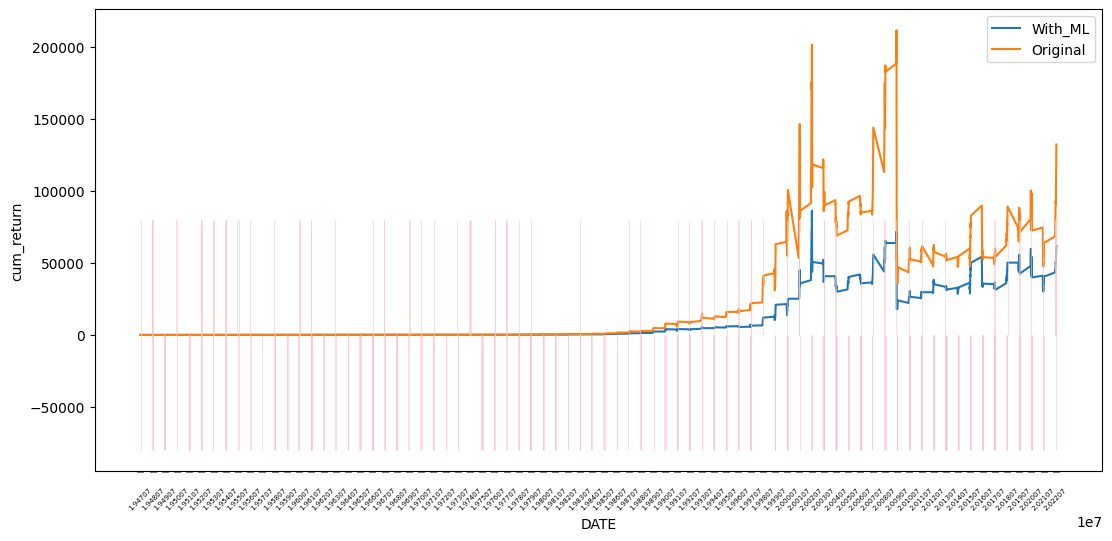

In [56]:
GBC_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.72784

최근 누적 수익률

  2022년-12월 -> 5522.41
  2022년-11월 -> 5238.09
  2022년-10월 -> 5134.36
  2022년-09월 -> 4742.68
  2022년-08월 -> 4492.16

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 8691.80
  2등 : 2002년-09월 -> 8423.40
  3등 : 2008년-11월 -> 8294.14
  4등 : 2009년-01월 -> 8179.25
  5등 : 2008년-12월 -> 8134.98
  6등 : 2002년-07월 -> 7755.40
  7등 : 2008년-10월 -> 7747.10
  8등 : 2008년-06월 -> 7735.95
  9등 : 2002년-08월 -> 7649.34
  10등 : 2008년-09월 -> 7502.24



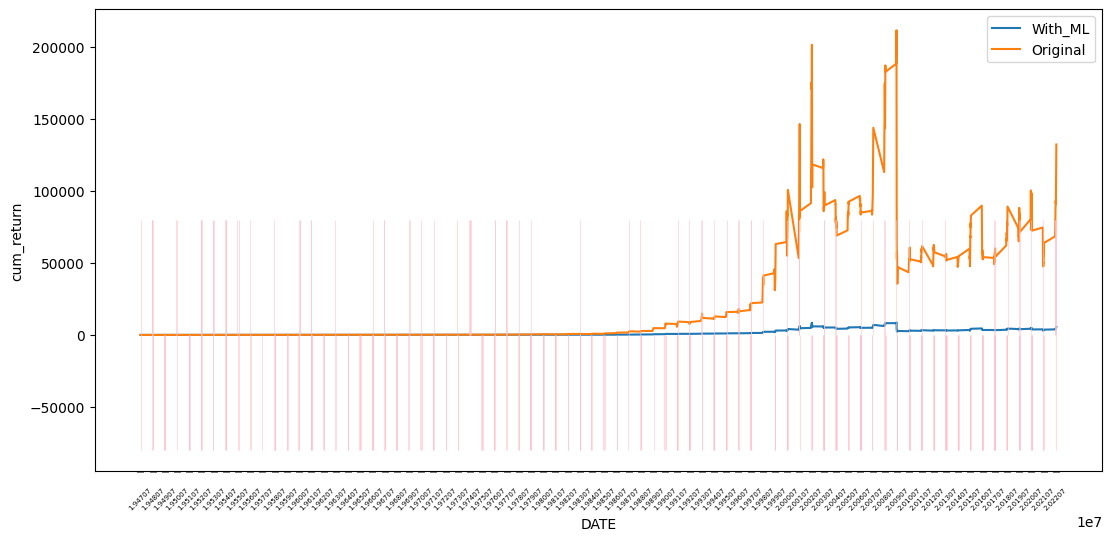

In [57]:
GBC_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                  WML,
                                                  'GBC_PROB_POS_WML',
                                                  GBC_A0_P1,
                                                  GBC_A1_P0,
                                                  plot=True)

### XGB

In [58]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : No

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.31      0.34       316
         1.0       0.66      0.71      0.68       590

    accuracy                           0.57       906
   macro avg       0.51      0.51      0.51       906
weighted avg       0.55      0.57      0.56       906


accuracy : 0.5684326710816777

precision : 0.6571879936808847

recall : 0.7050847457627119

F1-Score : 0.6802943581357318



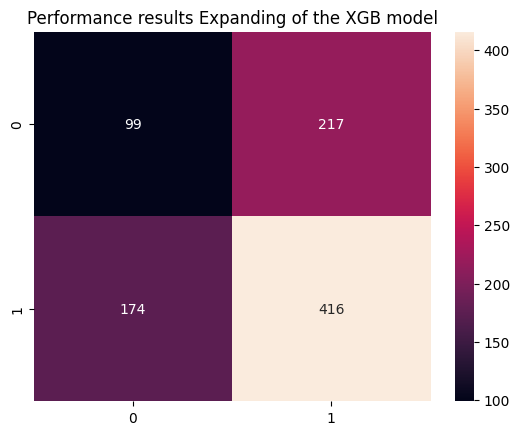


Feature Importance of the model



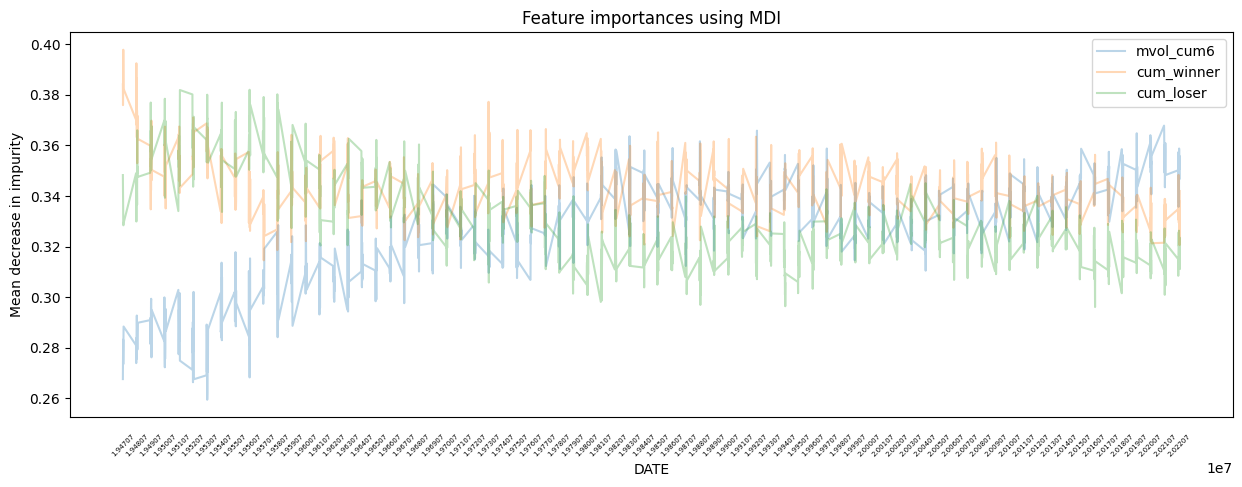

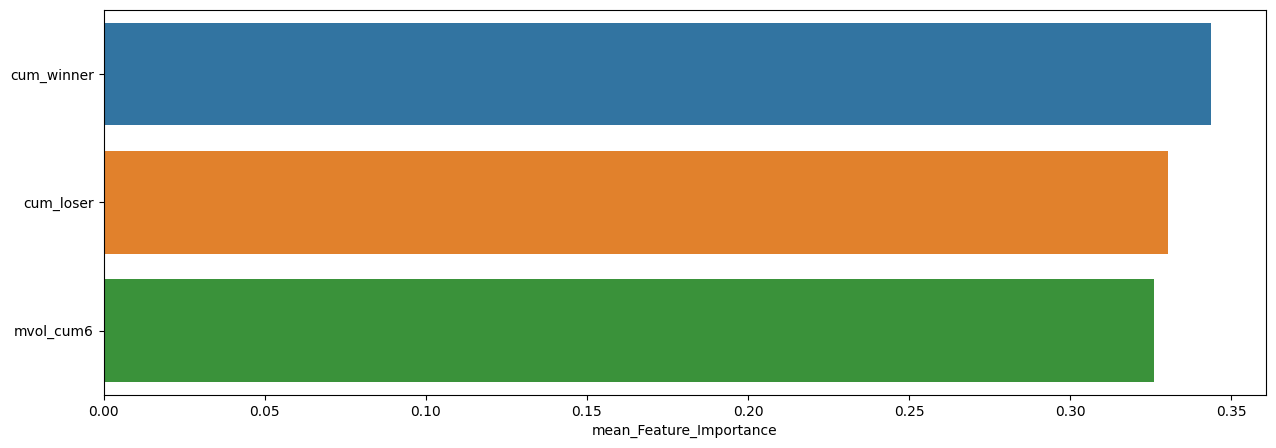

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.343638                0.397766   
cum_loser                  0.330405                0.381957   
mvol_cum6                  0.325956                0.367792   

            min_Feature_Importance  
cum_winner                0.314579  
cum_loser                 0.296129  
mvol_cum6                 0.259497

In [59]:
Expanding_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.40      0.38        75
         1.0       0.69      0.66      0.67       151

    accuracy                           0.57       226
   macro avg       0.53      0.53      0.53       226
weighted avg       0.58      0.57      0.58       226


accuracy : 0.5707964601769911

precision : 0.6875

recall : 0.6556291390728477

F1-Score : 0.6711864406779661



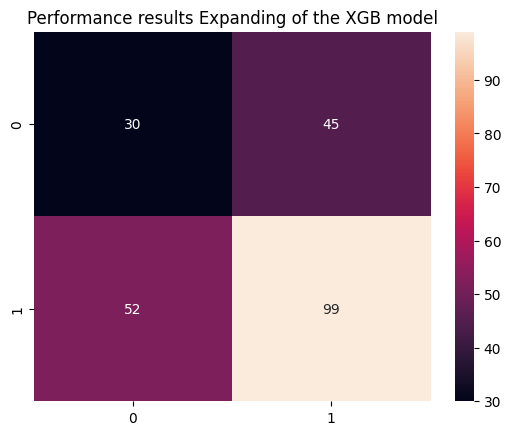


Feature Importance of the model



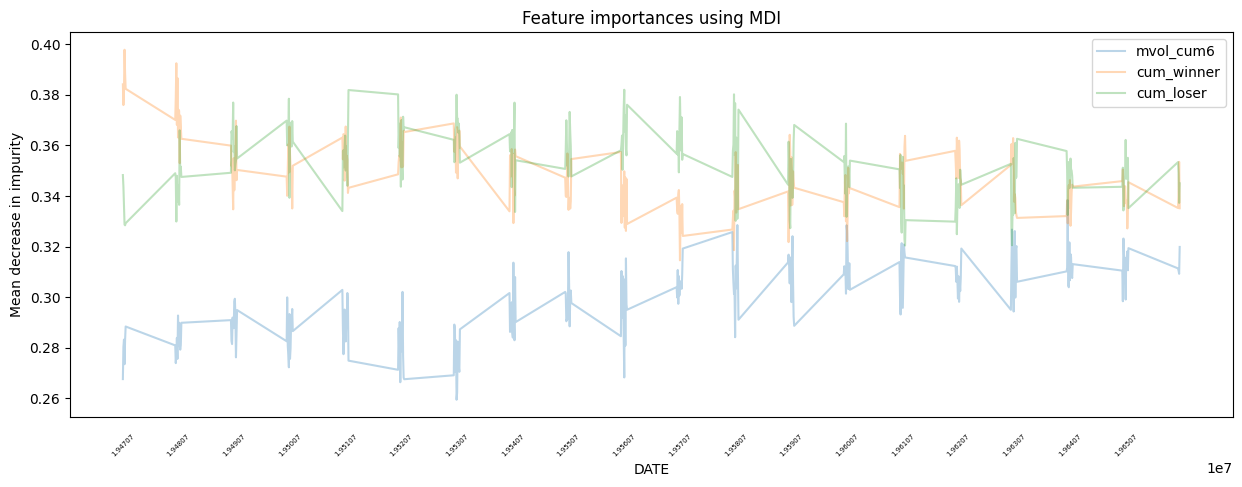

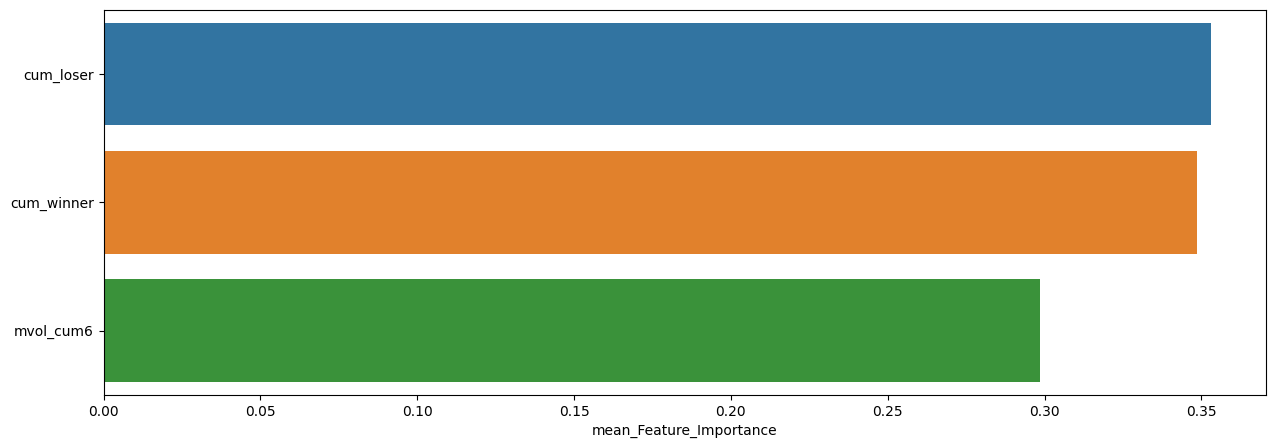

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                  0.352996                0.381957   
cum_winner                 0.348517                0.397766   
mvol_cum6                  0.298487                0.338295   

            min_Feature_Importance  
cum_loser                 0.320428  
cum_winner                0.314579  
mvol_cum6                 0.259497


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.32      0.35        75
         1.0       0.69      0.75      0.72       151

    accuracy                           0.61       226
   macro avg       0.54      0.53      0.53       226
weighted avg       0.59      0.61      0.60       226


accuracy : 0.6061946902654868

precision : 0.6890243902439024

recall : 0.7483443708609272

F1-Score : 0.7174603174603174



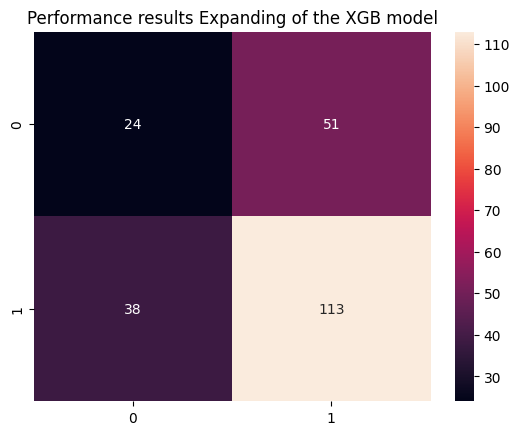


Feature Importance of the model



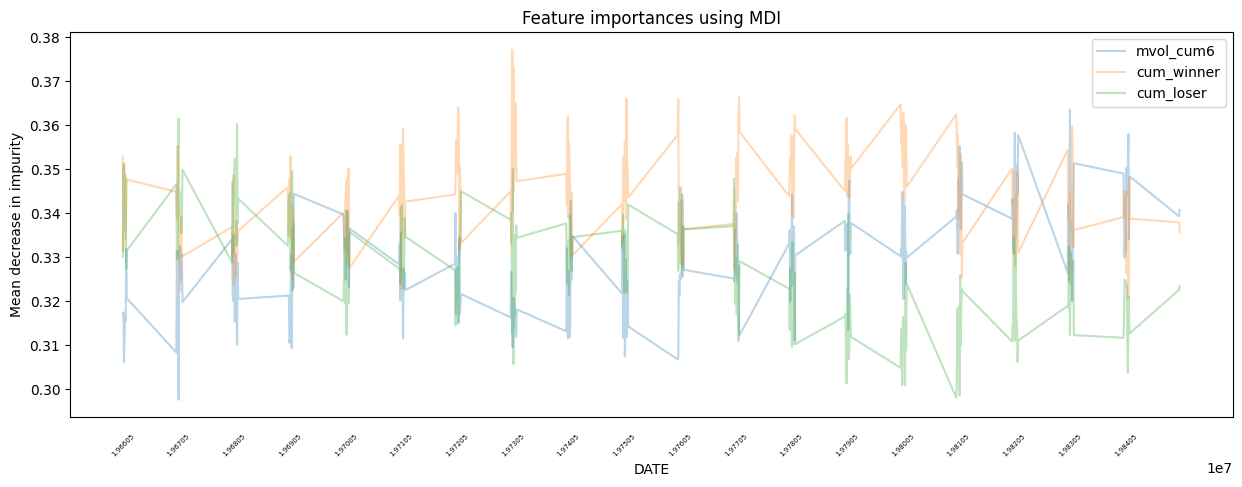

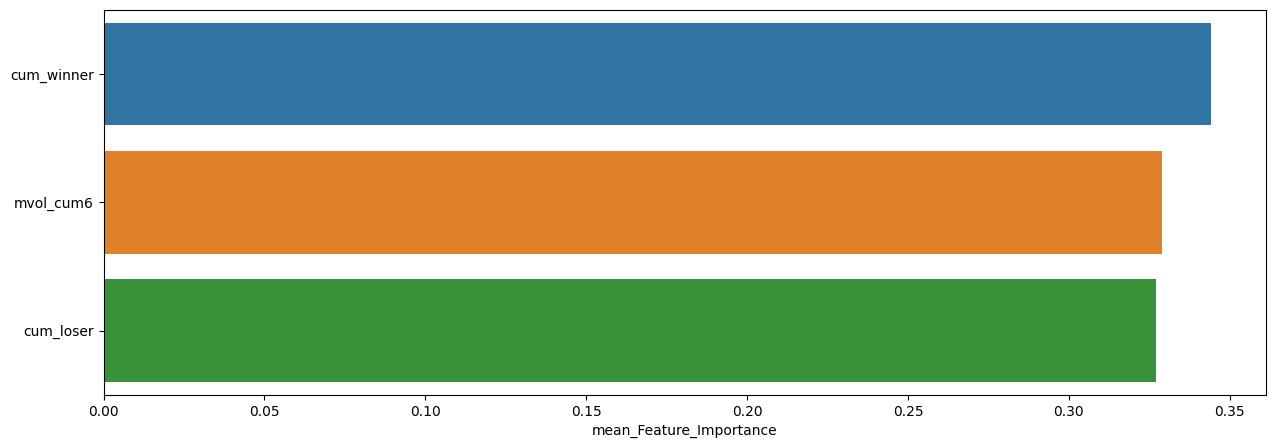

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.344097                0.377193   
mvol_cum6                  0.328876                0.363600   
cum_loser                  0.327028                0.361587   

            min_Feature_Importance  
cum_winner                0.320814  
mvol_cum6                 0.297648  
cum_loser                 0.298128


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.31      0.24      0.27        70
         1.0       0.69      0.76      0.73       156

    accuracy                           0.60       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.58      0.60      0.59       226


accuracy : 0.6017699115044248

precision : 0.6918604651162791

recall : 0.7628205128205128

F1-Score : 0.725609756097561



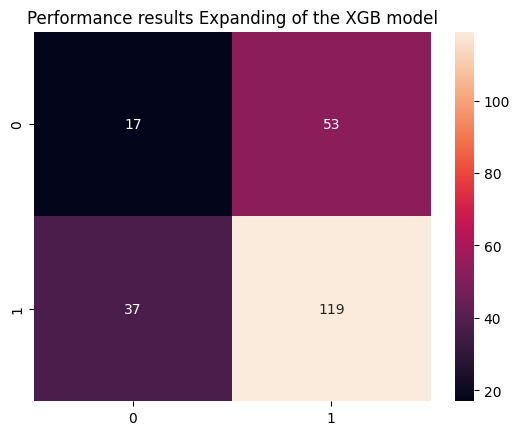


Feature Importance of the model



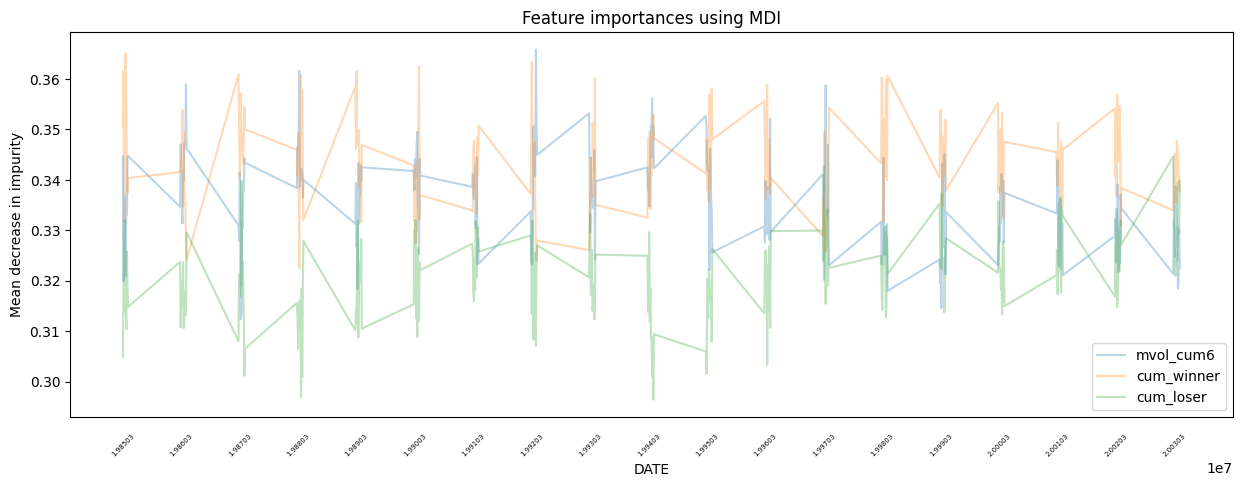

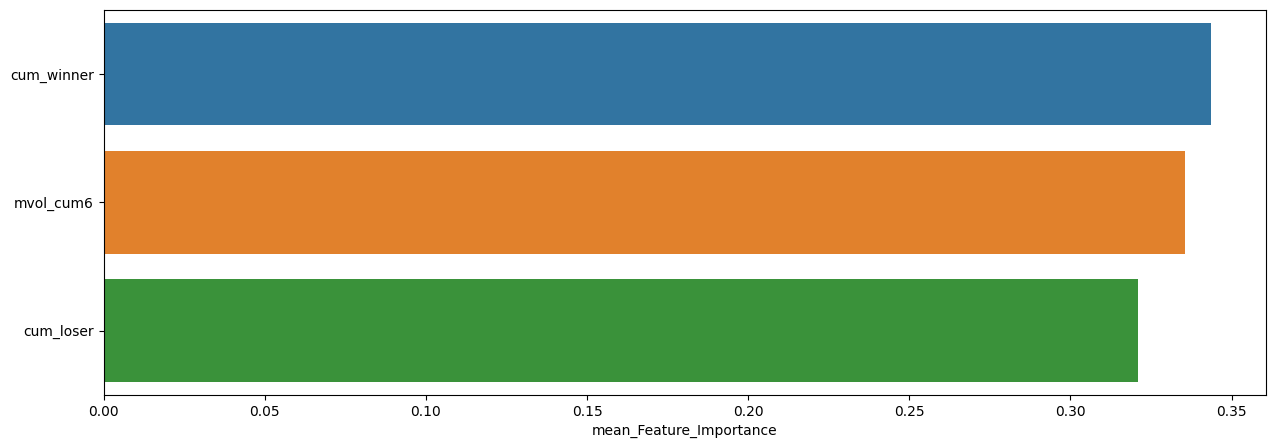

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                 0.343525                0.365096   
mvol_cum6                  0.335573                0.365803   
cum_loser                  0.320902                0.344651   

            min_Feature_Importance  
cum_winner                0.322496  
mvol_cum6                 0.312344  
cum_loser                 0.296442


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.29      0.33        96
         1.0       0.56      0.64      0.60       132

    accuracy                           0.50       228
   macro avg       0.46      0.47      0.46       228
weighted avg       0.48      0.50      0.48       228


accuracy : 0.4956140350877193

precision : 0.5555555555555556

recall : 0.6439393939393939

F1-Score : 0.5964912280701755



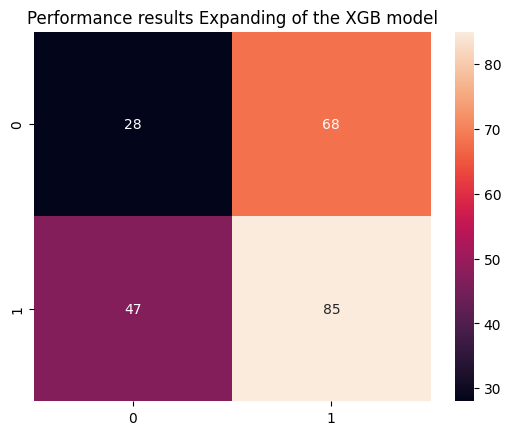


Feature Importance of the model



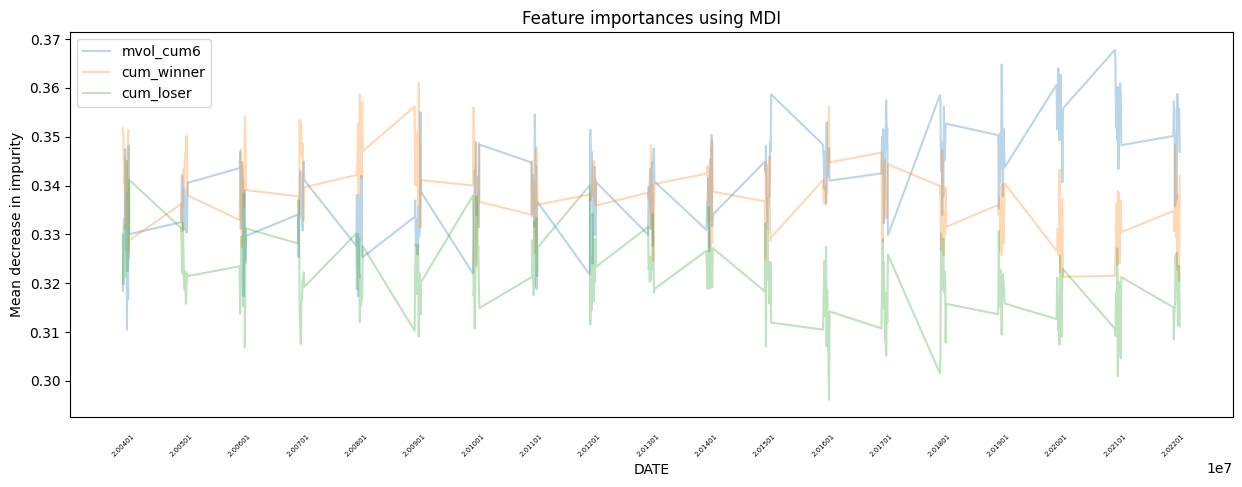

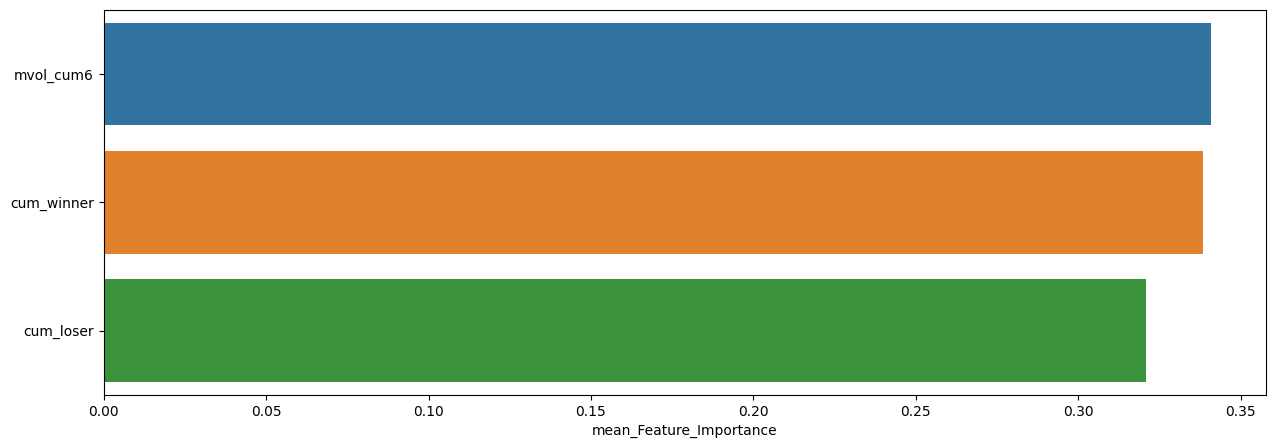

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                  0.340758                0.367792   
cum_winner                 0.338461                0.361079   
cum_loser                  0.320781                0.345056   

            min_Feature_Importance  
mvol_cum6                 0.310486  
cum_winner                0.320572  
cum_loser                 0.296129

In [60]:
slice_feature_importance(Expanding_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



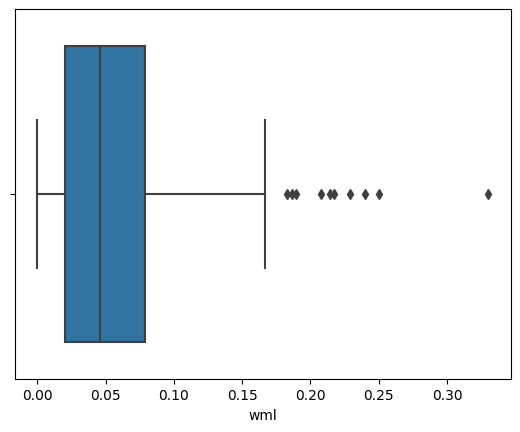

count      mean       std       min       25%      50%       75%  \
wml  416.0  0.055822  0.047248  0.000128  0.020119  0.04627  0.078802   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



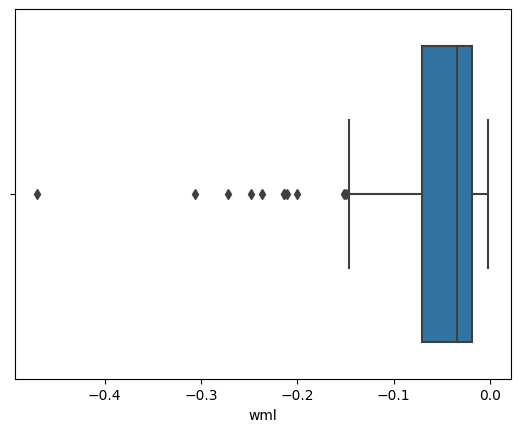

count      mean       std       min       25%       50%      75%  \
wml   99.0 -0.062668  0.076978 -0.469903 -0.070223 -0.034597 -0.01814   

          max  
wml -0.001641


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



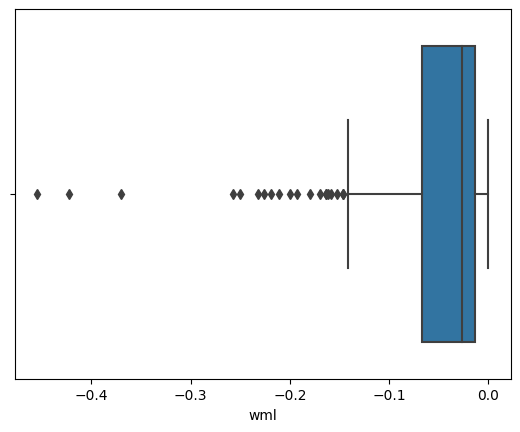

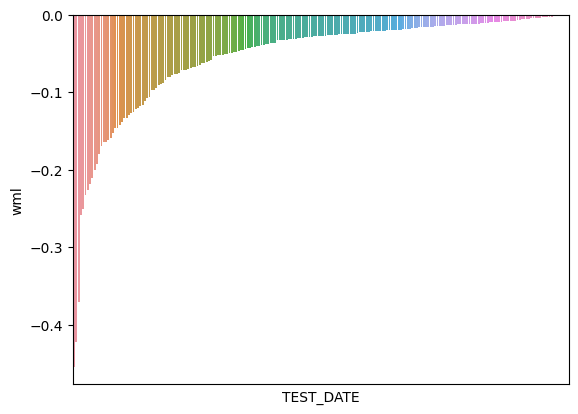

count      mean       std       min       25%       50%      75%  \
wml  217.0 -0.053411  0.068445 -0.454349 -0.066457 -0.027097 -0.01379   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



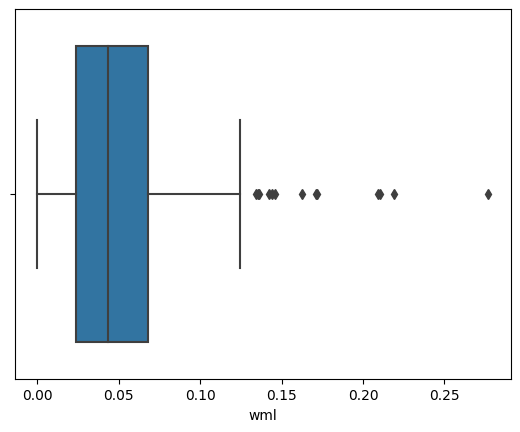

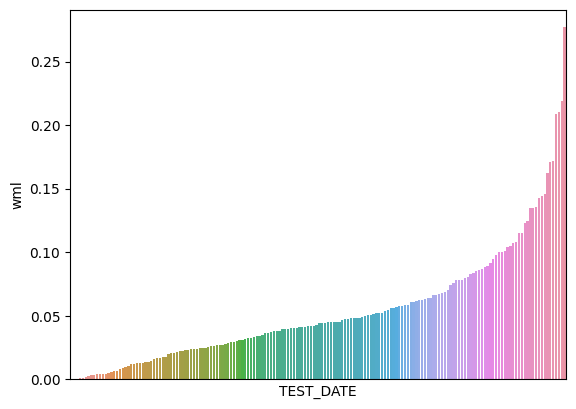

count      mean       std       min       25%       50%      75%  \
wml  174.0  0.053881  0.045854  0.000007  0.023787  0.043589  0.06763   

          max  
wml  0.276912

In [61]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Expanding_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.67198

최근 누적 수익률

  2022년-12월 -> 15021.22
  2022년-11월 -> 13533.76
  2022년-10월 -> 13533.76
  2022년-09월 -> 11983.86
  2022년-08월 -> 11983.86

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 30582.33
  2등 : 2008년-11월 -> 28539.46
  3등 : 2001년-09월 -> 28465.55
  4등 : 2009년-02월 -> 27863.93
  5등 : 2009년-01월 -> 27863.93
  6등 : 2008년-12월 -> 27863.93
  7등 : 2008년-06월 -> 26610.27
  8등 : 2008년-10월 -> 26025.51
  9등 : 2002년-07월 -> 25859.07
  10등 : 2002년-08월 -> 25859.07



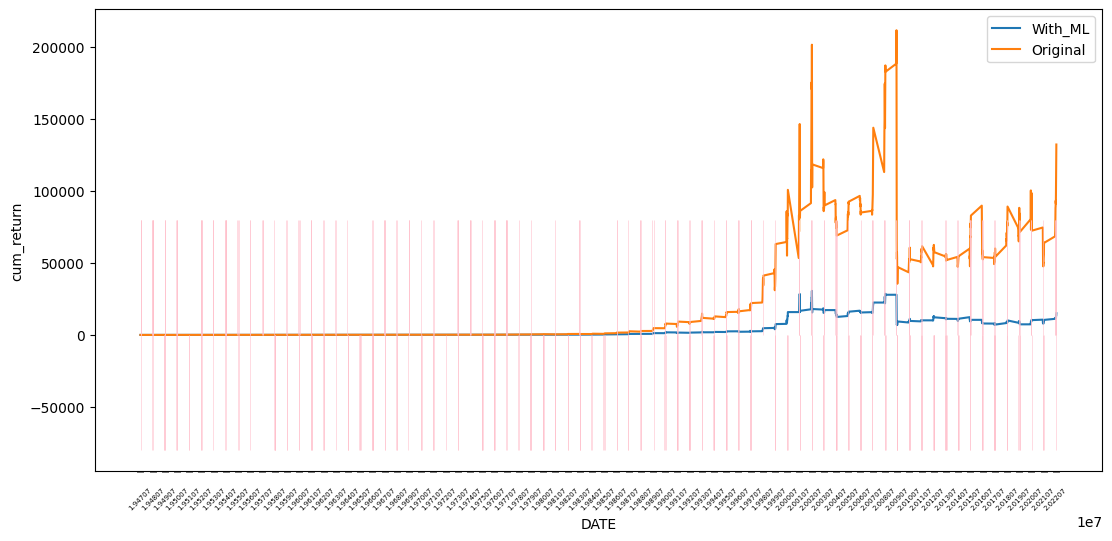

In [62]:
XGB_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.70827

최근 누적 수익률

  2022년-12월 -> 10846.58
  2022년-11월 -> 9848.68
  2022년-10월 -> 9634.43
  2022년-09월 -> 8720.30
  2022년-08월 -> 8413.52

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 17624.56
  2등 : 2002년-07월 -> 16035.70
  3등 : 2009년-02월 -> 15949.15
  4등 : 2002년-08월 -> 15835.27
  5등 : 2008년-11월 -> 15737.30
  6등 : 2002년-06월 -> 15670.19
  7등 : 2009년-01월 -> 15462.78
  8등 : 2008년-12월 -> 15393.19
  9등 : 2002년-10월 -> 14841.69
  10등 : 2008년-10월 -> 14415.76



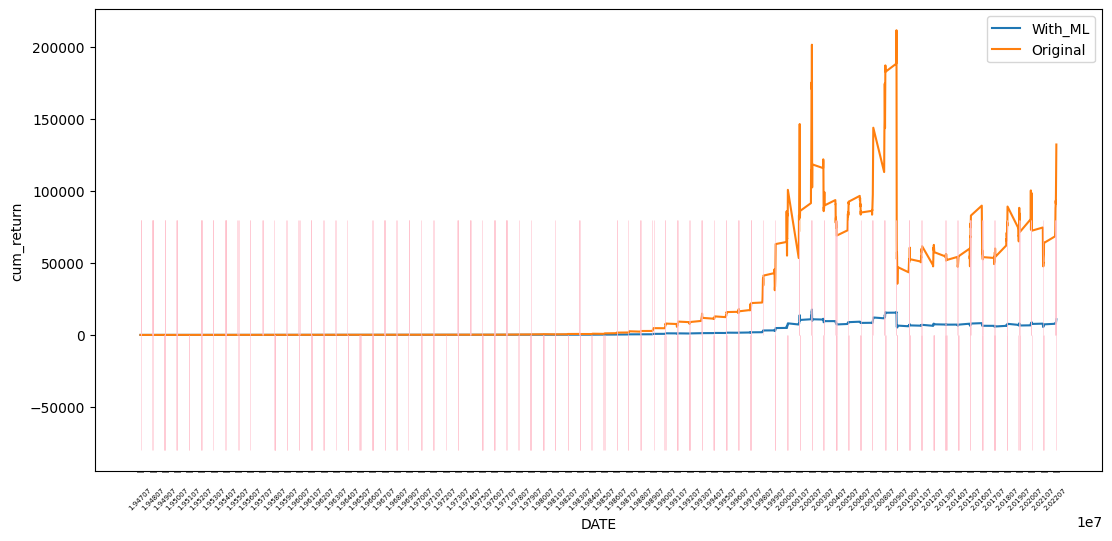

In [63]:
XGB_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [64]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.28      0.32       316
         1.0       0.66      0.74      0.70       590

    accuracy                           0.58       906
   macro avg       0.51      0.51      0.51       906
weighted avg       0.56      0.58      0.57       906


accuracy : 0.5805739514348786

precision : 0.6586102719033232

recall : 0.7389830508474576

F1-Score : 0.6964856230031949



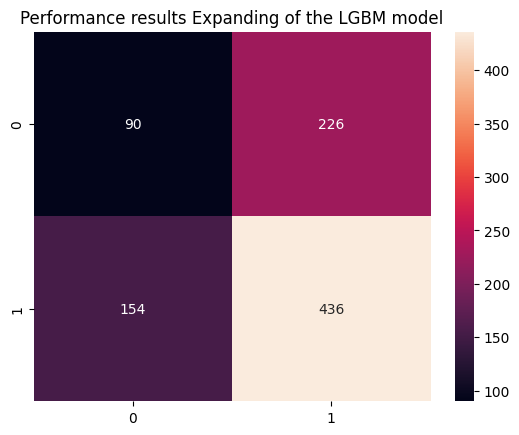


Feature Importance of the model



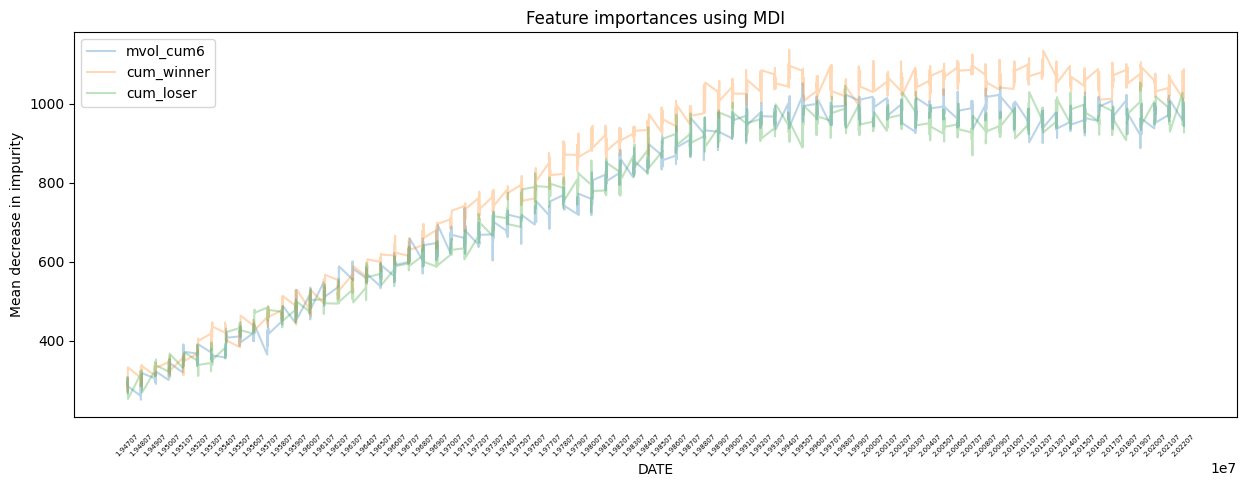

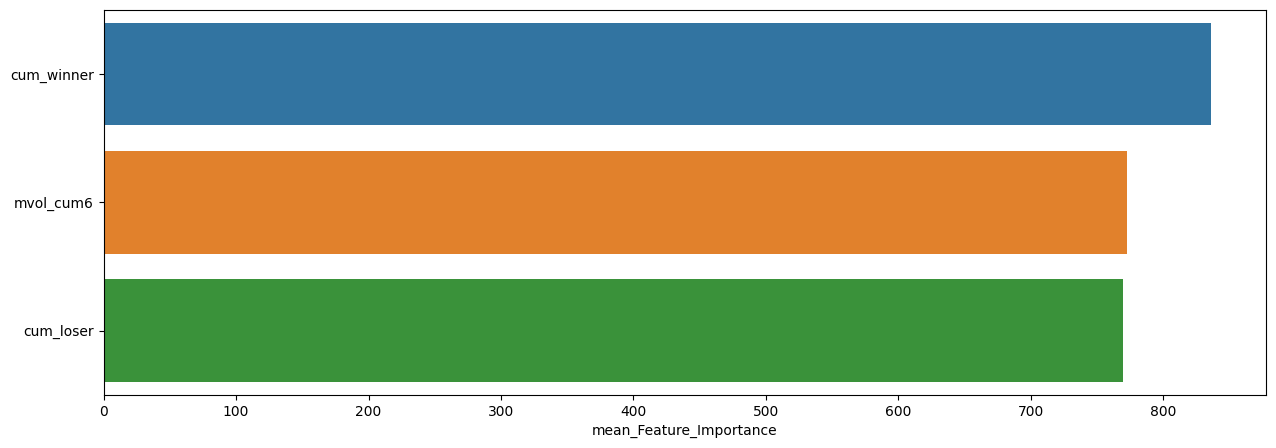

mean_Feature_Importance  max_Feature_Importance  \
cum_winner               835.779249                    1136   
mvol_cum6                772.280353                    1051   
cum_loser                769.232892                    1053   

            min_Feature_Importance  
cum_winner                     272  
mvol_cum6                      251  
cum_loser                      253

In [65]:
Expanding_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.33      0.36        75
         1.0       0.69      0.74      0.71       151

    accuracy                           0.60       226
   macro avg       0.54      0.53      0.53       226
weighted avg       0.59      0.60      0.59       226


accuracy : 0.6017699115044248

precision : 0.6894409937888198

recall : 0.7350993377483444

F1-Score : 0.7115384615384615



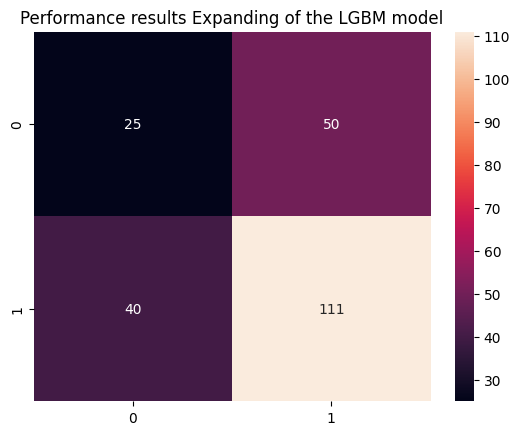


Feature Importance of the model



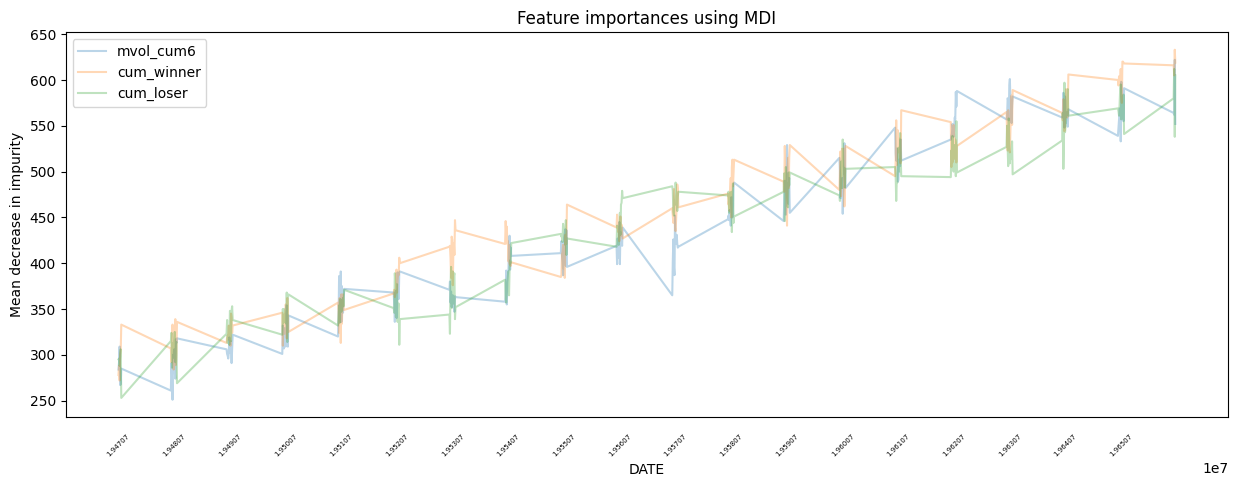

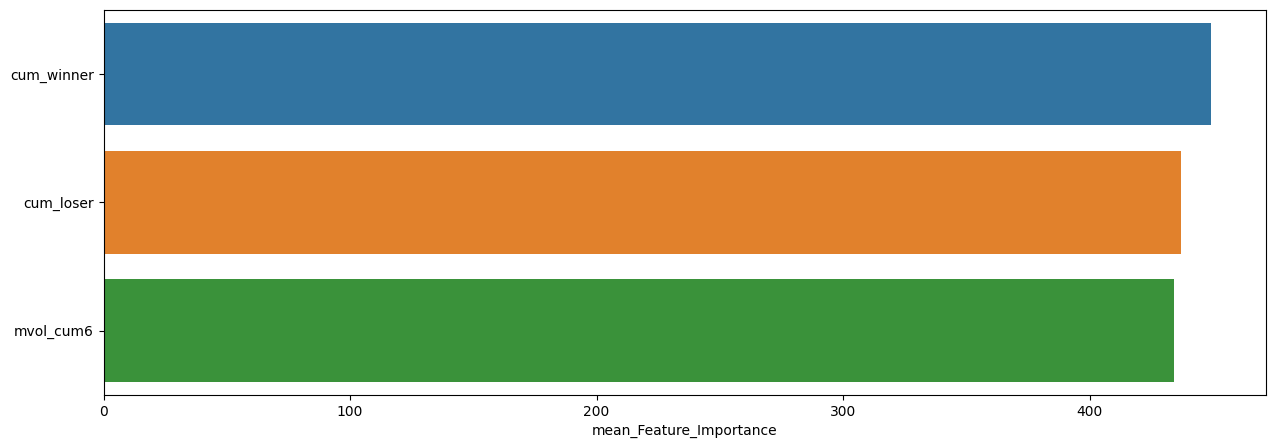

mean_Feature_Importance  max_Feature_Importance  \
cum_winner               449.132743                     633   
cum_loser                437.154867                     612   
mvol_cum6                434.203540                     622   

            min_Feature_Importance  
cum_winner                     272  
cum_loser                      253  
mvol_cum6                      251


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.42      0.33      0.37        75
         1.0       0.70      0.77      0.73       151

    accuracy                           0.62       226
   macro avg       0.56      0.55      0.55       226
weighted avg       0.61      0.62      0.61       226


accuracy : 0.6238938053097345

precision : 0.6987951807228916

recall : 0.7682119205298014

F1-Score : 0.7318611987381703



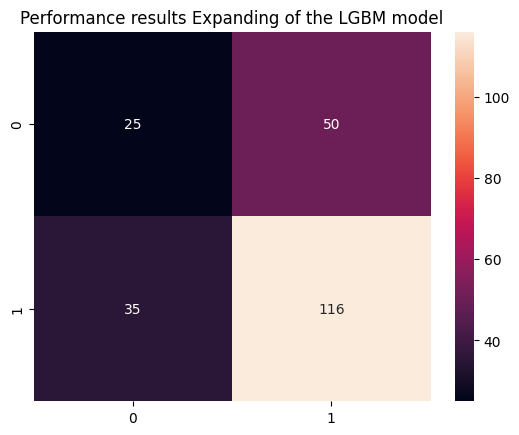


Feature Importance of the model



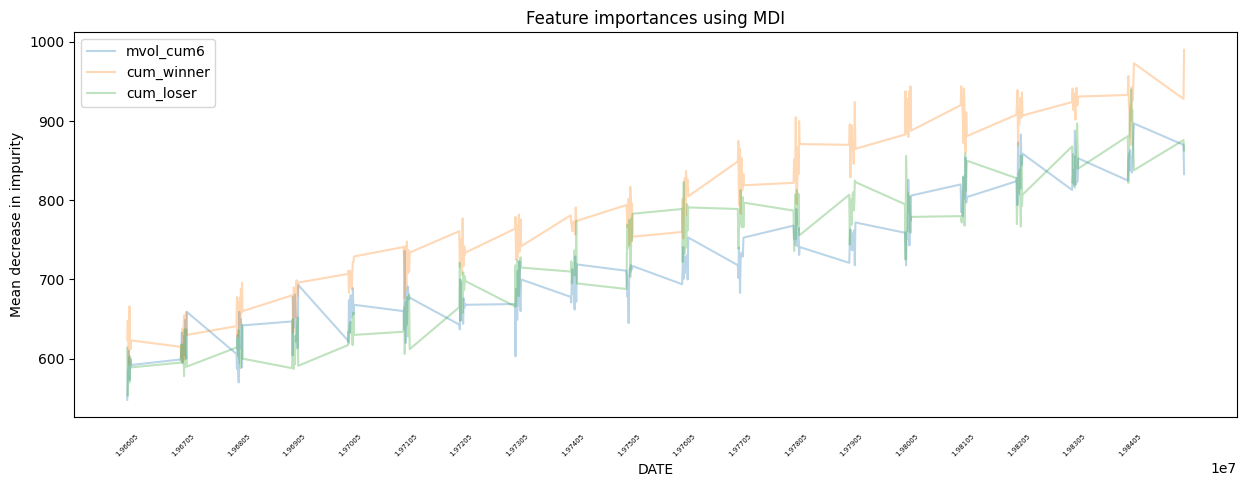

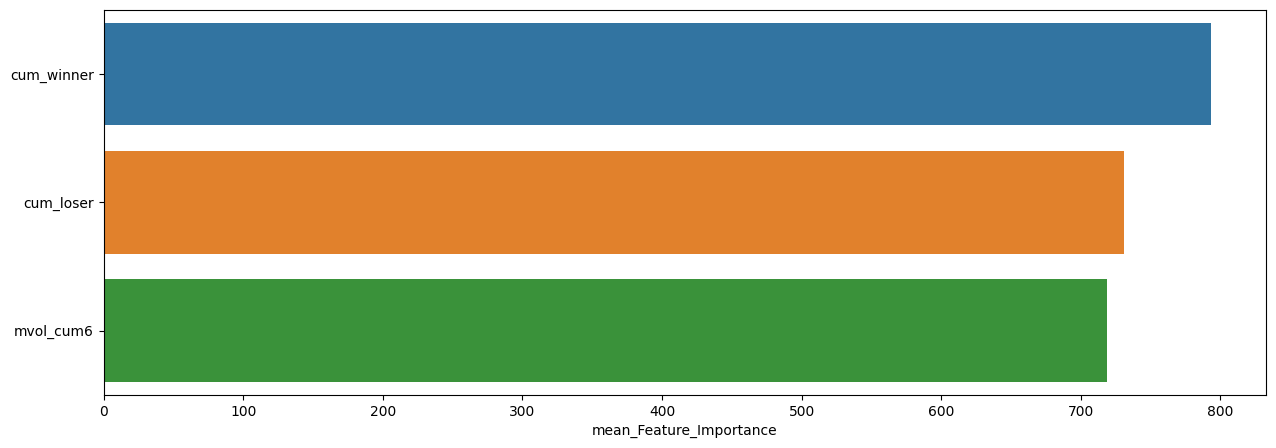

mean_Feature_Importance  max_Feature_Importance  \
cum_winner               793.061947                     990   
cum_loser                730.716814                     940   
mvol_cum6                718.455752                     897   

            min_Feature_Importance  
cum_winner                     593  
cum_loser                      553  
mvol_cum6                      548


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.28      0.21      0.24        70
         1.0       0.68      0.76      0.72       156

    accuracy                           0.59       226
   macro avg       0.48      0.49      0.48       226
weighted avg       0.56      0.59      0.57       226


accuracy : 0.588495575221239

precision : 0.6820809248554913

recall : 0.7564102564102564

F1-Score : 0.7173252279635258



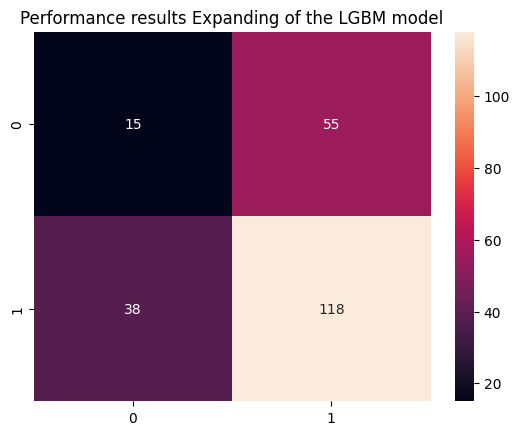


Feature Importance of the model



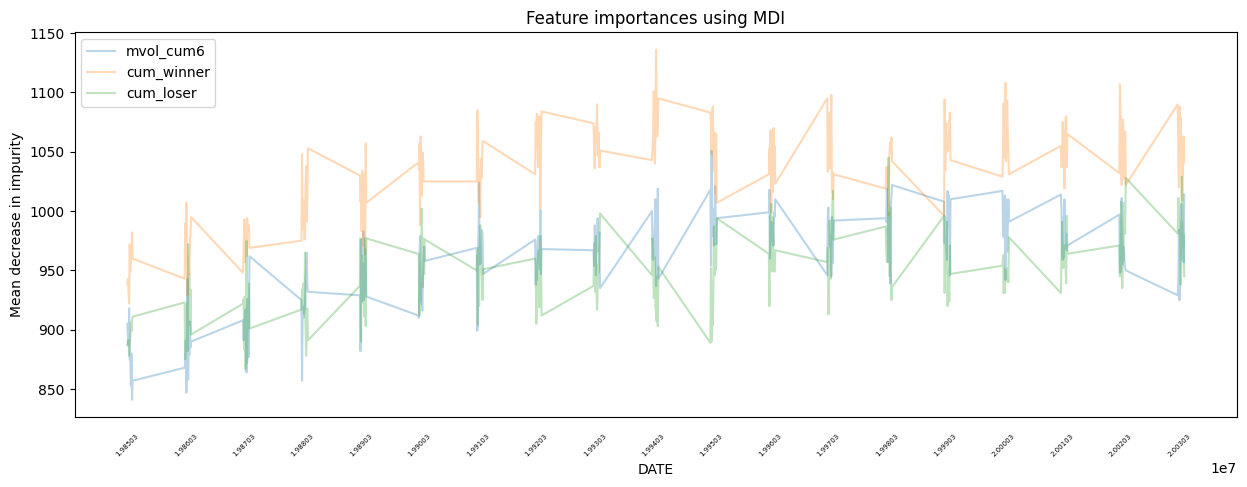

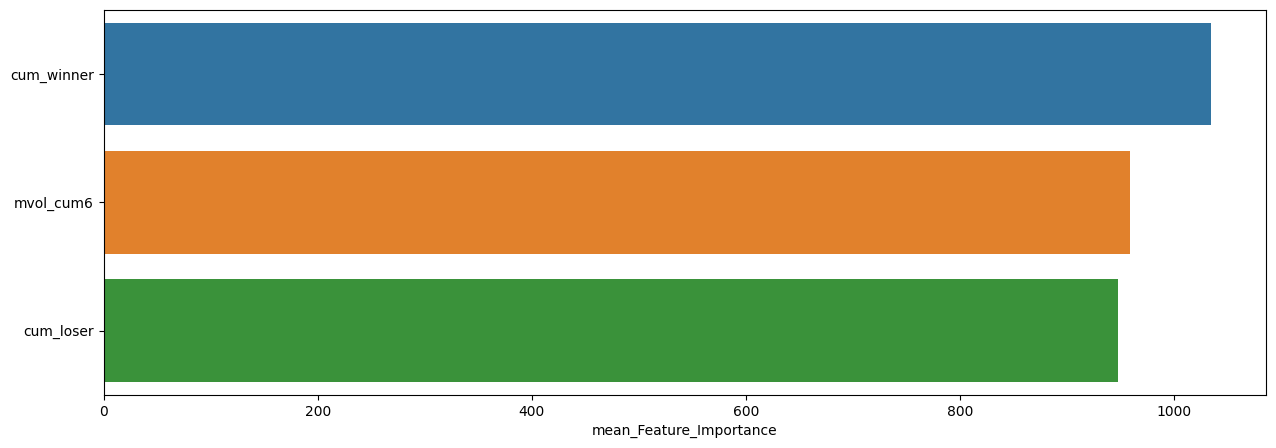

mean_Feature_Importance  max_Feature_Importance  \
cum_winner              1034.561947                    1136   
mvol_cum6                958.871681                    1051   
cum_loser                947.500000                    1045   

            min_Feature_Importance  
cum_winner                     922  
mvol_cum6                      841  
cum_loser                      867


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.26      0.31        96
         1.0       0.56      0.69      0.62       132

    accuracy                           0.51       228
   macro avg       0.47      0.47      0.46       228
weighted avg       0.48      0.51      0.49       228


accuracy : 0.5087719298245614

precision : 0.5617283950617284

recall : 0.6893939393939394

F1-Score : 0.6190476190476192



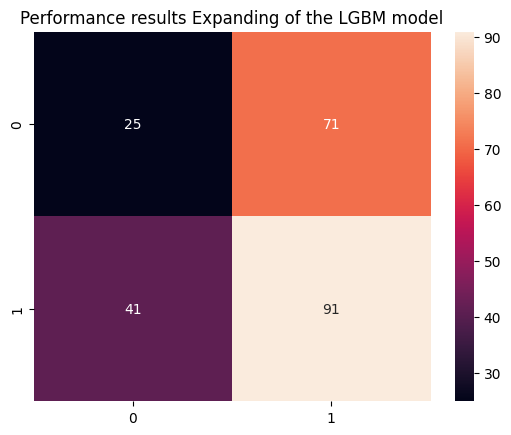


Feature Importance of the model



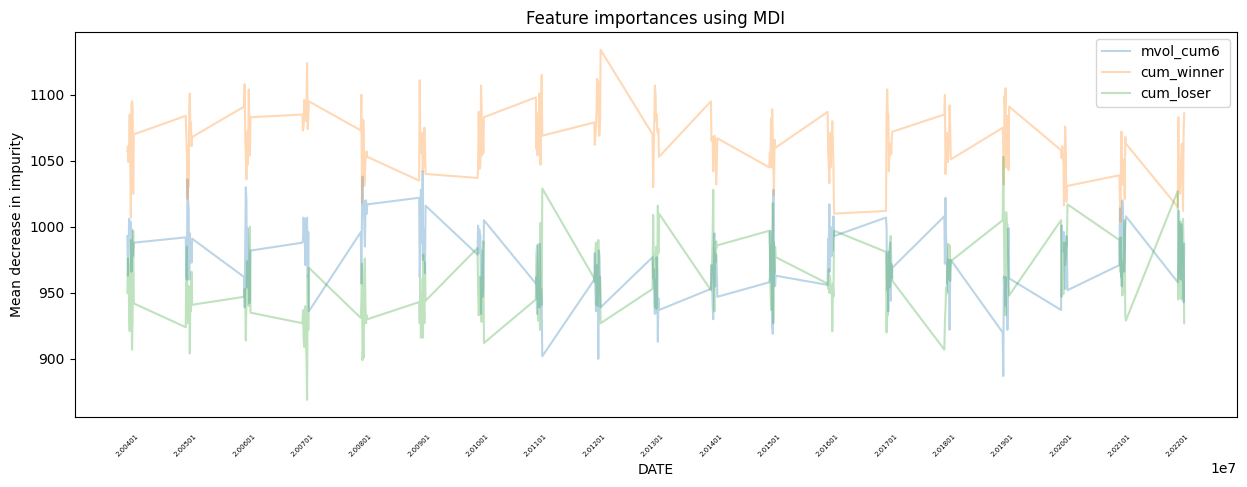

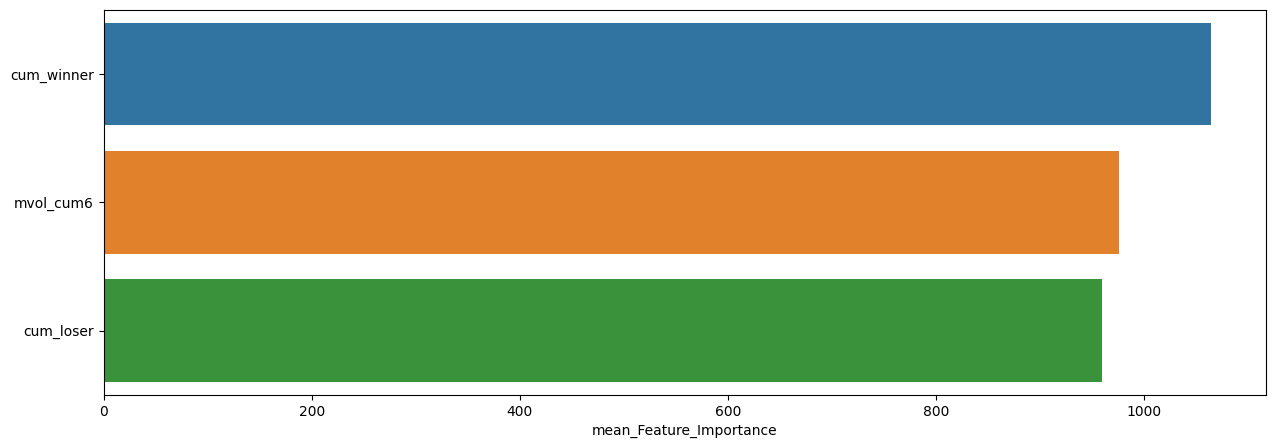

mean_Feature_Importance  max_Feature_Importance  \
cum_winner              1064.337719                    1134   
mvol_cum6                975.789474                    1042   
cum_loser                959.872807                    1053   

            min_Feature_Importance  
cum_winner                    1004  
mvol_cum6                      887  
cum_loser                      869

In [66]:
slice_feature_importance(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Expanding', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



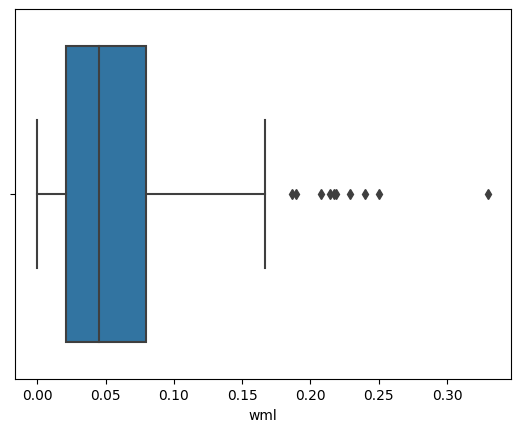

count      mean      std       min       25%       50%       75%  \
wml  436.0  0.055967  0.04714  0.000128  0.021166  0.045171  0.079476   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



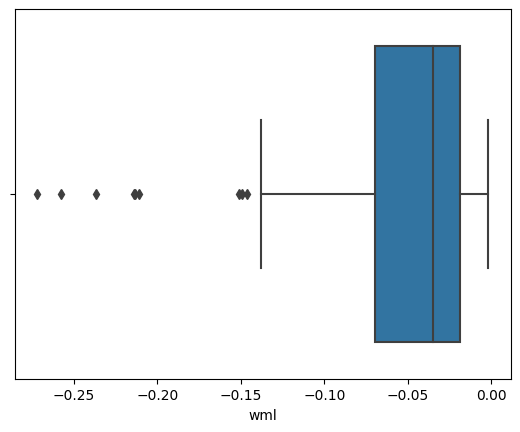

count      mean       std       min       25%       50%       75%  \
wml   90.0 -0.057599  0.060321 -0.271971 -0.069348 -0.034668 -0.018771   

          max  
wml -0.001641


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



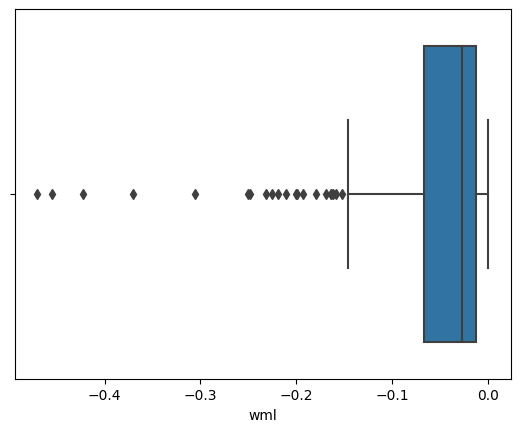

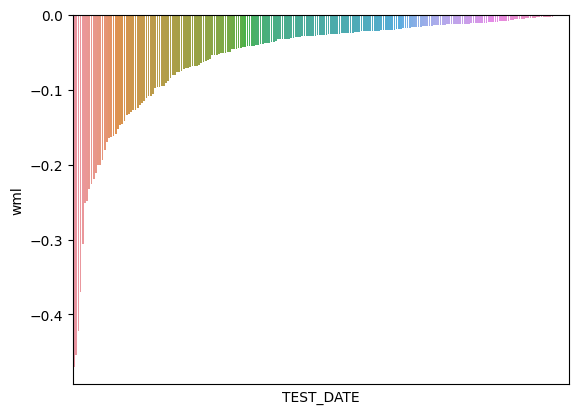

count      mean      std       min       25%       50%       75%  \
wml  226.0 -0.055798  0.07526 -0.469903 -0.067352 -0.027129 -0.013277   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



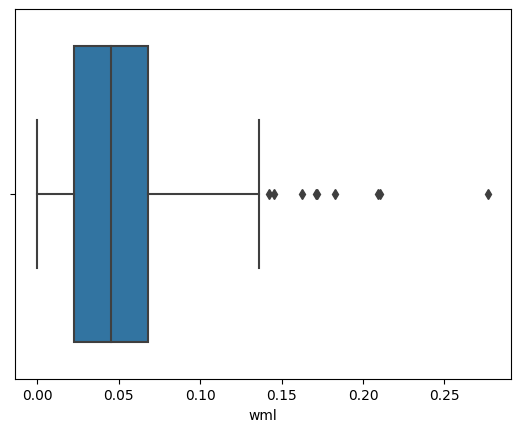

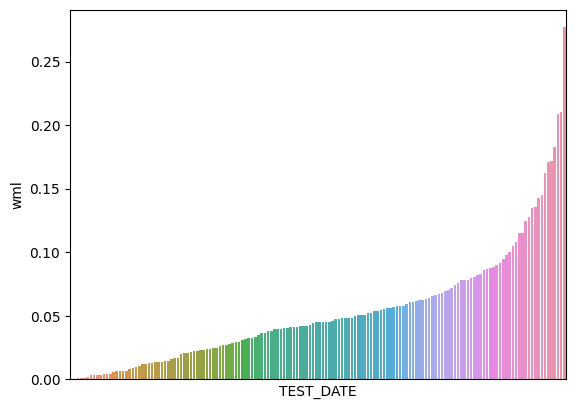

count     mean       std       min       25%       50%       75%  \
wml  154.0  0.05322  0.045958  0.000007  0.022272  0.044955  0.067848   

          max  
wml  0.276912

In [67]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Expanding_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.68968

최근 누적 수익률

  2022년-12월 -> 13141.56
  2022년-11월 -> 11840.22
  2022년-10월 -> 11262.50
  2022년-09월 -> 9972.68
  2022년-08월 -> 9066.56

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 29294.77
  2등 : 2002년-06월 -> 26586.70
  3등 : 2002년-09월 -> 26586.70
  4등 : 2002년-08월 -> 26586.70
  5등 : 2002년-07월 -> 26586.70
  6등 : 2009년-01월 -> 26084.93
  7등 : 2008년-11월 -> 25914.79
  8등 : 2008년-12월 -> 25301.39
  9등 : 2008년-06월 -> 24163.01
  10등 : 2002년-02월 -> 23851.72



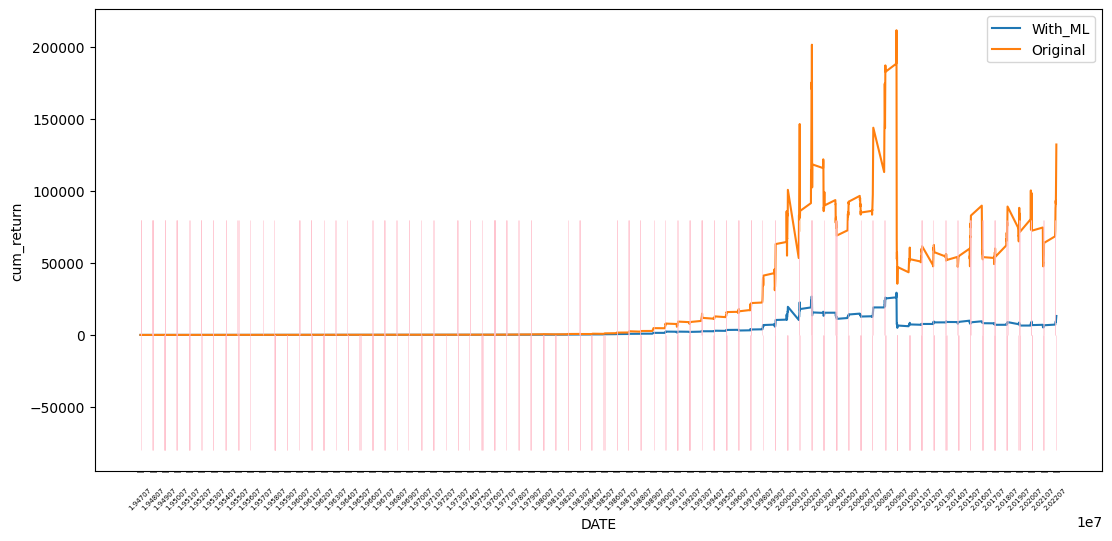

In [68]:
LGBM_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.72641

최근 누적 수익률

  2022년-12월 -> 13579.38
  2022년-11월 -> 12334.80
  2022년-10월 -> 11882.69
  2022년-09월 -> 10744.28
  2022년-08월 -> 10060.62

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 17440.75
  2등 : 2008년-11월 -> 15947.29
  3등 : 2009년-01월 -> 15932.90
  4등 : 2008년-12월 -> 15607.98
  5등 : 2002년-09월 -> 15351.59
  6등 : 2008년-06월 -> 14712.59
  7등 : 2008년-10월 -> 14672.35
  8등 : 2002년-07월 -> 14426.68
  9등 : 2002년-08월 -> 14234.68
  10등 : 2002년-06월 -> 14123.36



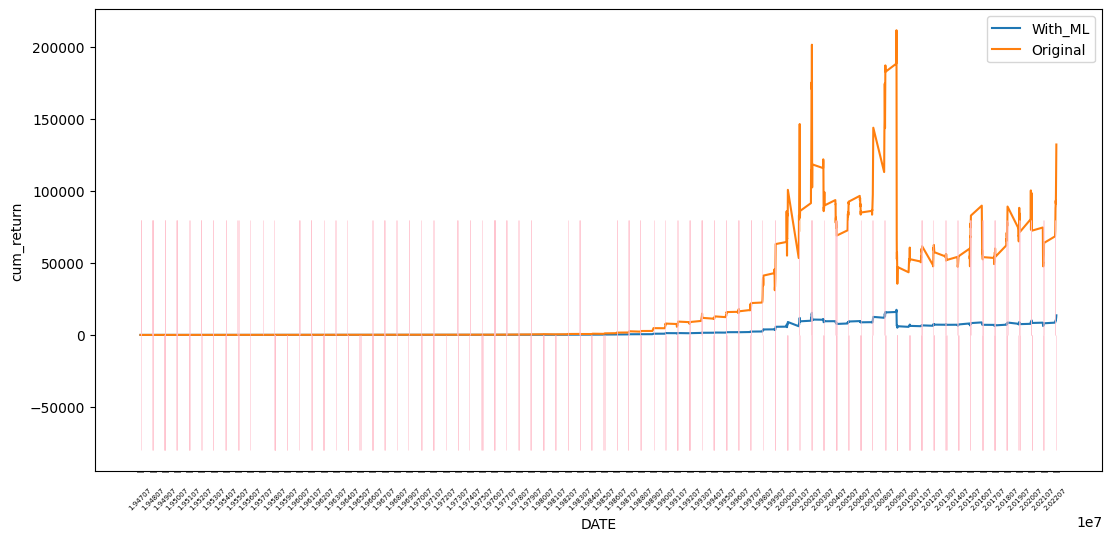

In [69]:
LGBM_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

# Performance

## F1 - Score

RDF의 F1-Score : 0.6992125984251969
GBC의 F1-Score : 0.692063492063492
XGB의 F1-Score : 0.6793075020610057
LGBM의 F1-Score : 0.6814449917898194



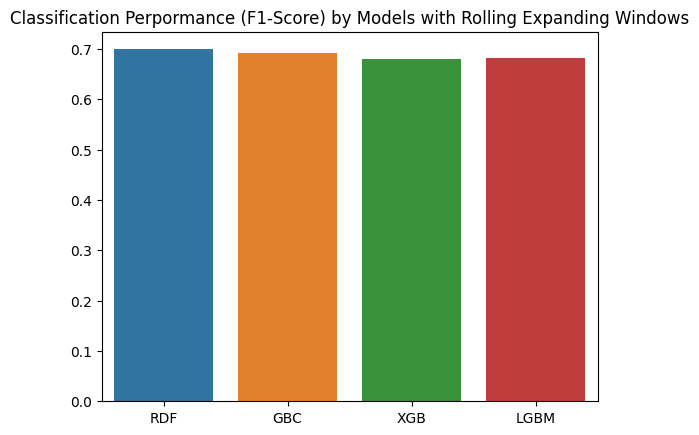

In [70]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

RDF의 F1-Score : 0.7127329192546584
GBC의 F1-Score : 0.7376928728875827
XGB의 F1-Score : 0.6802943581357318
LGBM의 F1-Score : 0.6964856230031949



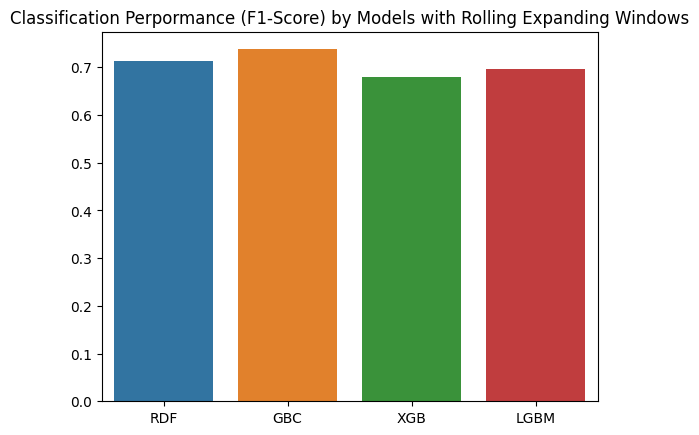

In [71]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

## Cum Return & Sharpe Ratio

In [72]:
R_WML = WML.loc[19470731:].copy()
CUM_WML = WML.loc[19470731:].copy()

CUM_WML['wml'] = (1 + CUM_WML.wml).cumprod() - 1
CUM_WML.columns = ['cum_return'] 

last_r = CUM_WML['cum_return'].values[-1]
w_S = (R_WML['wml'].mean()/R_WML['wml'].std()) * math.sqrt(12)

In [73]:
def compare_sharpe_ratio(list_model, list_result, list_cum, dynamic=True):

  print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format('ORG', w_S, last_r))

  for model, data, cum in zip(list_model, list_result, list_cum):
    data['wml'] = WML.loc[19470731:]['wml']

    if dynamic == True:

      data[f'{model}_PROB_WML'] = data['wml'] * data[f'{model}_PROB_POS_WML']
      S = (data[f'{model}_PROB_WML'].mean()/data[f'{model}_PROB_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))

      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

    else:

      data[f'{model}_PRED_WML'] = data['wml'] * data[f'{model}_PRED_POS_WML']
      S = (data[f'{model}_PRED_WML'].mean()/data[f'{model}_PRED_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))
      
      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

  sns.lineplot(data=CUM_WML, x=CUM_WML.index, y='cum_return', alpha=0.7, label='ORG')
  plt.title('Sharpe Ratio & Cum Return by Model')
  plt.xticks([CUM_WML.index[i] for i in range(0,len(CUM_WML.index), 12)])
  plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=1,
                    width=0.1)
  plt.show()

### Rolling Fixed Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.7069  최종 누적 수익률 : 20674.940379589316
GBC Sharpe Ratio : 0.6485  최종 누적 수익률 : 8303.49116859485
XGB Sharpe Ratio : 0.6844  최종 누적 수익률 : 11331.307291967209
LGBM Sharpe Ratio : 0.6155  최종 누적 수익률 : 4690.041509400377


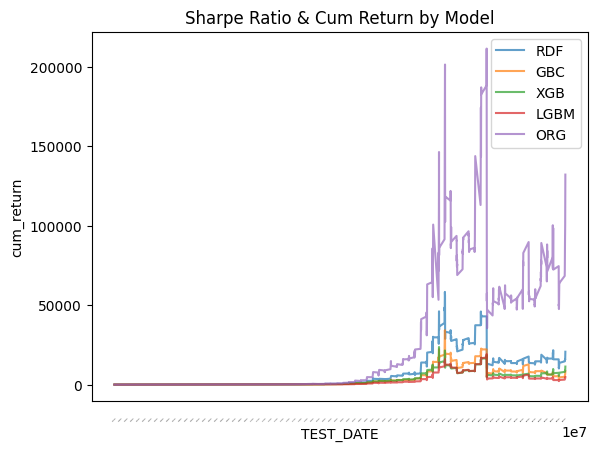

In [74]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_static, GBC_F_CUM_RETURN_static, XGB_F_CUM_RETURN_static, LGBM_F_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.7998  최종 누적 수익률 : 8490.570025277215
GBC Sharpe Ratio : 0.7486  최종 누적 수익률 : 7148.14877788293
XGB Sharpe Ratio : 0.7874  최종 누적 수익률 : 18071.794841984265
LGBM Sharpe Ratio : 0.7653  최종 누적 수익률 : 7367.437297878245


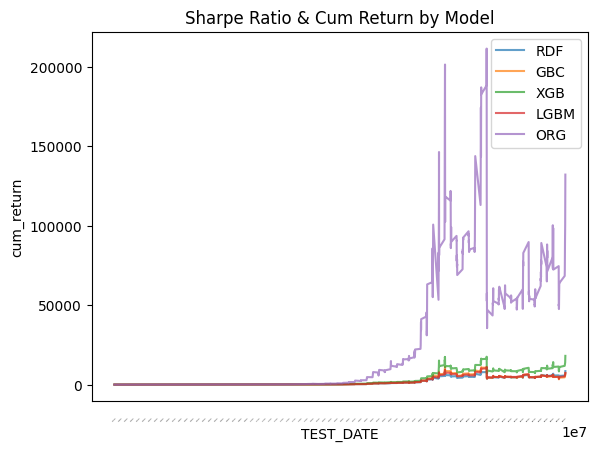

In [75]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_dynamic, GBC_F_CUM_RETURN_dynamic, XGB_F_CUM_RETURN_dynamic, LGBM_F_CUM_RETURN_dynamic],
                     dynamic=True)

### Rolling Expanding Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.7369  최종 누적 수익률 : 29632.631591270147
GBC Sharpe Ratio : 0.7473  최종 누적 수익률 : 61612.62685496304
XGB Sharpe Ratio : 0.6952  최종 누적 수익률 : 15021.220372860485
LGBM Sharpe Ratio : 0.6652  최종 누적 수익률 : 13141.558841462445


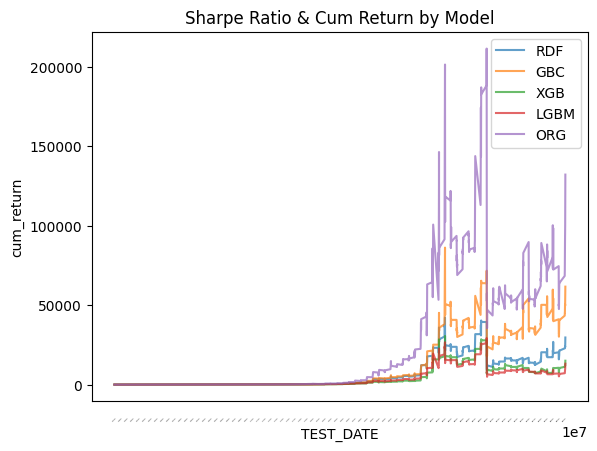

In [76]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_static, GBC_E_CUM_RETURN_static, XGB_E_CUM_RETURN_static, LGBM_E_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.8187  최종 누적 수익률 : 10502.280691241263
GBC Sharpe Ratio : 0.7463  최종 누적 수익률 : 5522.414006241406
XGB Sharpe Ratio : 0.7558  최종 누적 수익률 : 10846.579685662497
LGBM Sharpe Ratio : 0.7746  최종 누적 수익률 : 13579.382261398778


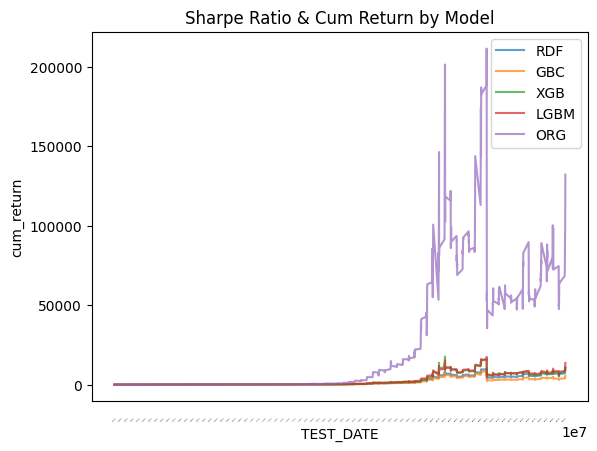

In [77]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_dynamic, GBC_E_CUM_RETURN_dynamic, XGB_E_CUM_RETURN_dynamic, LGBM_E_CUM_RETURN_dynamic],
                     dynamic=True)